# 0. Setup

In [ ]:
from google.colab import drive
drive.mount('/content/Gdrive')

Mounted at /content/Gdrive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import random
import numpy as np
import torch

# Set the seed value (e.g., 42)
# seed_value = 64

seed_value = 64

# Seed the random number generators
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)  # If using CUDA
torch.cuda.manual_seed_all(seed_value)  # If using multiple GPUs

# 1. Labels

In [ ]:
# # Example label mappings
pos_label2id = {
    'CC' : 0,  # Coordinating conjunction
    'CD' : 1,  # Cardinal number
    'OD' : 2,  # Ordinal Number
    'DT' : 3,  # Determiner
    'FW' : 4,  # Foreign word
    'IN' : 5,  # Preposition
    'JJ' : 6, # Adjective
    'MD' : 7, # Modal
    'NEG' : 8, # Negation
    'NN' : 9, # Noun
    'NNP' : 10, # Proper Noun
    'NND' : 11, # Classifier
    'PR' : 12, # Demonstrative Pronoun
    'PRP' : 13, # Personal Pronoun
    'RB' : 14, # Adverb
    'RP' : 15, # Particle
    'SC' : 16, # Subordinating Conjunction
    'SYM' : 17, # Symbol
    'UH' : 18, # Interjection
    'VB' : 19, # Verb
    'WH': 20, # Question
    'Z' : 21 # Punctuation
}

ner_label2id = {
    'O': 0,      # Outside (non-entity)
    'B-LOC': 1,  # Beginning of a location entity
    'I-LOC': 2,  # Inside a location entity
    'B-PERSON': 3,  # Beginning of a person entity
    'I-PERSON': 4,  # Inside a person entity
    'B-ORG': 5,  # Beginning of an organization entity
    'I-ORG': 6,  # Inside an organization entity
    'B-EVENT': 7, # Beginning of a miscellaneous entity
    'I-EVENT': 8,  # Inside a miscellaneous
    'B-GPE': 9,  # Beginning of a geopolitical entity
    'I-GPE': 10  # Inside a geopolitical entity
}

In [ ]:
pos_id2label = {v: k for k, v in pos_label2id.items()}
ner_id2label = {v: k for k, v in ner_label2id.items()}

# 2. Data

In [ ]:
full_dataset = pd.read_csv('/content/FinalDataset - Fix - Rechecked LOC n GPE - NoMISC - Sheet1 (1).csv')

full_dataset = full_dataset[:1099]

import ast

for col in full_dataset.columns:
    full_dataset[col] = full_dataset[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [ ]:
for index, row in full_dataset.iterrows():
  if len(row['tokens']) != len(row['pos_labels']) or len(row['tokens']) != len(row['ner_labels']):
    print(index, len(row['tokens']), len(row['ner_labels']), len(row['pos_labels']), sep='\t')


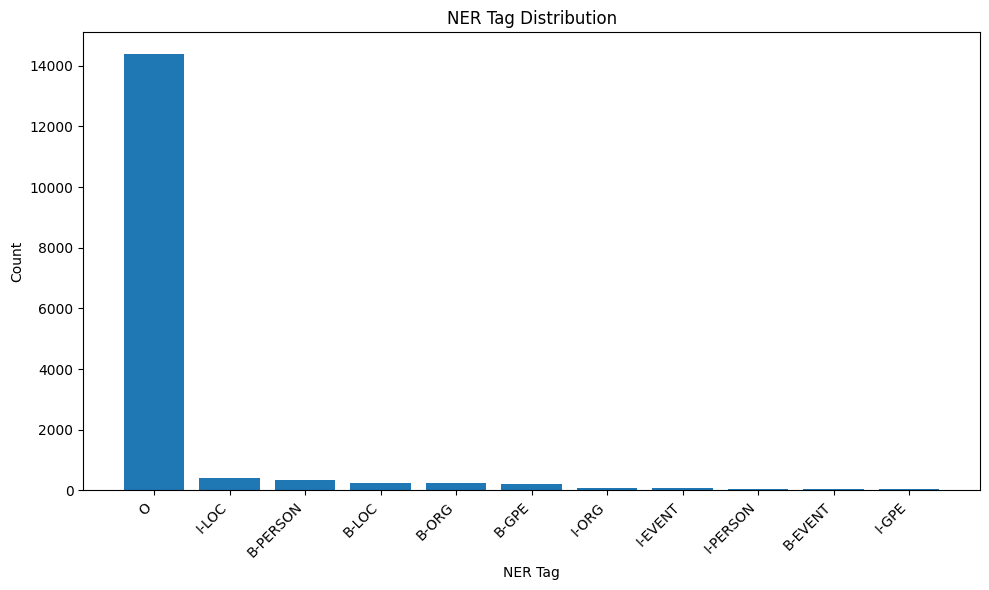

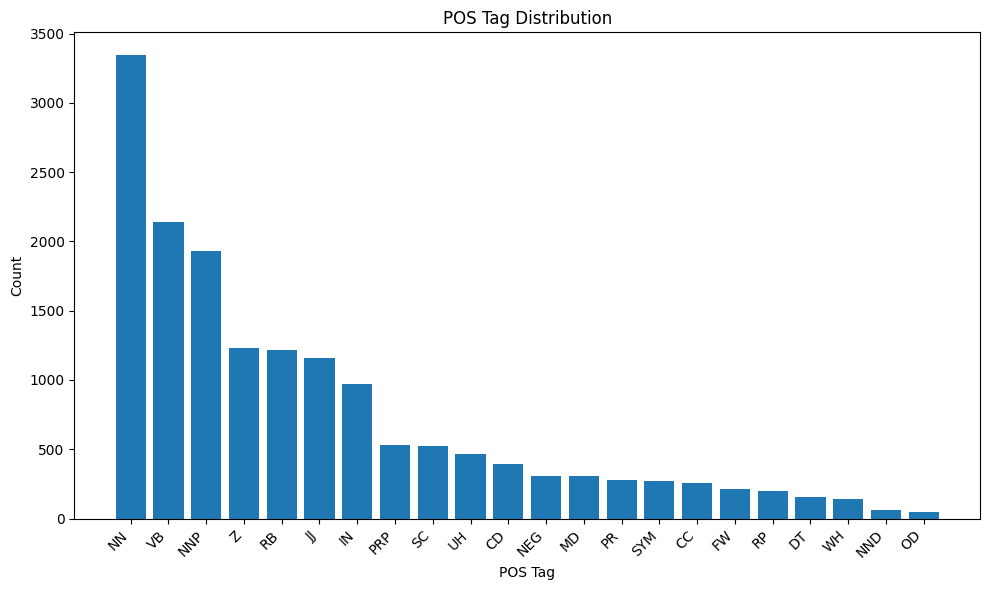

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

all_ner_tags = [tag for sent in full_dataset['ner_labels'] for tag in sent]
ner_counts = Counter(all_ner_tags)

labels, counts = zip(*sorted(ner_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xticks(rotation=45, ha='right')
plt.title("NER Tag Distribution")
plt.xlabel("NER Tag")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

all_pos_tags = [tag[0] if isinstance(tag, list) else tag for sent in full_dataset['pos_labels'] for tag in sent]
pos_counts = Counter(all_pos_tags)

labels_pos, counts_pos = zip(*sorted(pos_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(10, 6))
plt.bar(labels_pos, counts_pos)
plt.xticks(rotation=45, ha='right')
plt.title("POS Tag Distribution")
plt.xlabel("POS Tag")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

train_set, val_set = train_test_split(full_dataset, test_size=0.1, random_state=seed_value)

In [ ]:
print(len(train_set))
print(len(val_set))

989
110


In [ ]:
print(train_set.iloc[0])

tokens        [urban, legend, kampus, ui, depok]
ner_labels           [O, O, B-LOC, I-LOC, B-GPE]
pos_labels               [JJ, NN, NNP, NNP, NNP]
Name: 1078, dtype: object


# 5. CRF Setup

## 5.0 Tokenizer and Encoding

In [ ]:
from transformers import XLMRobertaTokenizerFast

# Load the tokenizer
tokenizer_crf = XLMRobertaTokenizerFast.from_pretrained('xlm-roberta-base')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [ ]:
def align_labels_crf(encoding, pos_labels, ner_labels, pos_label2id, ner_label2id):
    all_pos, all_ner = [], []

    for idx in range(len(encoding['input_ids'])):
        word_ids = encoding.word_ids(batch_index=idx)
        pos_seq, ner_seq = [], []
        words_pos = pos_labels[idx] if idx < len(pos_labels) else []
        words_ner = ner_labels[idx] if idx < len(ner_labels) else []
        w_idx = 0

        # keep track of the *string* of the current word’s entity tag
        current_ent = None

        for token_idx, word_id in enumerate(word_ids):
          try:
            # 1) Special / padding tokens
              if word_id is None:
                  pos_seq.append(-100)
                  ner_seq.append(-100)
                  current_ent = None
                  continue

              # 2) First subword of a word
              is_first = (token_idx == 0) or (word_id != word_ids[token_idx-1])
              if is_first:
                  # POS as before
                  if w_idx < len(words_pos):
                      pos_tag = words_pos[w_idx]
                      if isinstance(pos_tag, list):
                          pos_tag = pos_tag[0] if pos_tag else None
                      pos_seq.append(pos_label2id[pos_tag])
                  else:
                      pos_seq.append(-100)

                  # NER: take the word-level tag
                  if w_idx < len(words_ner):
                      ner_tag = words_ner[w_idx]
                      if isinstance(ner_tag, list):
                          ner_tag = ner_tag[0] if ner_tag else None
                      # store for continuations
                      current_ent = ner_tag
                      ner_seq.append(ner_label2id[ner_tag])
                  else:
                      # no word-level tag
                      current_ent = None
                      ner_seq.append(-100)

                  w_idx += 1

              # 3) Continuation subword
              else:
                  pos_seq.append(-100)

                  if current_ent is None or current_ent == "O":
                      # word wasn’t an entity or wasn’t tagged
                      ner_seq.append(ner_label2id["O"])
                  else:
                      # word was B-ENT or I-ENT, so continue with I-ENT
                      ent_type = current_ent.split("-", 1)[-1]  # e.g. "PER"
                      cont_tag = "I-" + ent_type
                      ner_seq.append(ner_label2id[cont_tag])
          except KeyError:
            print(f"Index {token_idx}")
            raise

        all_pos.append(pos_seq)
        all_ner.append(ner_seq)

    return all_pos, all_ner


In [ ]:
encoded_train = tokenizer_crf(
    train_set['tokens'].tolist(),
    is_split_into_words=True,
    return_offsets_mapping=True,
    padding=True,
    truncation=True,
    return_tensors="pt"
)

encoded_val = tokenizer_crf(
    val_set['tokens'].tolist(),
    is_split_into_words=True,
    return_offsets_mapping=True,
    padding=True,
    truncation=True,
    return_tensors="pt"
)

aligned_pos_labels_train, aligned_ner_labels_train = align_labels_crf(
    encoded_train,
    train_set['pos_labels'].tolist(),
    train_set['ner_labels'].tolist(),
    pos_label2id,
    ner_label2id
)

aligned_pos_labels_val, aligned_ner_labels_val = align_labels_crf(
    encoded_val,
    val_set['pos_labels'].tolist(),
    val_set['ner_labels'].tolist(),
    pos_label2id,
    ner_label2id
)

# Get the device from encoded['input_ids']
device = encoded_train['input_ids'].device

encoded_pos_labels_train = torch.tensor(aligned_pos_labels_train).to(device)
encoded_ner_labels_train = torch.tensor(aligned_ner_labels_train).to(device)

encoded_pos_labels_val = torch.tensor(aligned_pos_labels_val).to(device)
encoded_ner_labels_val = torch.tensor(aligned_ner_labels_val).to(device)

In [ ]:
print(encoded_train)

{'input_ids': tensor([[     0,  27081,  37254,  ...,      1,      1,      1],
        [     0,   5854,     33,  ...,      1,      1,      1],
        [     0,   2651,    485,  ...,      1,      1,      1],
        ...,
        [     0, 119752,    153,  ...,      1,      1,      1],
        [     0,    638,  70508,  ...,      1,      1,      1],
        [     0,   3437,   4497,  ...,      1,      1,      1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'offset_mapping': tensor([[[0, 0],
         [0, 5],
         [0, 6],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],

        [[0, 0],
         [0, 4],
         [4, 6],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],

        [[0, 0],
         [0, 4],
         [0, 3],
         ...,
         [0, 0],
         [0, 0

## 5.1 Model

In [ ]:
!pip install pytorch-crf

In [ ]:
import torch
import torch.nn as nn
from transformers import XLMRobertaModel, XLMRobertaPreTrainedModel

In [ ]:
from torchcrf import CRF
import torch.nn as nn

class XLMRobertaForMultiTaskTokenClassificationWithCRF(XLMRobertaPreTrainedModel):
    def __init__(self, config, num_pos_labels, num_ner_labels):
        super().__init__(config)
        assert num_pos_labels > 0 and num_ner_labels > 0
        self.num_pos_labels = num_pos_labels
        self.num_ner_labels = num_ner_labels

        self.roberta = XLMRobertaModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        self.classifier_pos = nn.Linear(config.hidden_size, num_pos_labels)
        self.classifier_ner = nn.Linear(config.hidden_size, num_ner_labels)

        self.crf = CRF(num_tags=num_ner_labels, batch_first=True)
        self.init_weights()

    def forward(self,
                input_ids=None,
                attention_mask=None,
                labels_pos=None,
                labels_ner=None):
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        seq_out = self.dropout(outputs.last_hidden_state)

        # POS
        logits_pos = self.classifier_pos(seq_out)
        loss = 0.0
        if labels_pos is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            pos_loss = loss_fct(
                logits_pos.view(-1, self.num_pos_labels),
                labels_pos.view(-1)
            )
            # print(loss)
            loss += pos_loss

        # NER with CRF
        emissions_ner = self.classifier_ner(seq_out)

        if labels_ner is not None:
            mask = attention_mask.bool()
            # labels_ner already has no -100
            log_likelihood = self.crf(
                emissions_ner,
                labels_ner,
                mask=mask,
                reduction='mean'
            )
            # print(-log_likelihood)
            ner_alpha = 0.3
            loss += -log_likelihood * ner_alpha


        # Decode for inference
        ner_preds = None

        mask = attention_mask.bool()
        ner_preds = self.crf.decode(emissions_ner, mask=mask)

        return {
            "loss": loss,
            "logits_pos": logits_pos,
            "pos_loss" : pos_loss,
            "ner_loss": -log_likelihood,
            "emissions_ner": emissions_ner,
            "predictions_ner": ner_preds,
        }


In [ ]:
ner_label2id["PAD"] = 11
ner_id2label[11] = "PAD"

In [ ]:
from transformers import XLMRobertaConfig
from transformers import XLMRobertaModel

config = XLMRobertaConfig.from_pretrained('xlm-roberta-base')

# Specify the number of POS and NER labels
num_pos_labels = len(pos_label2id)  # Example: Adjust based on your POS label set
num_ner_labels = len(ner_label2id)   # Example: Adjust based on your NER label set

# Instantiate the model
model = XLMRobertaForMultiTaskTokenClassificationWithCRF(config, num_pos_labels, num_ner_labels)
model.roberta = XLMRobertaModel.from_pretrained('xlm-roberta-base', config=config)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
# Immediately after model = XLMRobertaForMultiTaskTokenClassificationWithCRF(...)
transitions = model.crf.transitions  # this is a nn.Parameter of shape (num_tags, num_tags)
print("CRF transitions shape:", transitions.shape)
print("Any NaN?", torch.isnan(transitions).any().item())
print("Any +Inf?", torch.isposinf(transitions).any().item())
print("Any -Inf?", torch.isneginf(transitions).any().item())
print("Transition stats:", transitions.min().item(), transitions.max().item())

CRF transitions shape: torch.Size([12, 12])
Any NaN? False
Any +Inf? False
Any -Inf? False
Transition stats: -0.09962993860244751 0.09843508154153824


In [ ]:
transitions = model.crf.transitions
print(transitions)

Parameter containing:
tensor([[ 0.0700,  0.0490,  0.0394, -0.0628,  0.0106, -0.0305,  0.0506,  0.0856,
         -0.0329, -0.0525, -0.0779,  0.0610],
        [ 0.0649,  0.0618, -0.0753,  0.0555, -0.0852,  0.0114, -0.0132,  0.0844,
         -0.0854, -0.0618,  0.0154, -0.0187],
        [-0.0836,  0.0190, -0.0866, -0.0082, -0.0160,  0.0251, -0.0572,  0.0956,
          0.0239,  0.0475, -0.0801,  0.0046],
        [-0.0664,  0.0758,  0.0770,  0.0569, -0.0524, -0.0587, -0.0198, -0.0669,
         -0.0027,  0.0130,  0.0571,  0.0378],
        [ 0.0984,  0.0695,  0.0197, -0.0934, -0.0324,  0.0209, -0.0177,  0.0069,
          0.0139,  0.0109,  0.0848,  0.0472],
        [-0.0125,  0.0496,  0.0459, -0.0006, -0.0707, -0.0173, -0.0996, -0.0430,
          0.0932, -0.0126,  0.0607,  0.0646],
        [-0.0439,  0.0609,  0.0751, -0.0838, -0.0863,  0.0449,  0.0808,  0.0183,
         -0.0946,  0.0269, -0.0030, -0.0169],
        [-0.0227, -0.0989,  0.0273,  0.0128, -0.0693, -0.0521, -0.0772,  0.0459,
        

In [ ]:
num_tags = model.crf.num_tags

legal = torch.ones(num_tags, num_tags, dtype=torch.bool)

b_labels = [nid for lab, nid in ner_label2id.items() if lab.startswith("B-")]
i_labels = [nid for lab, nid in ner_label2id.items() if lab.startswith("I-")]

# 2) Forbid I-X → I-Y when X != Y
for i in i_labels:
    for j in i_labels:
        if i != j:
            legal[i, j] = False

# 3) Forbid B-X → I-Y when X != Y (only allow B-X→I-X)
for b in b_labels:
    b_ent = ner_id2label[b].split("-", 1)[1]
    for j in i_labels:
        j_ent = ner_id2label[j].split("-", 1)[1]
        if b_ent != j_ent:
            legal[b, j] = False

# 4) Forbid O → I-X entirely
o_id = ner_label2id["O"]
for j in i_labels:
    legal[o_id, j] = False

for j in [ner_label2id['I-LOC'], ner_label2id['I-PERSON'], ner_label2id['I-ORG'], ner_label2id['I-EVENT'], ner_label2id['I-GPE']]:
    legal[ner_label2id['PAD']][j] = False

In [ ]:
legal

tensor([[ True,  True, False,  True, False,  True, False,  True, False,  True,
         False,  True],
        [ True,  True,  True,  True, False,  True, False,  True, False,  True,
         False,  True],
        [ True,  True,  True,  True, False,  True, False,  True, False,  True,
         False,  True],
        [ True,  True, False,  True,  True,  True, False,  True, False,  True,
         False,  True],
        [ True,  True, False,  True,  True,  True, False,  True, False,  True,
         False,  True],
        [ True,  True, False,  True, False,  True,  True,  True, False,  True,
         False,  True],
        [ True,  True, False,  True, False,  True,  True,  True, False,  True,
         False,  True],
        [ True,  True, False,  True, False,  True, False,  True,  True,  True,
         False,  True],
        [ True,  True, False,  True, False,  True, False,  True,  True,  True,
         False,  True],
        [ True,  True, False,  True, False,  True, False,  True, False,  

In [ ]:
model.crf.register_buffer("transition_mask", legal.float())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

XLMRobertaForMultiTaskTokenClassificationWithCRF(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, 

In [ ]:
with torch.no_grad():
    # transitions is an nn.Parameter of shape (T, T)
    mask = model.crf.transition_mask         # 1.0 for legal, 0.0 for illegal
    neg_inf = -1e9
    model.crf.transitions.data = (
        model.crf.transitions.data * mask
        + neg_inf * (1.0 - mask)
    )

In [ ]:
# Ensure the mask is on the same device
mask = model.crf.transition_mask.to('cuda' if torch.cuda.is_available() else 'cpu')

# Hook fires during backprop, replacing grad w/ grad*mask
model.crf.transitions.register_hook(lambda grad: grad * mask)

In [ ]:
transitions = model.crf.transitions
print(transitions)

Parameter containing:
tensor([[ 7.0045e-02,  4.9022e-02, -1.0000e+09, -6.2786e-02, -1.0000e+09,
         -3.0547e-02, -1.0000e+09,  8.5650e-02, -1.0000e+09, -5.2504e-02,
         -1.0000e+09,  6.0967e-02],
        [ 6.4869e-02,  6.1824e-02, -7.5306e-02,  5.5467e-02, -1.0000e+09,
          1.1376e-02, -1.0000e+09,  8.4434e-02, -1.0000e+09, -6.1750e-02,
         -1.0000e+09, -1.8686e-02],
        [-8.3583e-02,  1.9002e-02, -8.6597e-02, -8.2423e-03, -1.0000e+09,
          2.5141e-02, -1.0000e+09,  9.5602e-02, -1.0000e+09,  4.7474e-02,
         -1.0000e+09,  4.6217e-03],
        [-6.6382e-02,  7.5797e-02, -1.0000e+09,  5.6896e-02, -5.2375e-02,
         -5.8709e-02, -1.0000e+09, -6.6924e-02, -1.0000e+09,  1.2992e-02,
         -1.0000e+09,  3.7795e-02],
        [ 9.8435e-02,  6.9486e-02, -1.0000e+09, -9.3417e-02, -3.2431e-02,
          2.0862e-02, -1.0000e+09,  6.8535e-03, -1.0000e+09,  1.0924e-02,
         -1.0000e+09,  4.7176e-02],
        [-1.2506e-02,  4.9611e-02, -1.0000e+09, -5.5933e-0

In [ ]:
# After model instantiation, before model.to(device)
import torch

bad_buffers = []
for name, buf in model.named_buffers():
    if not torch.is_floating_point(buf):
        continue  # only floats can have NaN/Inf
    nan = torch.isnan(buf).any().item()
    pinf = torch.isposinf(buf).any().item()
    ninf = torch.isneginf(buf).any().item()
    if nan or pinf or ninf:
        bad_buffers.append((name, nan, pinf, ninf))

if bad_buffers:
    for name, nan, pinf, ninf in bad_buffers:
        print(f"Buffer {name} has NaN={nan}, +Inf={pinf}, -Inf={ninf}")
    raise RuntimeError("Found bad buffers—please reinitialize or investigate.")
else:
    print("All buffers look clean. Moving to CUDA…")
    model.to('cuda')
    print("Success!")


All buffers look clean. Moving to CUDA…
Success!


In [ ]:
# After model instantiation, before model.to('cuda')
bad_params = []
for name, param in model.named_parameters():
    if not torch.is_floating_point(param):
        continue
    nan = torch.isnan(param).any().item()
    pinf = torch.isposinf(param).any().item()
    ninf = torch.isneginf(param).any().item()
    if nan or pinf or ninf:
        bad_params.append((name, nan, pinf, ninf))

if bad_params:
    for name, nan, pinf, ninf in bad_params:
        print(f"Parameter {name} has NaN={nan}, +Inf={pinf}, -Inf={ninf}")
    raise RuntimeError("Found bad parameters—please reinitialize or investigate.")
else:
    print("All parameters look clean. Moving to CUDA…")
    model.to('cuda')
    print("Success!")


All parameters look clean. Moving to CUDA…
Success!


In [ ]:
import torch, torchcrf; print(torch.__version__, torch.version.cuda, torchcrf.__version__)

2.6.0+cu124 12.4 0.7.2


## 5.2 Train

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

Epoch 1/100
  Train Loss: 21.1820
  Val   Loss: 20.7081
  Val Perplexity: 984936704.0000
  Train POS Loss: 3.1309
  Val   POS Loss: 3.1028
  Train NER Loss: 60.1706
  Val   NER Loss: 58.6843
              precision    recall  f1-score   support

          CC       0.00      0.00      0.00        33
          CD       0.00      0.00      0.00        45
          DT       0.00      0.00      0.00        13
          FW       0.00      0.00      0.00        48
          IN       0.00      0.00      0.00       110
          JJ       0.00      0.00      0.00       134
          MD       0.00      0.00      0.00        31
         NEG       0.00      0.00      0.00        29
          NN       0.50      0.00      0.01       383
         NND       0.00      0.00      0.00         9
         NNP       0.00      0.00      0.00       194
          OD       0.00      0.00      0.00         4
          PR       0.00      0.00      0.00        34
         PRP       0.00      0.00      0.00        7

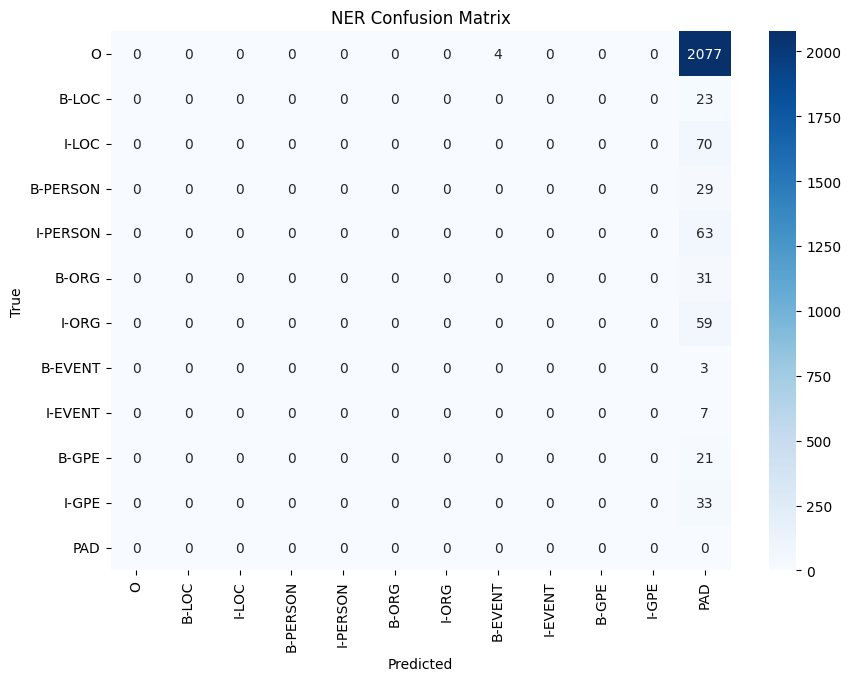

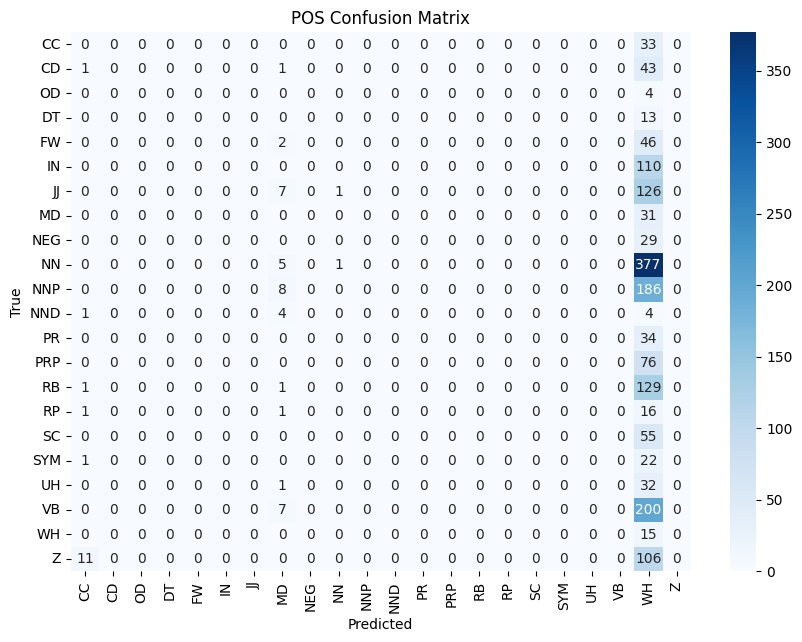

Saving model with highest POS F1 score: 0.001  and NER F1 score: 0.0  from epoch 1 , Validation Loss : 20.7081


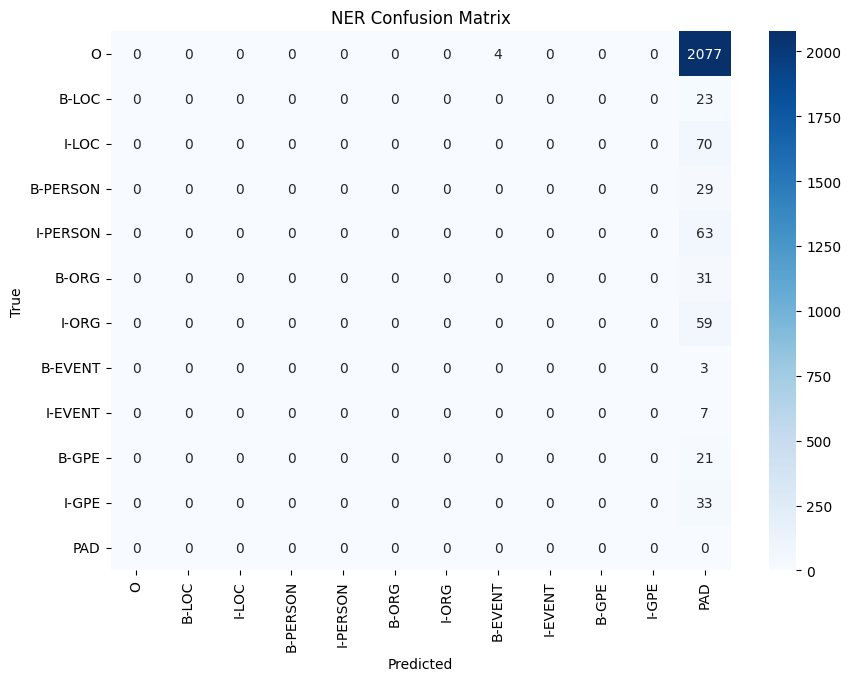

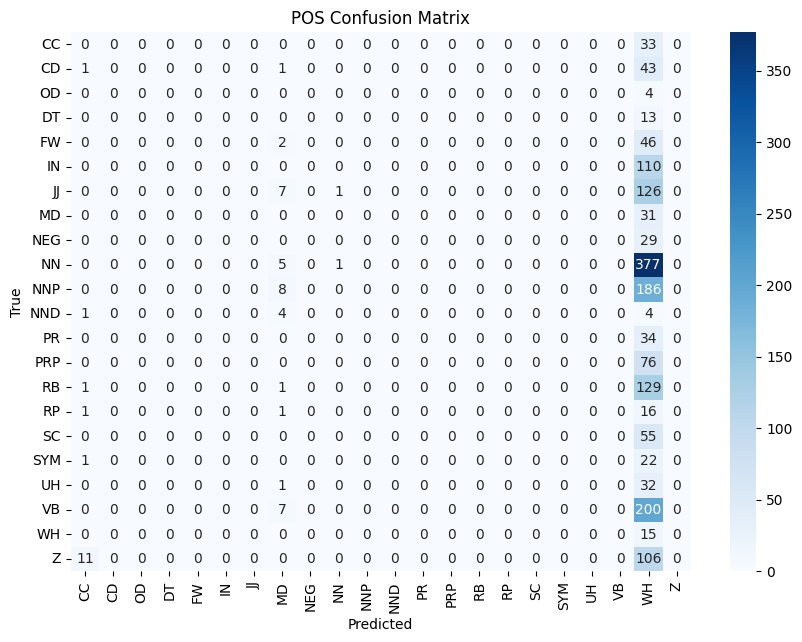

Epoch 2/100
  Train Loss: 13.0896
  Val   Loss: 7.1809
  Val Perplexity: 1314.0442
  Train POS Loss: 3.1305
  Val   POS Loss: 3.0312
  Train NER Loss: 33.1969
  Val   NER Loss: 13.8323
              precision    recall  f1-score   support

          CC       0.00      0.00      0.00        33
          CD       0.00      0.00      0.00        45
          DT       0.00      0.00      0.00        13
          FW       0.37      0.58      0.45        48
          IN       0.08      0.89      0.15       110
          JJ       0.00      0.00      0.00       134
          MD       0.00      0.00      0.00        31
         NEG       0.00      0.00      0.00        29
          NN       0.18      0.01      0.01       383
         NND       0.00      0.00      0.00         9
         NNP       0.00      0.00      0.00       194
          OD       0.00      0.00      0.00         4
          PR       0.00      0.00      0.00        34
         PRP       0.00      0.00      0.00        76
    

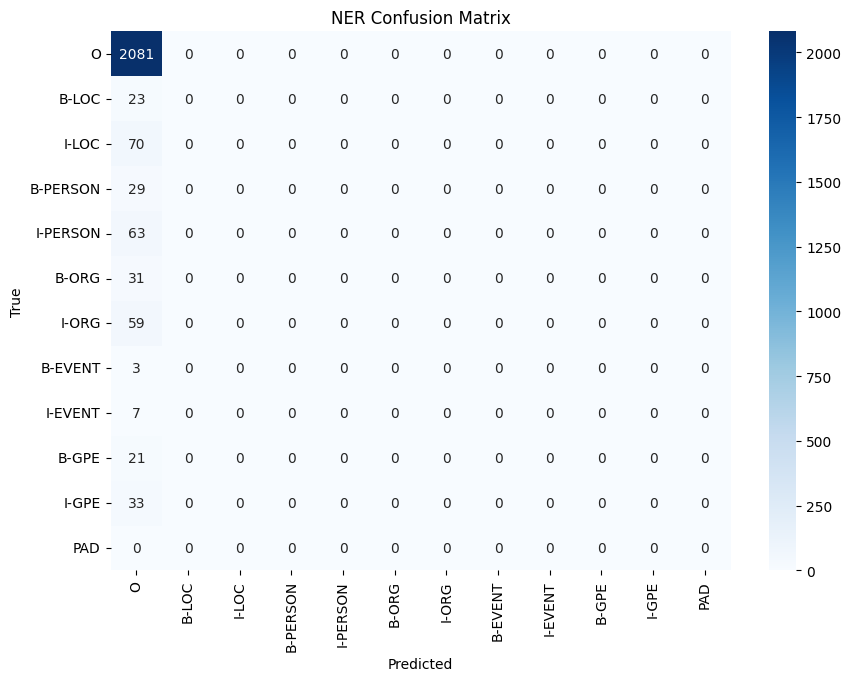

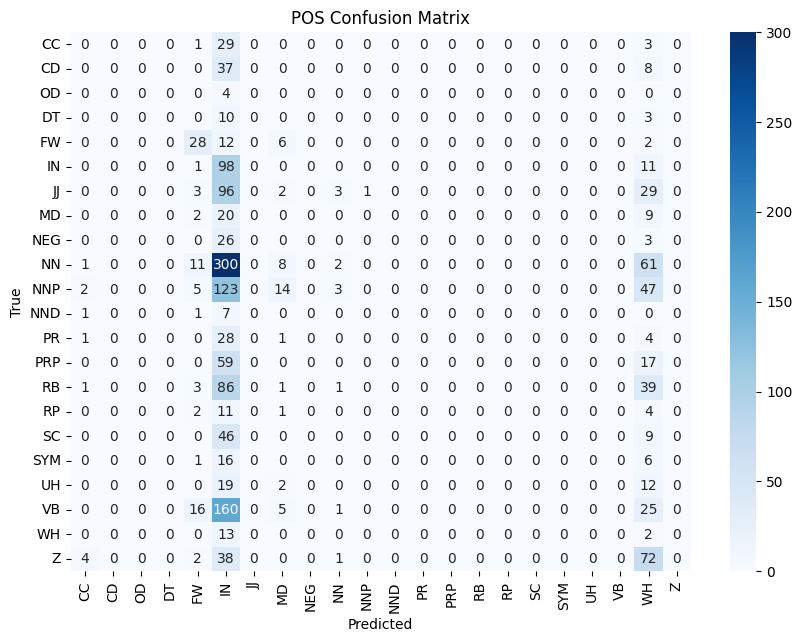

Saving model with highest POS F1 score: 0.028  and NER F1 score: 0.084  from epoch 2 , Validation Loss : 7.1809


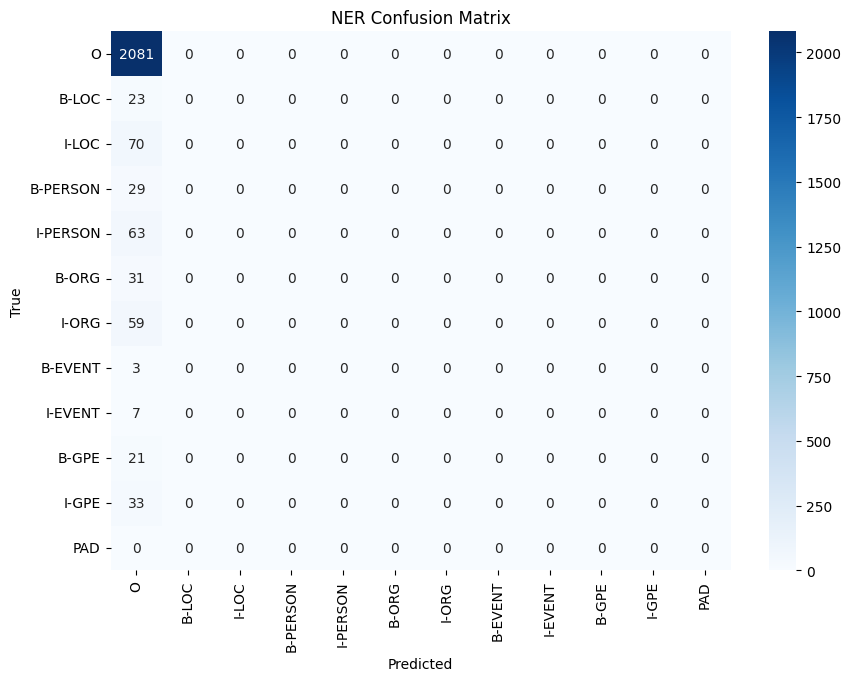

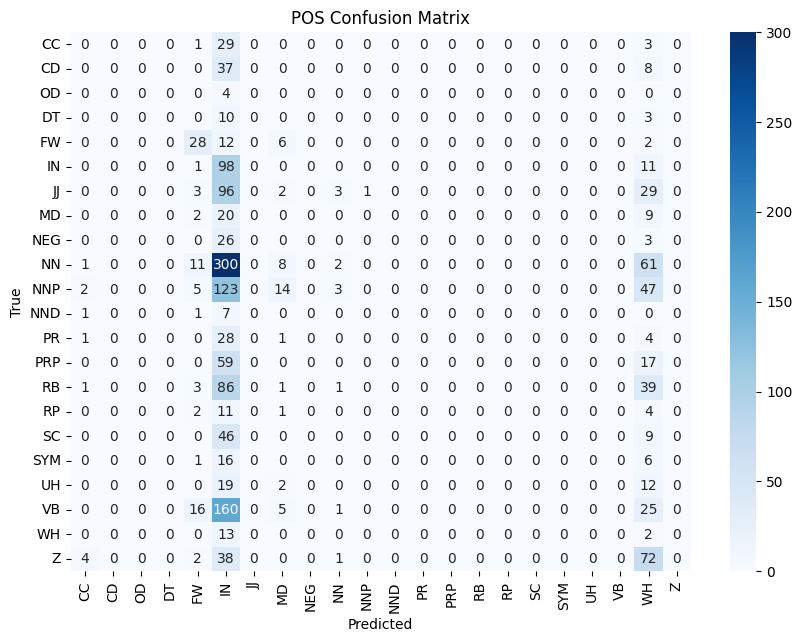

Epoch 3/100
  Train Loss: 6.6412
  Val   Loss: 5.6673
  Val Perplexity: 289.2505
  Train POS Loss: 2.8442
  Val   POS Loss: 2.6582
  Train NER Loss: 12.6565
  Val   NER Loss: 10.0305
              precision    recall  f1-score   support

          CC       0.00      0.00      0.00        33
          CD       0.00      0.00      0.00        45
          DT       0.00      0.00      0.00        13
          FW       0.00      0.00      0.00        48
          IN       0.00      0.00      0.00       110
          JJ       0.00      0.00      0.00       134
          MD       0.00      0.00      0.00        31
         NEG       0.00      0.00      0.00        29
          NN       0.22      1.00      0.36       383
         NND       0.00      0.00      0.00         9
         NNP       0.14      0.01      0.01       194
          OD       0.00      0.00      0.00         4
          PR       0.00      0.00      0.00        34
         PRP       0.00      0.00      0.00        76
      

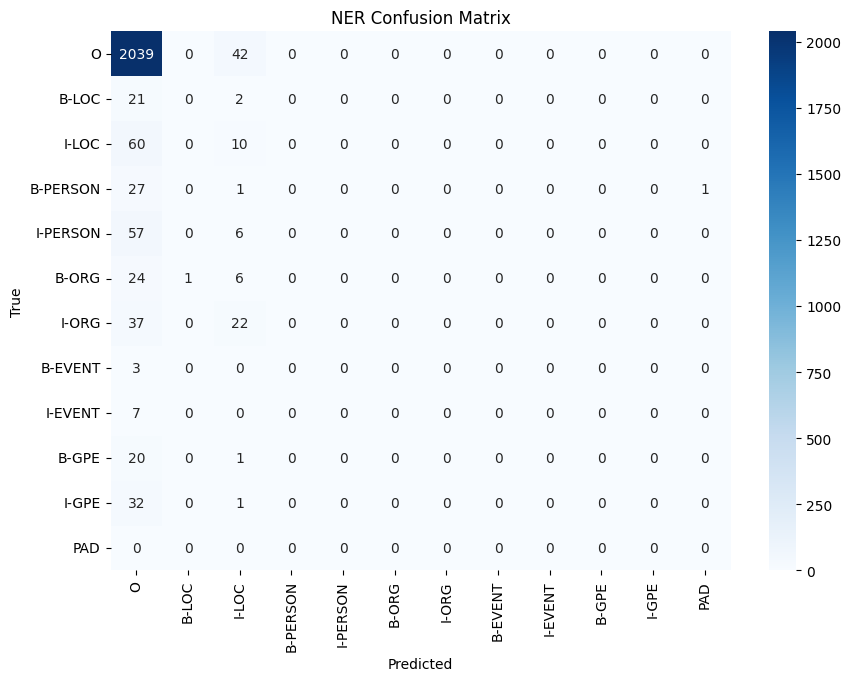

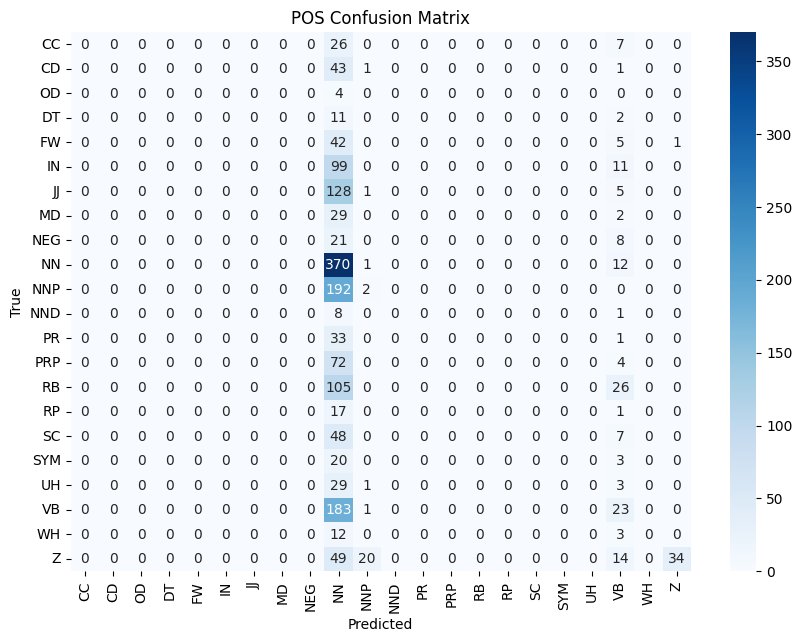

Saving model with highest POS F1 score: 0.045  and NER F1 score: 0.087  from epoch 4 , Validation Loss : 4.9193


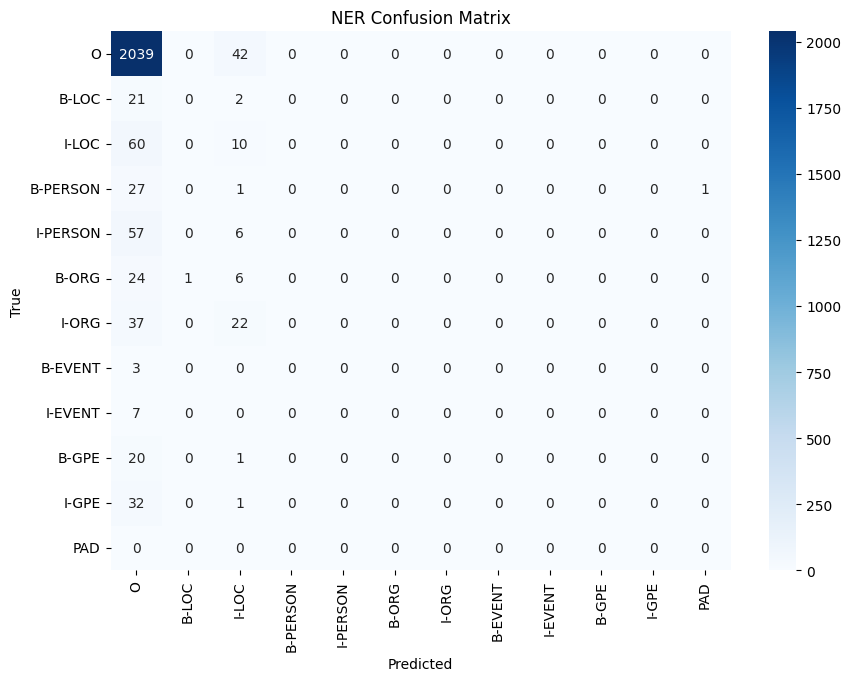

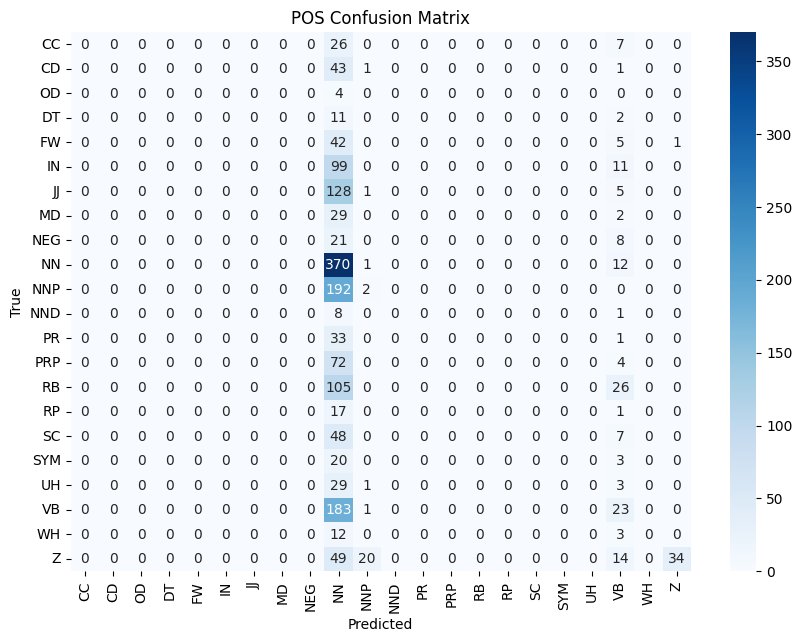

Epoch 5/100
  Train Loss: 4.6766
  Val   Loss: 3.9647
  Val Perplexity: 52.7043
  Train POS Loss: 2.5649
  Val   POS Loss: 2.4997
  Train NER Loss: 7.0390
  Val   NER Loss: 4.8834
              precision    recall  f1-score   support

          CC       0.00      0.00      0.00        33
          CD       0.00      0.00      0.00        45
          DT       0.00      0.00      0.00        13
          FW       0.00      0.00      0.00        48
          IN       0.00      0.00      0.00       110
          JJ       0.00      0.00      0.00       134
          MD       0.00      0.00      0.00        31
         NEG       0.00      0.00      0.00        29
          NN       0.26      0.96      0.41       383
         NND       0.00      0.00      0.00         9
         NNP       0.07      0.01      0.01       194
          OD       0.00      0.00      0.00         4
          PR       0.00      0.00      0.00        34
         PRP       0.00      0.00      0.00        76
         

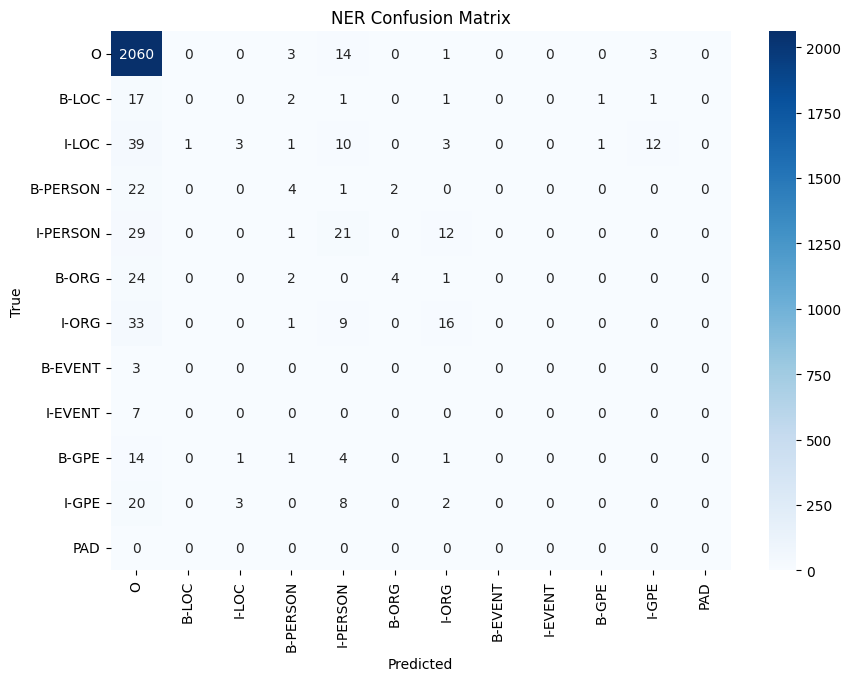

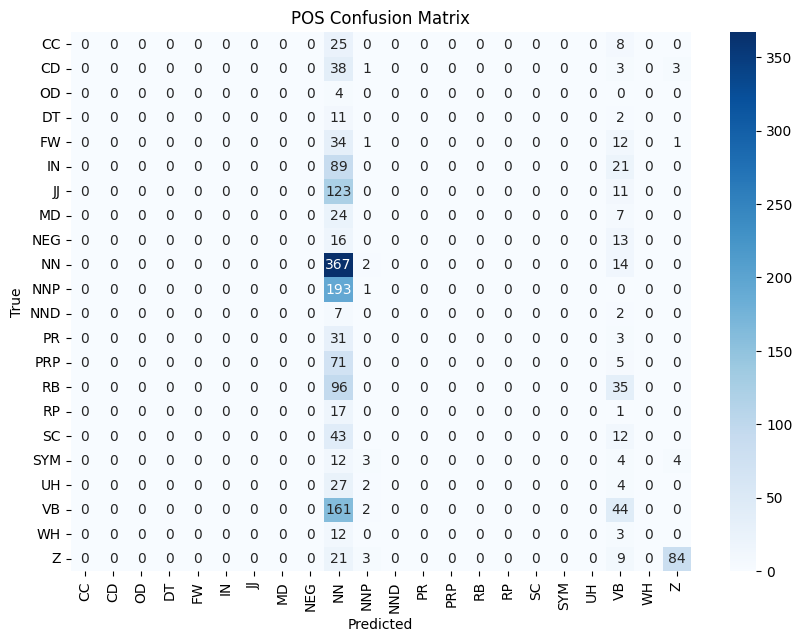

Saving model with highest POS F1 score: 0.065  and NER F1 score: 0.189  from epoch 5 , Validation Loss : 3.9647


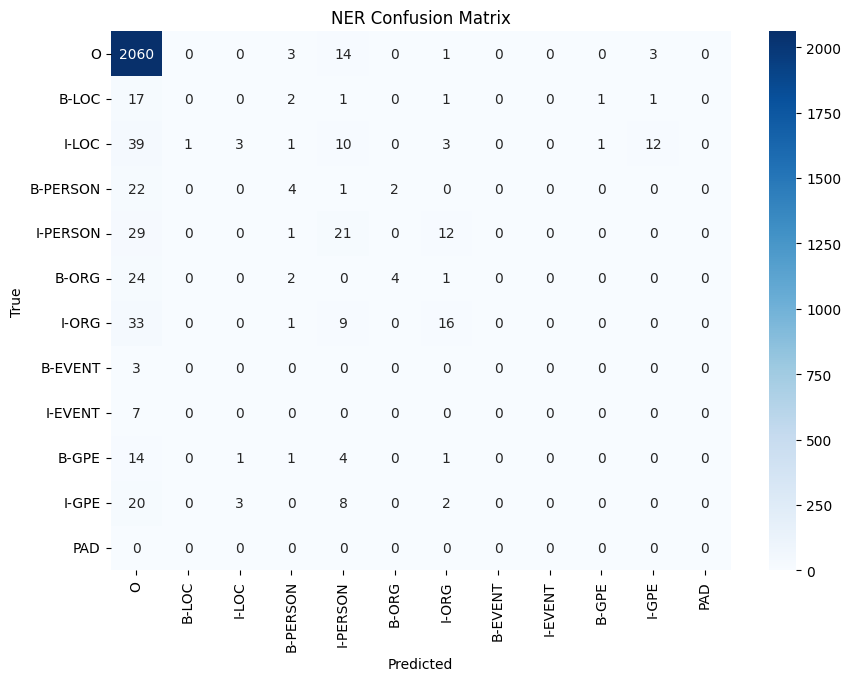

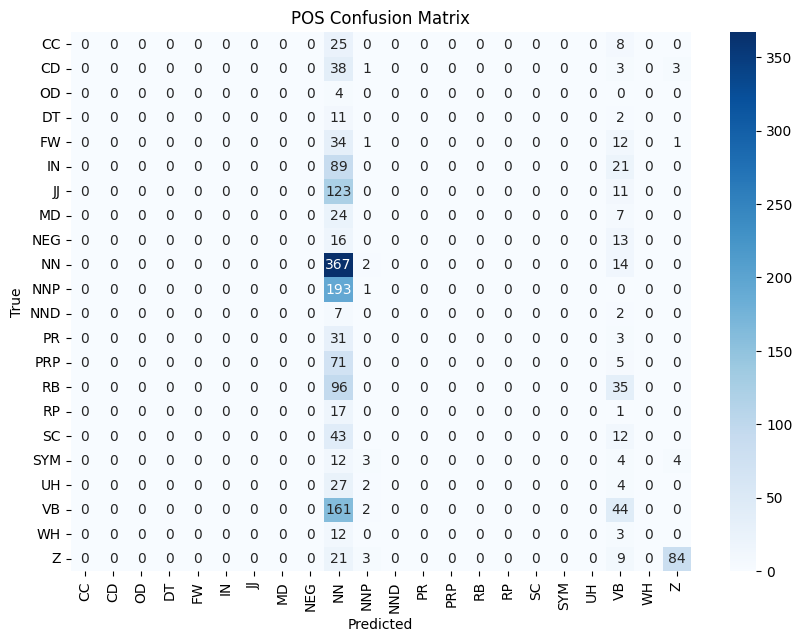

Epoch 6/100
  Train Loss: 3.9662
  Val   Loss: 3.3485
  Val Perplexity: 28.4610
  Train POS Loss: 2.4438
  Val   POS Loss: 2.2893
  Train NER Loss: 5.0748
  Val   NER Loss: 3.5309
              precision    recall  f1-score   support

          CC       0.00      0.00      0.00        33
          CD       0.00      0.00      0.00        45
          DT       0.00      0.00      0.00        13
          FW       0.00      0.00      0.00        48
          IN       0.00      0.00      0.00       110
          JJ       0.00      0.00      0.00       134
          MD       0.00      0.00      0.00        31
         NEG       0.00      0.00      0.00        29
          NN       0.28      0.92      0.43       383
         NND       0.00      0.00      0.00         9
         NNP       0.73      0.42      0.53       194
          OD       0.00      0.00      0.00         4
          PR       0.00      0.00      0.00        34
         PRP       0.00      0.00      0.00        76
         

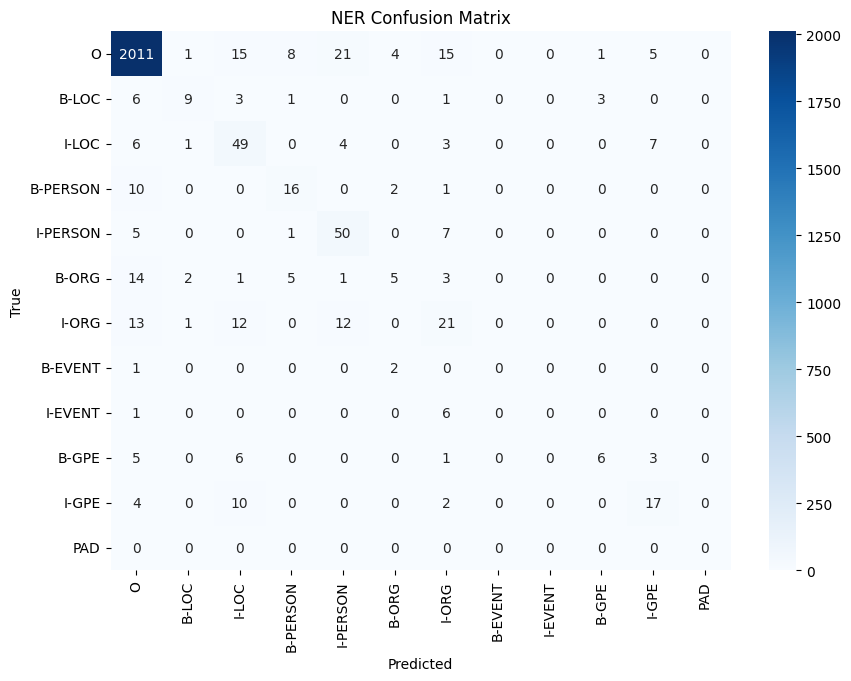

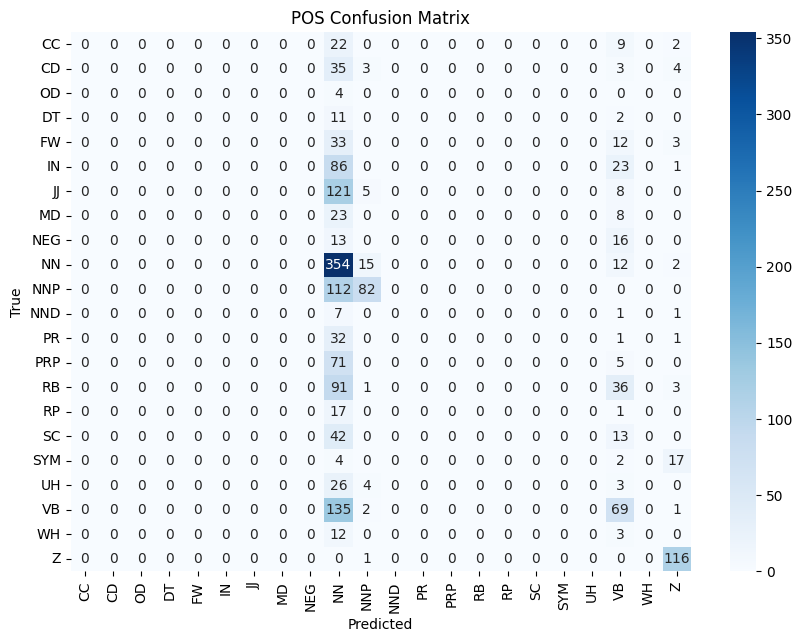

Saving model with highest POS F1 score: 0.098  and NER F1 score: 0.43  from epoch 6 , Validation Loss : 3.3485


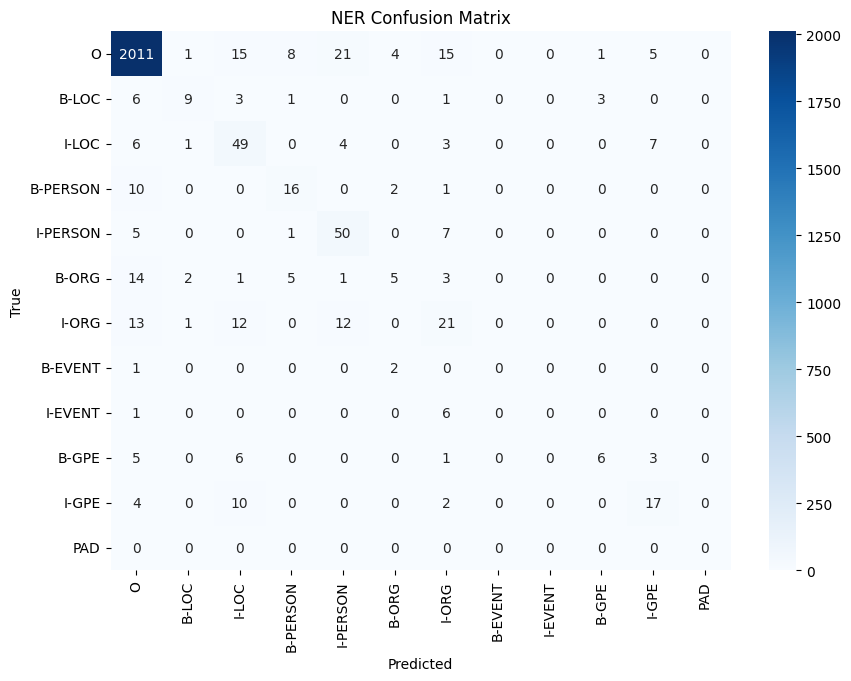

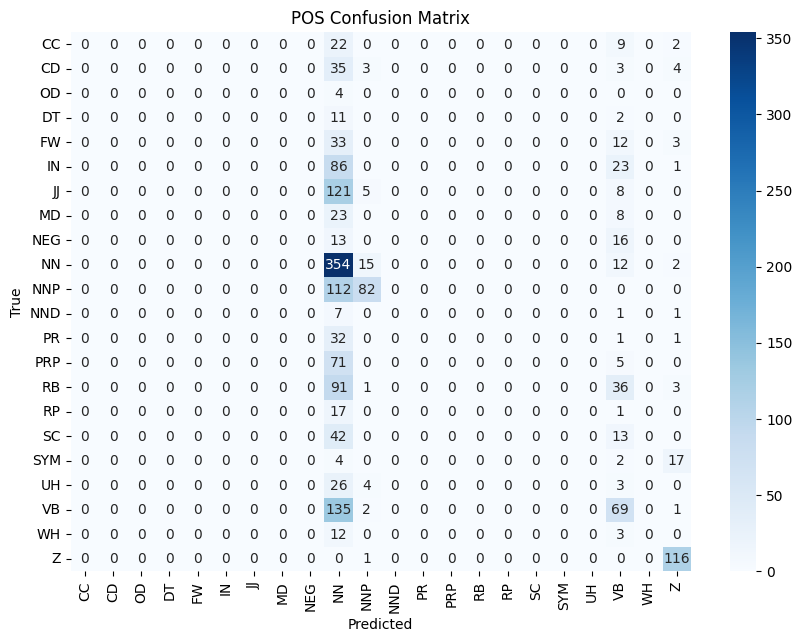

Epoch 7/100
  Train Loss: 3.3563
  Val   Loss: 3.0466
  Val Perplexity: 21.0429
  Train POS Loss: 2.1960
  Val   POS Loss: 2.0092
  Train NER Loss: 3.8675
  Val   NER Loss: 3.4578
              precision    recall  f1-score   support

          CC       0.00      0.00      0.00        33
          CD       0.00      0.00      0.00        45
          DT       0.00      0.00      0.00        13
          FW       0.00      0.00      0.00        48
          IN       0.83      0.39      0.53       110
          JJ       0.00      0.00      0.00       134
          MD       0.00      0.00      0.00        31
         NEG       0.00      0.00      0.00        29
          NN       0.38      0.86      0.53       383
         NND       0.00      0.00      0.00         9
         NNP       0.64      0.86      0.73       194
          OD       0.00      0.00      0.00         4
          PR       0.00      0.00      0.00        34
         PRP       0.00      0.00      0.00        76
         

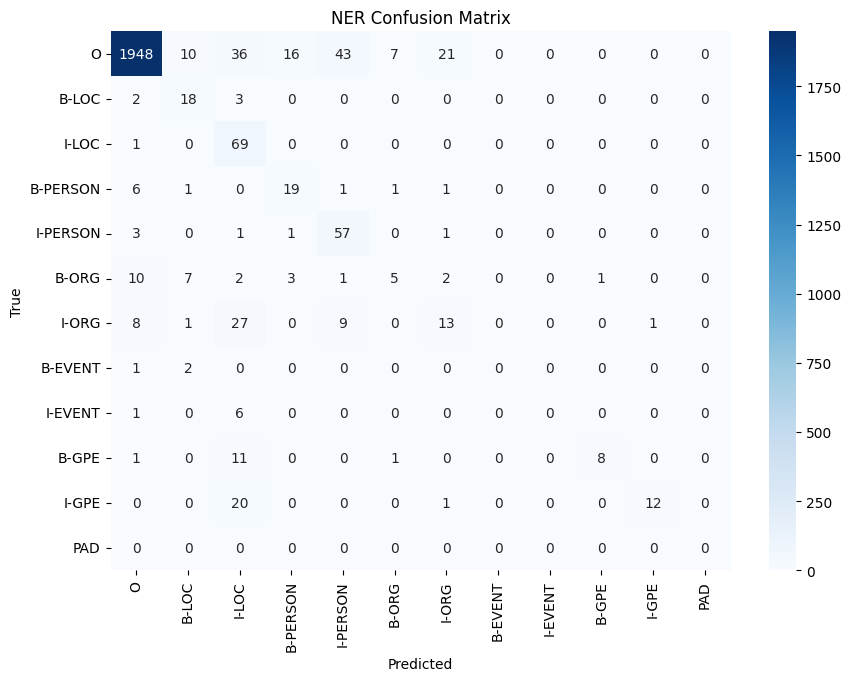

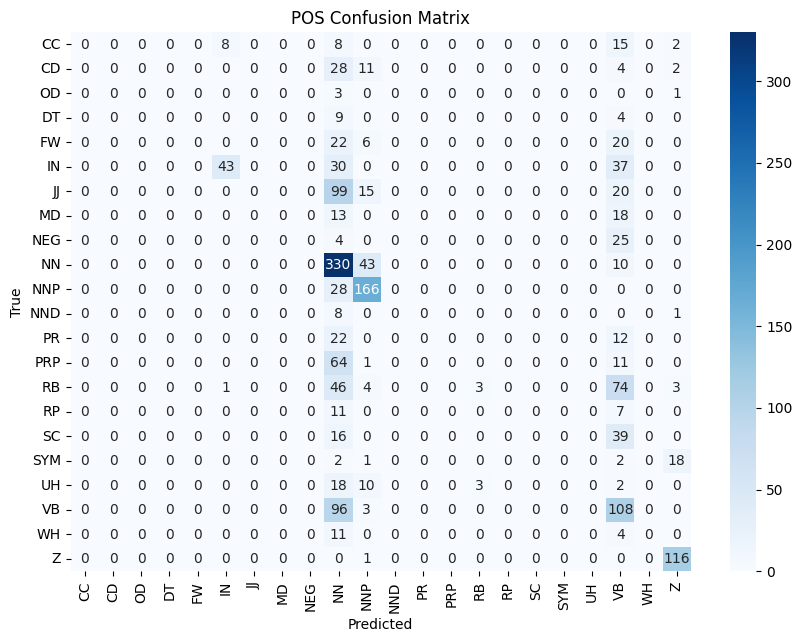

Saving model with highest POS F1 score: 0.14  and NER F1 score: 0.442  from epoch 7 , Validation Loss : 3.0466


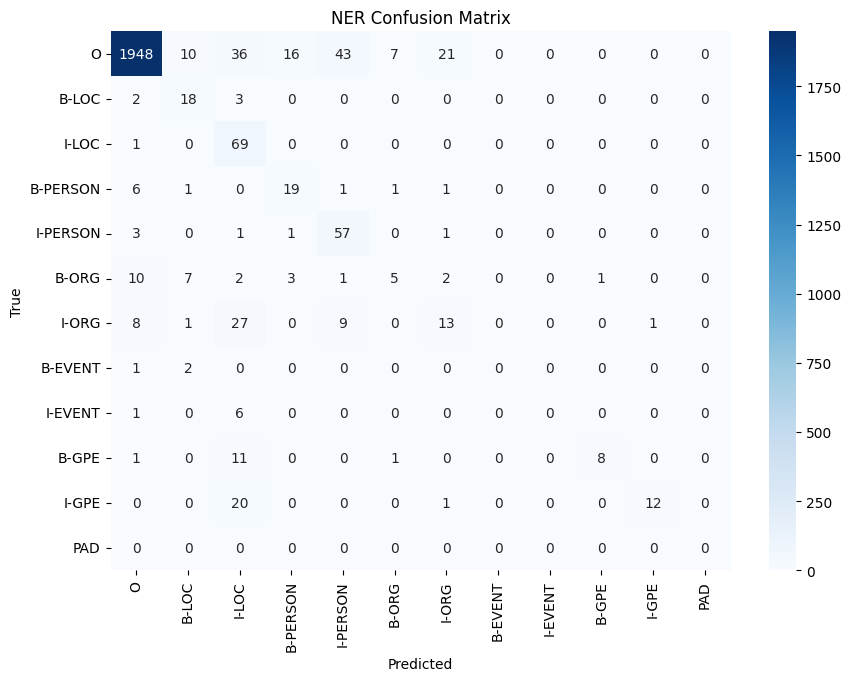

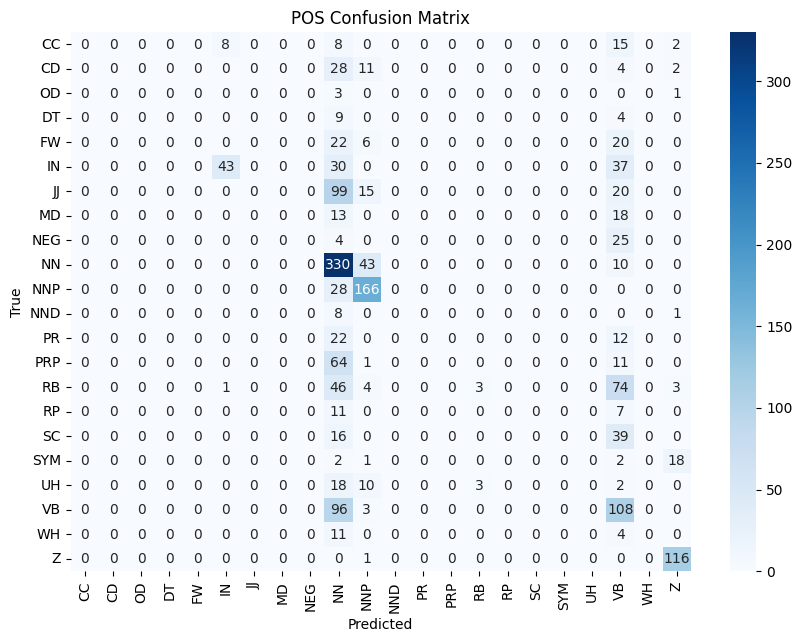

Epoch 8/100
  Train Loss: 2.7929
  Val   Loss: 2.4942
  Val Perplexity: 12.1122
  Train POS Loss: 1.9033
  Val   POS Loss: 1.7234
  Train NER Loss: 2.9654
  Val   NER Loss: 2.5695
              precision    recall  f1-score   support

          CC       0.00      0.00      0.00        33
          CD       1.00      0.09      0.16        45
          DT       0.00      0.00      0.00        13
          FW       0.00      0.00      0.00        48
          IN       0.71      0.64      0.67       110
          JJ       0.00      0.00      0.00       134
          MD       0.00      0.00      0.00        31
         NEG       0.00      0.00      0.00        29
          NN       0.57      0.82      0.67       383
         NND       0.00      0.00      0.00         9
         NNP       0.67      0.87      0.76       194
          OD       0.00      0.00      0.00         4
          PR       0.00      0.00      0.00        34
         PRP       0.00      0.00      0.00        76
         

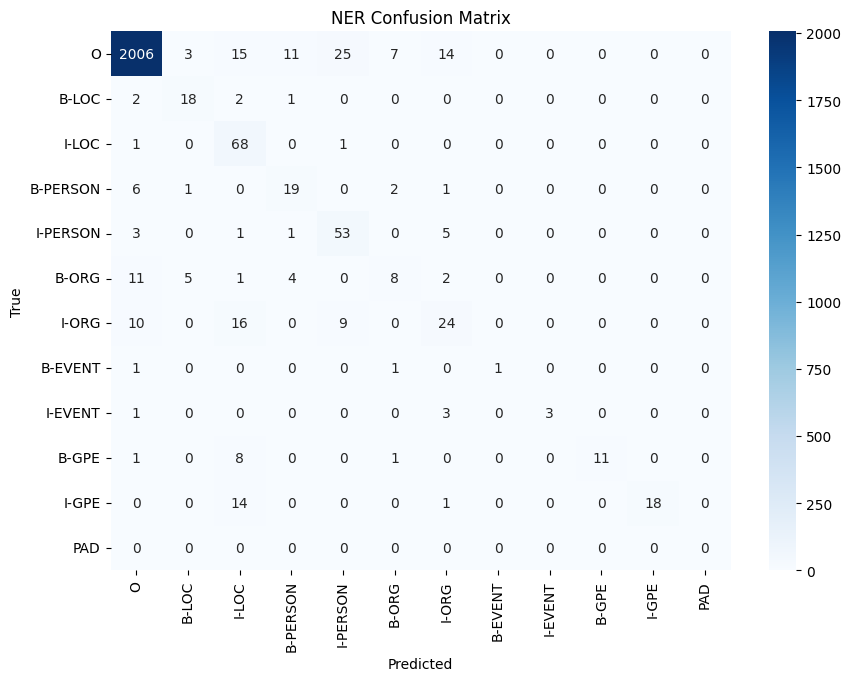

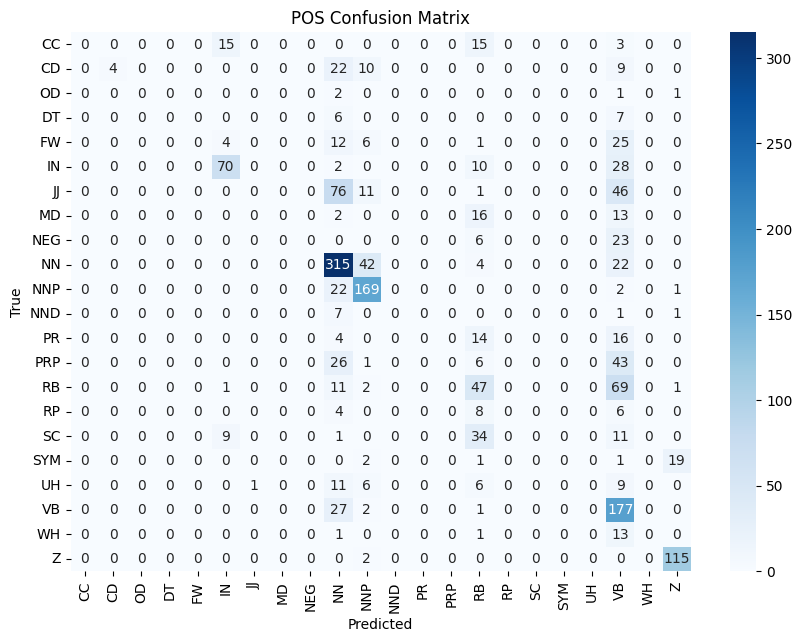

Saving model with highest POS F1 score: 0.18  and NER F1 score: 0.63  from epoch 8 , Validation Loss : 2.4942


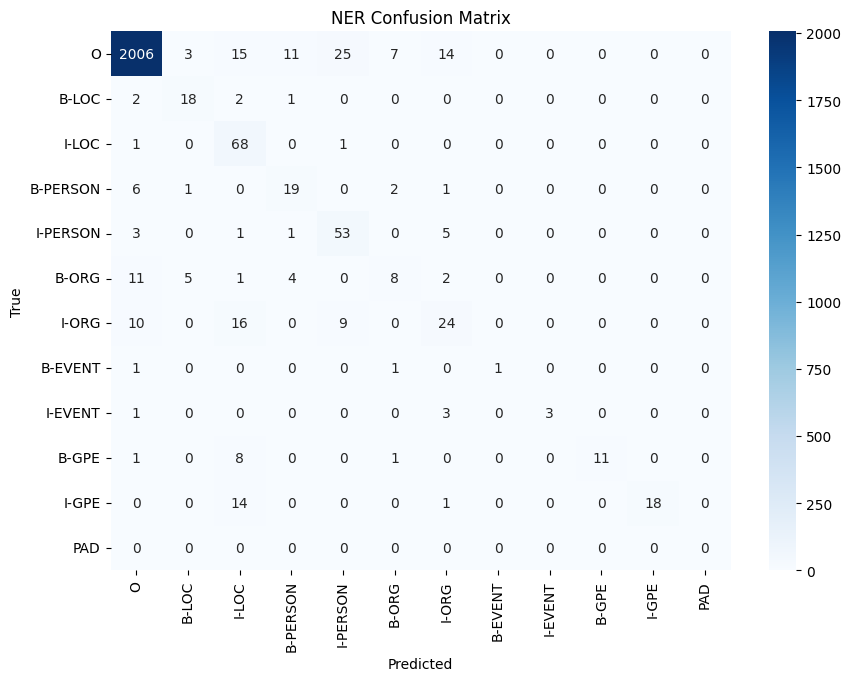

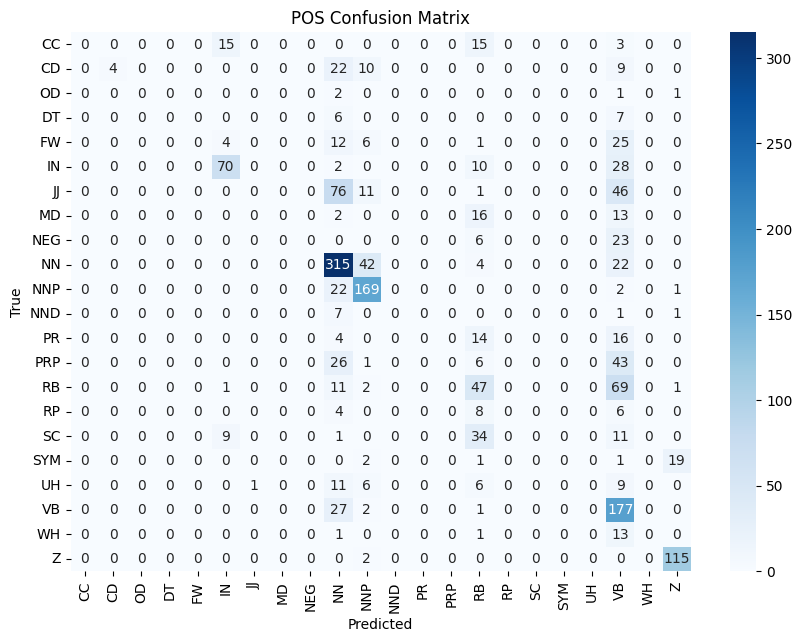

Epoch 9/100
  Train Loss: 2.3257
  Val   Loss: 2.1007
  Val Perplexity: 8.1722
  Train POS Loss: 1.6162
  Val   POS Loss: 1.3978
  Train NER Loss: 2.3648
  Val   NER Loss: 2.3430
              precision    recall  f1-score   support

          CC       0.00      0.00      0.00        33
          CD       1.00      0.53      0.70        45
          DT       0.00      0.00      0.00        13
          FW       0.00      0.00      0.00        48
          IN       0.67      0.83      0.74       110
          JJ       0.74      0.15      0.25       134
          MD       0.00      0.00      0.00        31
         NEG       0.00      0.00      0.00        29
          NN       0.68      0.88      0.77       383
         NND       0.00      0.00      0.00         9
         NNP       0.79      0.82      0.81       194
          OD       0.00      0.00      0.00         4
          PR       1.00      0.06      0.11        34
         PRP       0.96      0.70      0.81        76
          

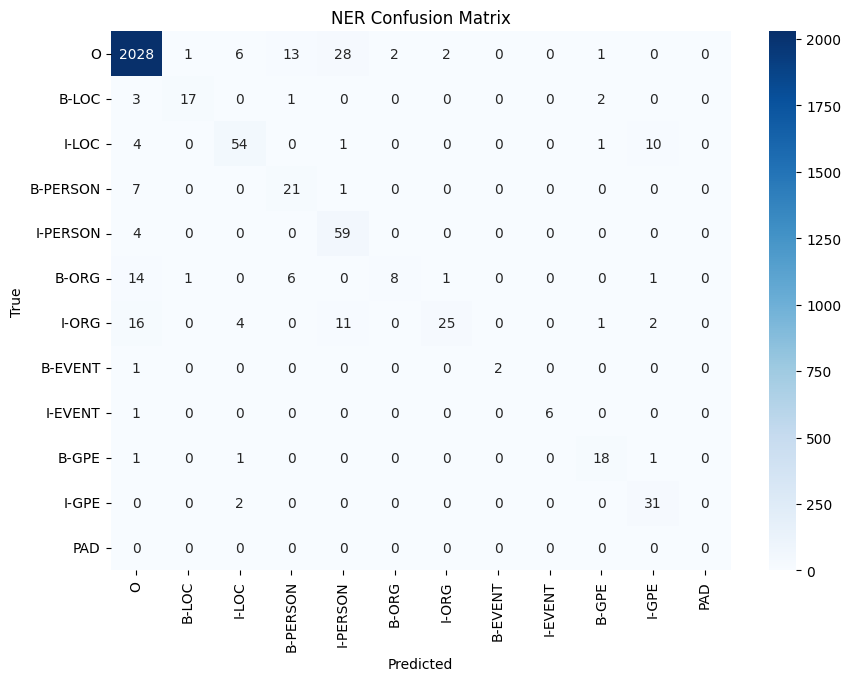

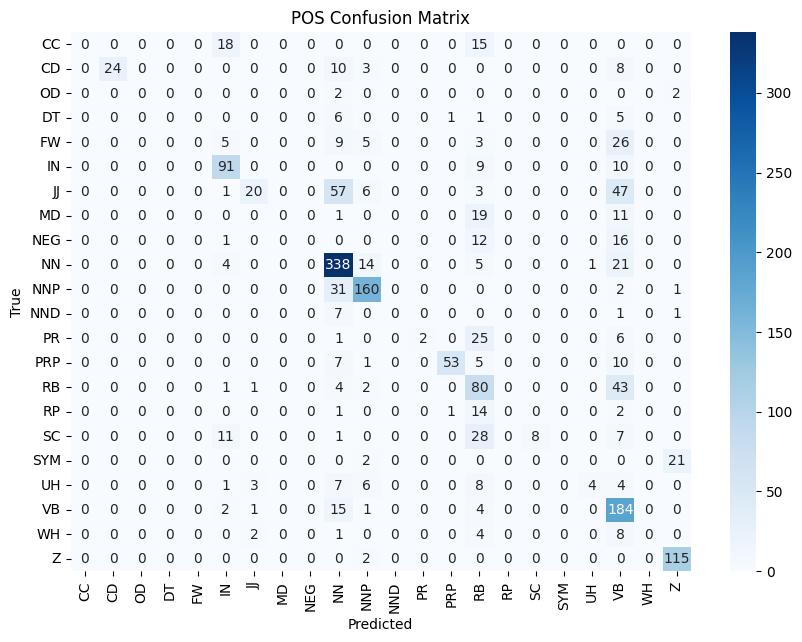

Saving model with highest POS F1 score: 0.299  and NER F1 score: 0.745  from epoch 9 , Validation Loss : 2.1007


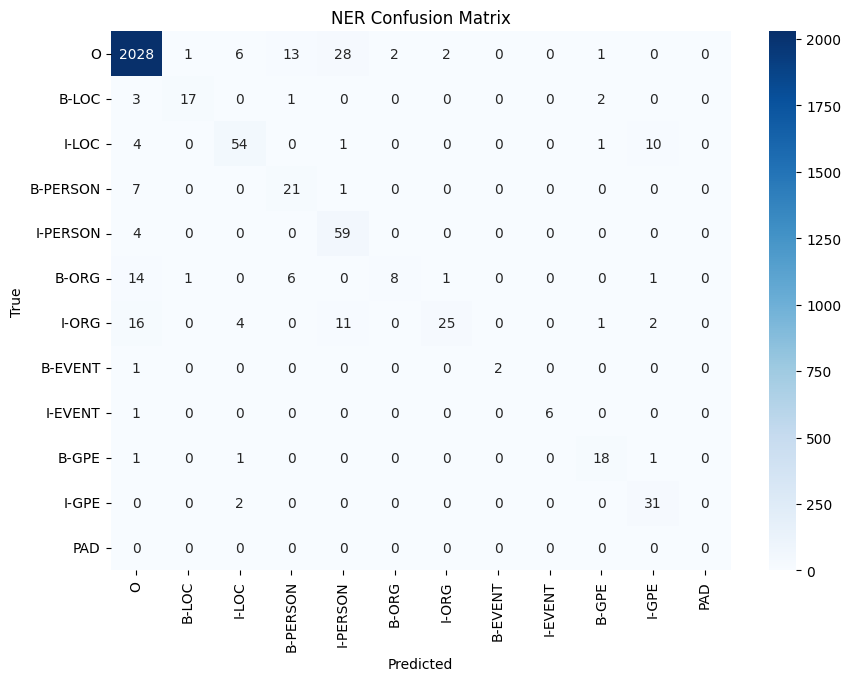

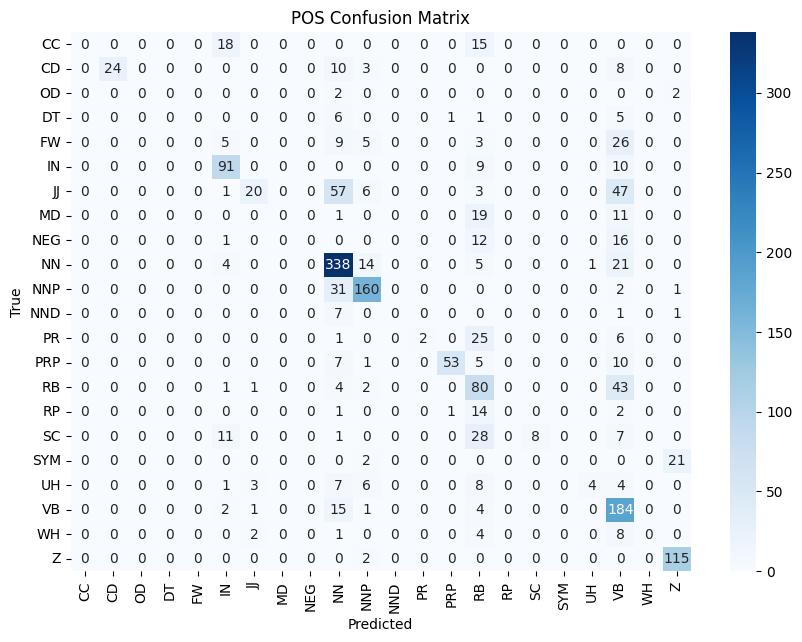

Epoch 10/100
  Train Loss: 1.8302
  Val   Loss: 1.7344
  Val Perplexity: 5.6655
  Train POS Loss: 1.2903
  Val   POS Loss: 1.0533
  Train NER Loss: 1.7996
  Val   NER Loss: 2.2704
              precision    recall  f1-score   support

          CC       1.00      0.12      0.22        33
          CD       0.90      0.84      0.87        45
          DT       0.00      0.00      0.00        13
          FW       0.00      0.00      0.00        48
          IN       0.71      0.91      0.80       110
          JJ       0.72      0.54      0.62       134
          MD       0.00      0.00      0.00        31
         NEG       1.00      0.41      0.59        29
          NN       0.76      0.88      0.81       383
         NND       0.00      0.00      0.00         9
         NNP       0.87      0.77      0.82       194
          OD       0.00      0.00      0.00         4
          PR       1.00      0.68      0.81        34
         PRP       0.86      0.95      0.90        76
         

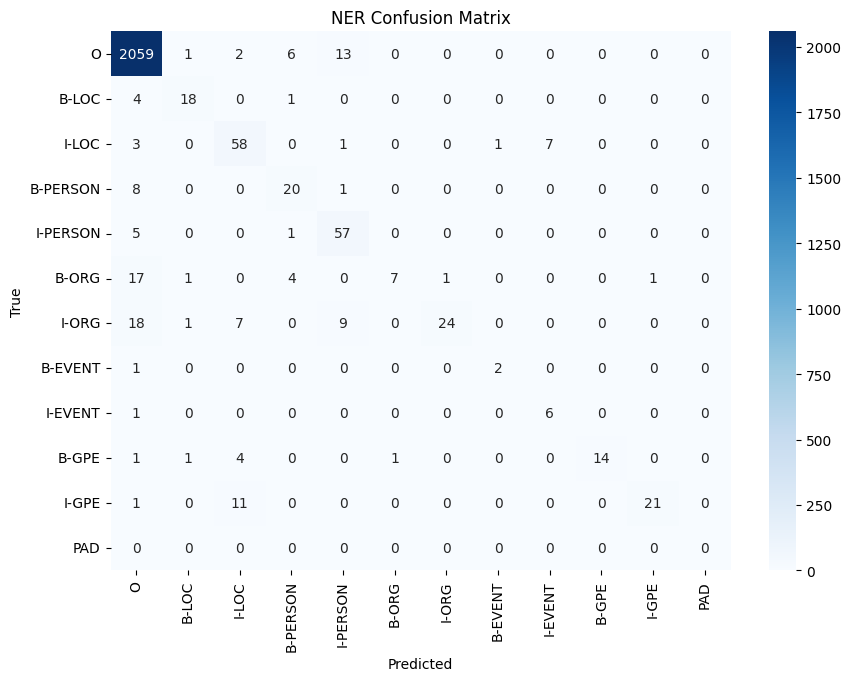

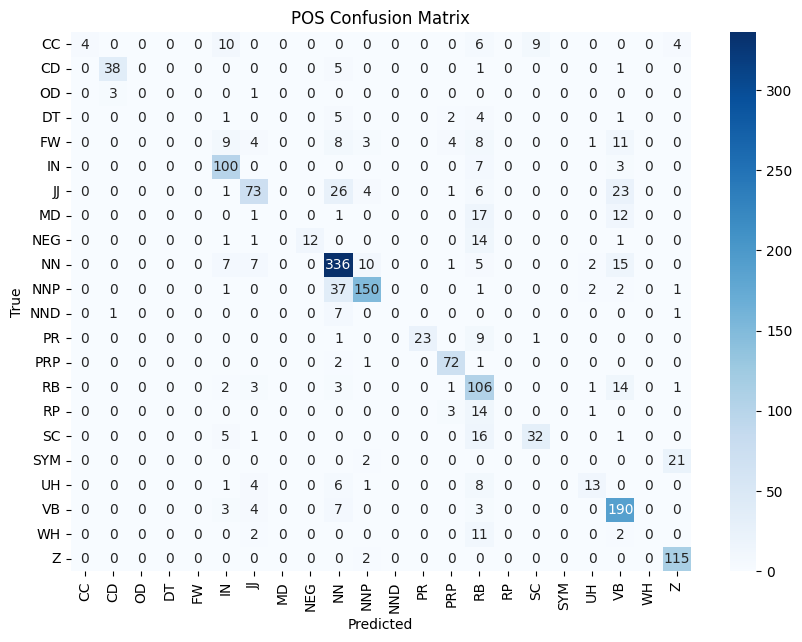

Epoch 11/100
  Train Loss: 1.4529
  Val   Loss: 1.4274
  Val Perplexity: 4.1678
  Train POS Loss: 0.9846
  Val   POS Loss: 0.8099
  Train NER Loss: 1.5609
  Val   NER Loss: 2.0581
              precision    recall  f1-score   support

          CC       1.00      0.55      0.71        33
          CD       0.86      0.84      0.85        45
          DT       0.00      0.00      0.00        13
          FW       0.00      0.00      0.00        48
          IN       0.80      0.94      0.86       110
          JJ       0.73      0.66      0.69       134
          MD       1.00      0.06      0.12        31
         NEG       0.96      0.86      0.91        29
          NN       0.81      0.87      0.84       383
         NND       0.00      0.00      0.00         9
         NNP       0.84      0.86      0.85       194
          OD       0.00      0.00      0.00         4
          PR       1.00      0.88      0.94        34
         PRP       0.87      0.96      0.91        76
         

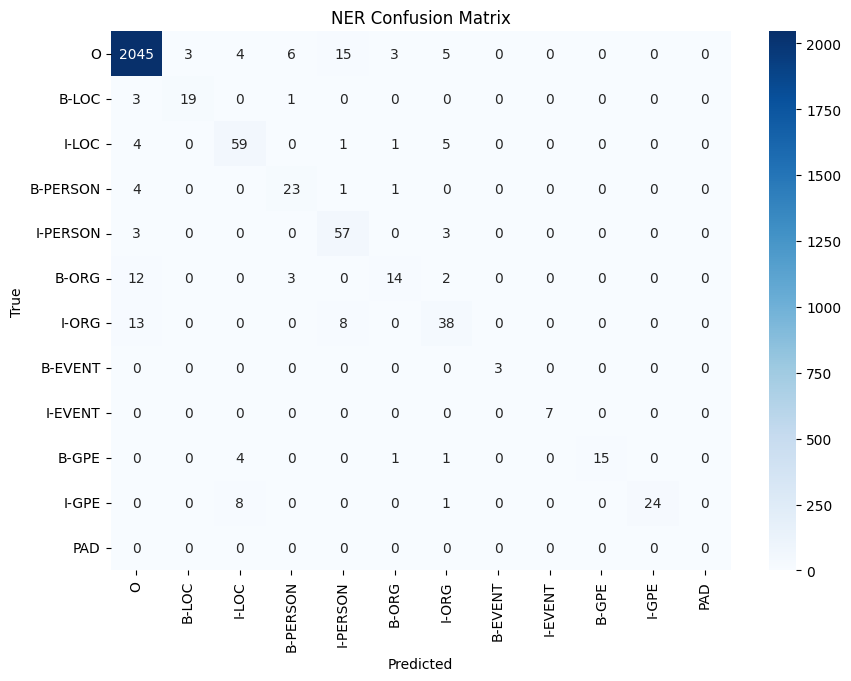

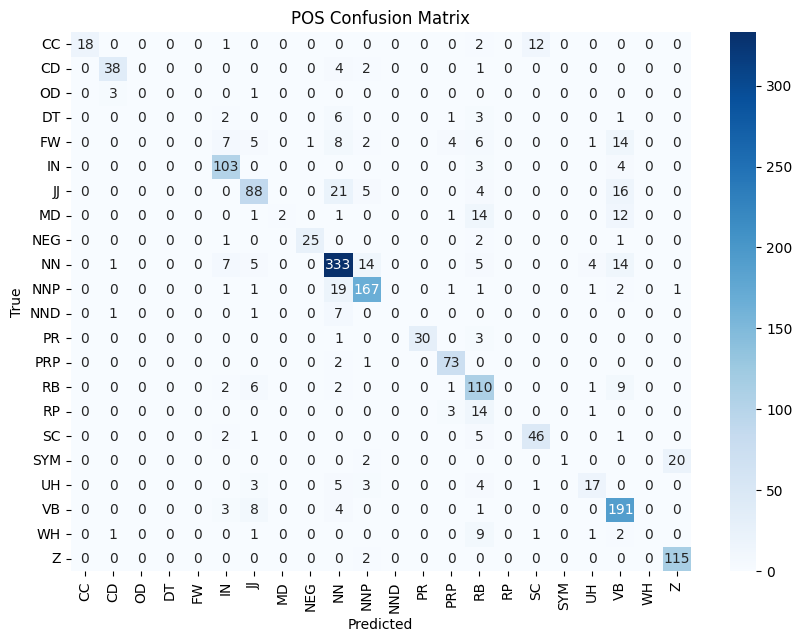

Saving model with highest POS F1 score: 0.525  and NER F1 score: 0.824  from epoch 11 , Validation Loss : 1.4274


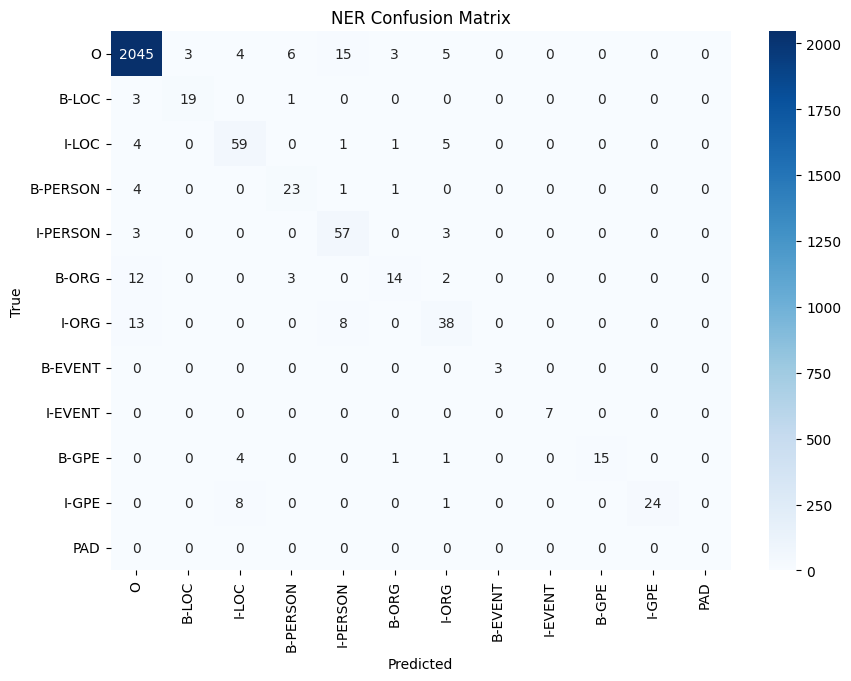

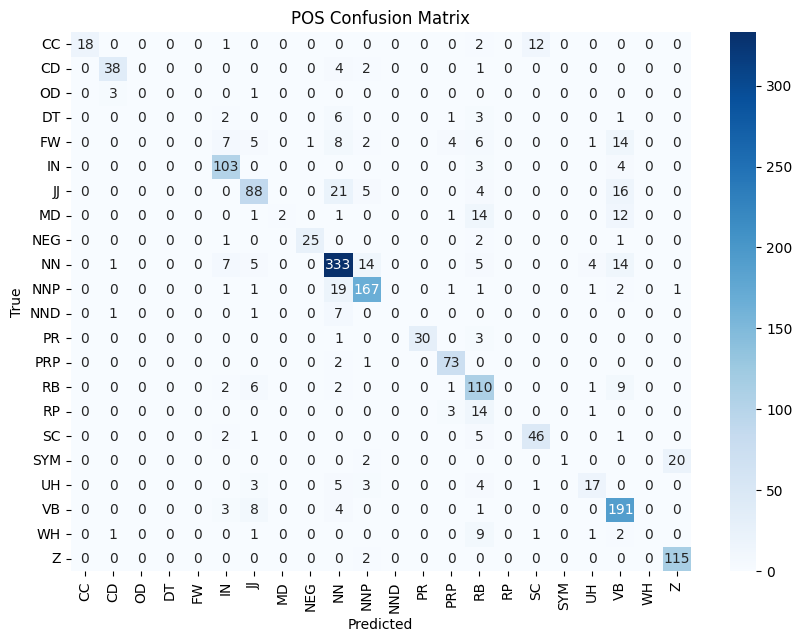

Epoch 12/100
  Train Loss: 1.1228
  Val   Loss: 1.2420
  Val Perplexity: 3.4624
  Train POS Loss: 0.7699
  Val   POS Loss: 0.6665
  Train NER Loss: 1.1765
  Val   NER Loss: 1.9182
              precision    recall  f1-score   support

          CC       0.96      0.73      0.83        33
          CD       0.84      0.93      0.88        45
          DT       0.00      0.00      0.00        13
          FW       0.00      0.00      0.00        48
          IN       0.81      0.97      0.88       110
          JJ       0.79      0.72      0.75       134
          MD       0.96      0.74      0.84        31
         NEG       0.97      0.97      0.97        29
          NN       0.81      0.87      0.84       383
         NND       0.00      0.00      0.00         9
         NNP       0.86      0.87      0.86       194
          OD       0.00      0.00      0.00         4
          PR       0.97      0.91      0.94        34
         PRP       0.89      0.96      0.92        76
         

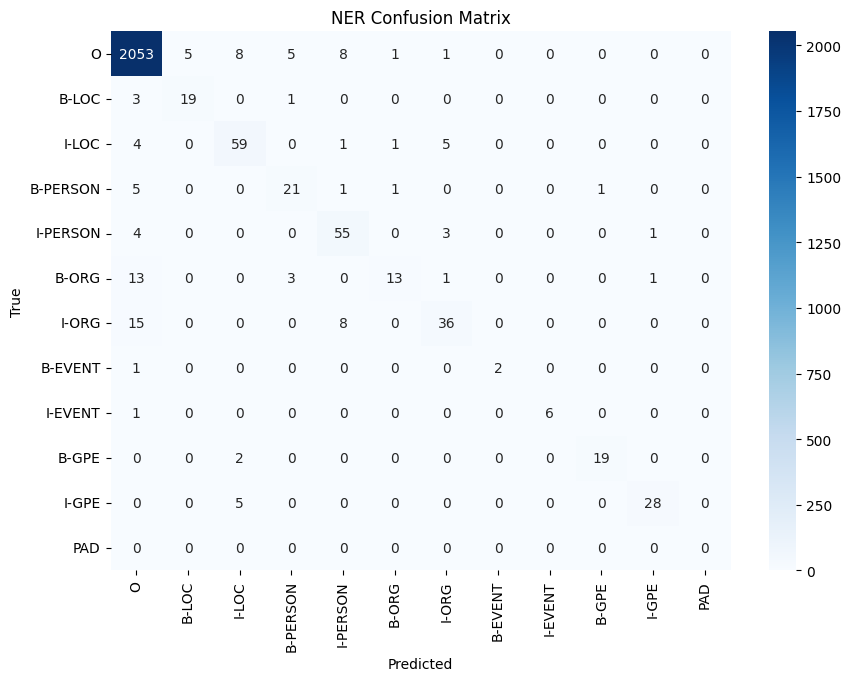

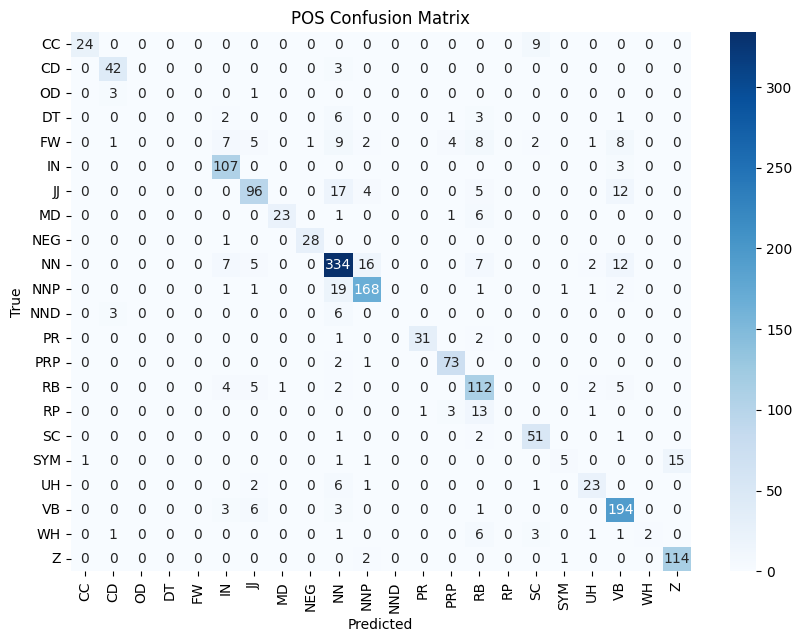

Epoch 13/100
  Train Loss: 0.9209
  Val   Loss: 1.2827
  Val Perplexity: 3.6064
  Train POS Loss: 0.6331
  Val   POS Loss: 0.5985
  Train NER Loss: 0.9595
  Val   NER Loss: 2.2808
              precision    recall  f1-score   support

          CC       0.89      0.97      0.93        33
          CD       0.78      0.96      0.86        45
          DT       0.00      0.00      0.00        13
          FW       0.00      0.00      0.00        48
          IN       0.83      0.96      0.89       110
          JJ       0.74      0.78      0.76       134
          MD       0.93      0.81      0.86        31
         NEG       0.97      0.97      0.97        29
          NN       0.86      0.86      0.86       383
         NND       0.00      0.00      0.00         9
         NNP       0.81      0.90      0.85       194
          OD       0.00      0.00      0.00         4
          PR       0.91      0.94      0.93        34
         PRP       0.89      0.96      0.92        76
         

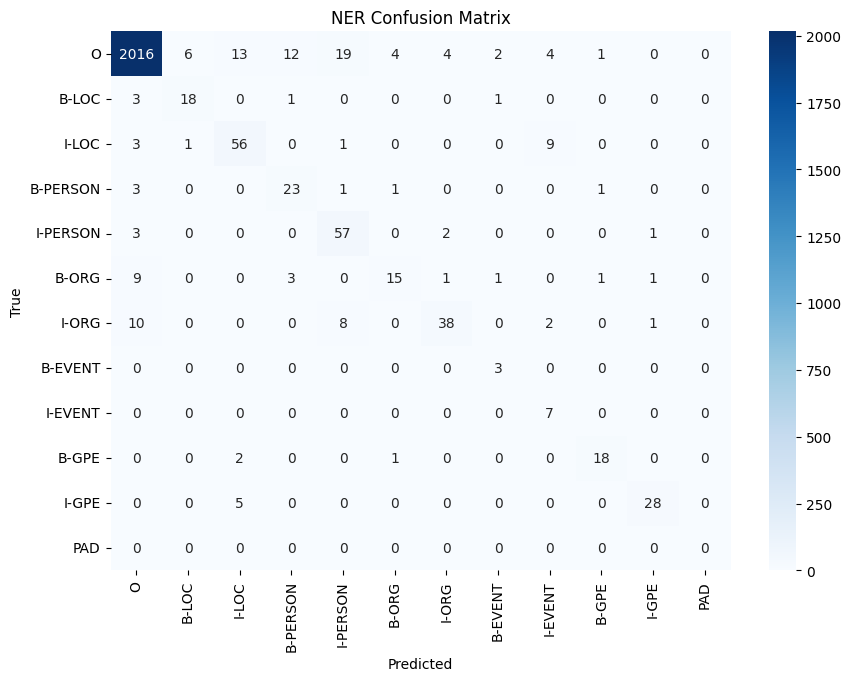

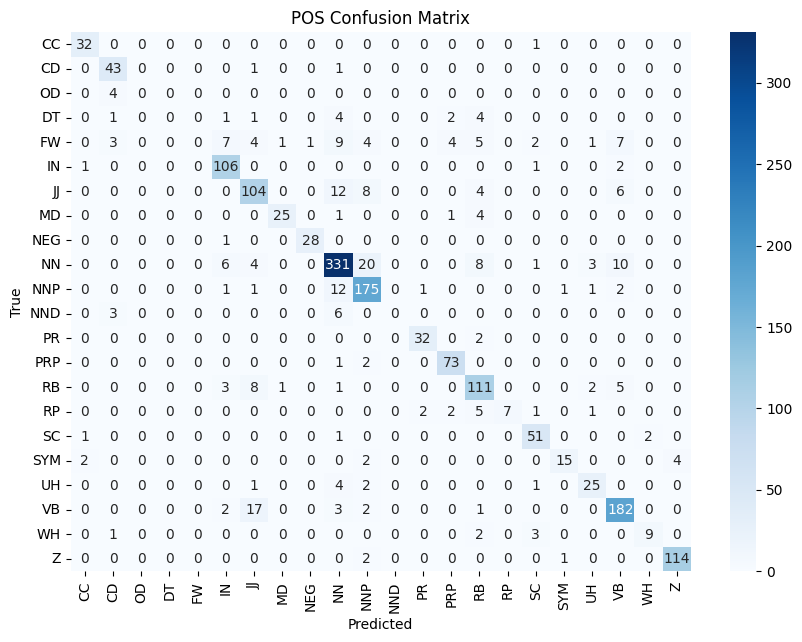

Epoch 14/100
  Train Loss: 0.7902
  Val   Loss: 1.1566
  Val Perplexity: 3.1790
  Train POS Loss: 0.5430
  Val   POS Loss: 0.5312
  Train NER Loss: 0.8240
  Val   NER Loss: 2.0844
              precision    recall  f1-score   support

          CC       0.89      0.97      0.93        33
          CD       0.80      0.98      0.88        45
          DT       0.00      0.00      0.00        13
          FW       1.00      0.02      0.04        48
          IN       0.84      0.96      0.90       110
          JJ       0.81      0.77      0.79       134
          MD       0.88      0.90      0.89        31
         NEG       0.97      0.97      0.97        29
          NN       0.85      0.87      0.86       383
         NND       0.00      0.00      0.00         9
         NNP       0.84      0.88      0.86       194
          OD       0.00      0.00      0.00         4
          PR       0.94      0.94      0.94        34
         PRP       0.90      0.96      0.93        76
         

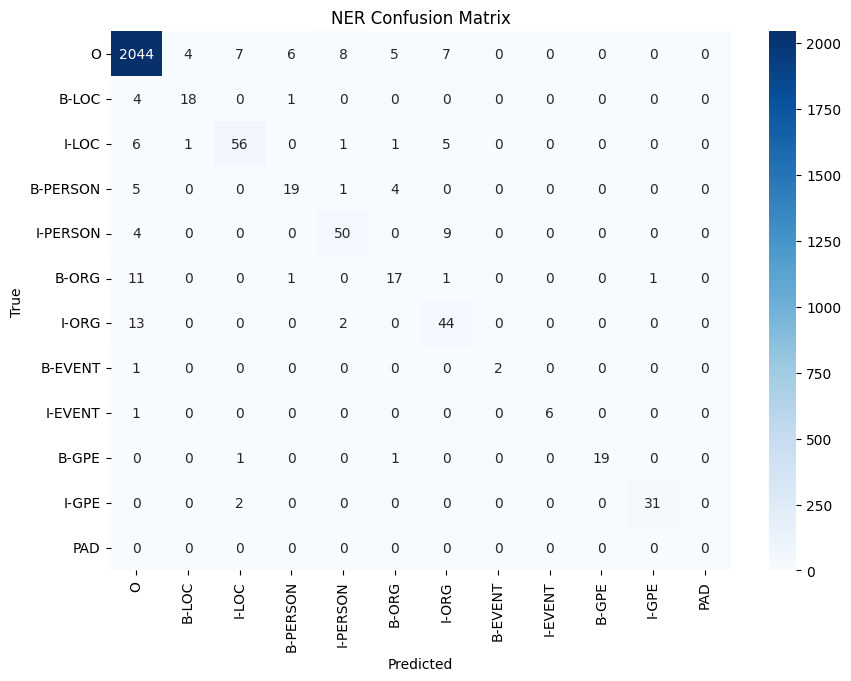

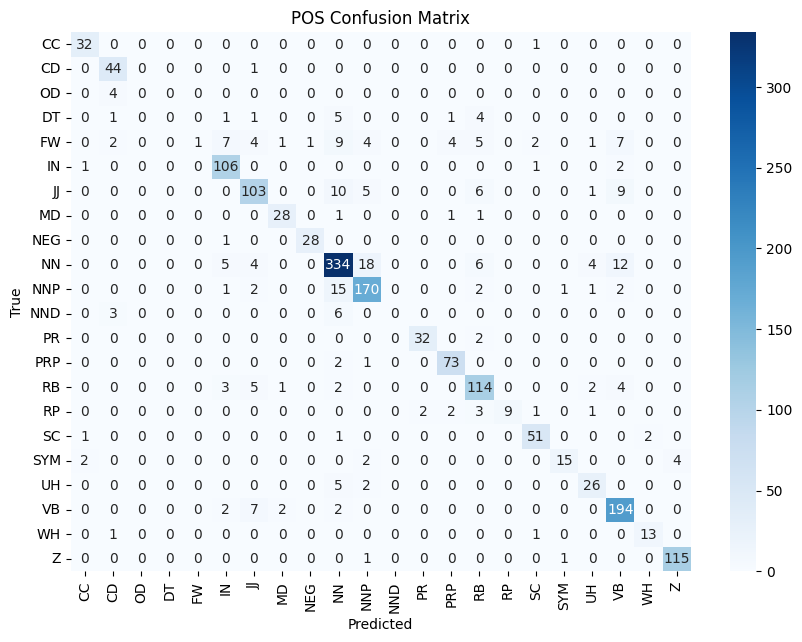

Epoch 15/100
  Train Loss: 0.6680
  Val   Loss: 1.0909
  Val Perplexity: 2.9769
  Train POS Loss: 0.4736
  Val   POS Loss: 0.4917
  Train NER Loss: 0.6481
  Val   NER Loss: 1.9974
              precision    recall  f1-score   support

          CC       0.91      0.97      0.94        33
          CD       0.81      0.98      0.89        45
          DT       0.00      0.00      0.00        13
          FW       1.00      0.04      0.08        48
          IN       0.84      0.98      0.91       110
          JJ       0.81      0.78      0.80       134
          MD       0.90      0.90      0.90        31
         NEG       0.97      0.97      0.97        29
          NN       0.85      0.89      0.87       383
         NND       0.00      0.00      0.00         9
         NNP       0.88      0.85      0.86       194
          OD       0.00      0.00      0.00         4
          PR       0.94      0.94      0.94        34
         PRP       0.90      0.97      0.94        76
         

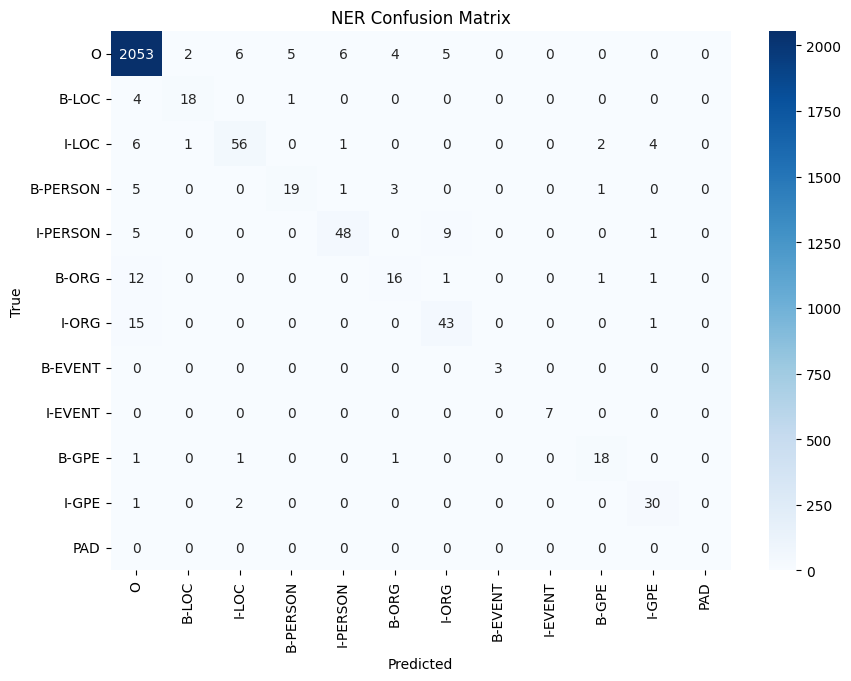

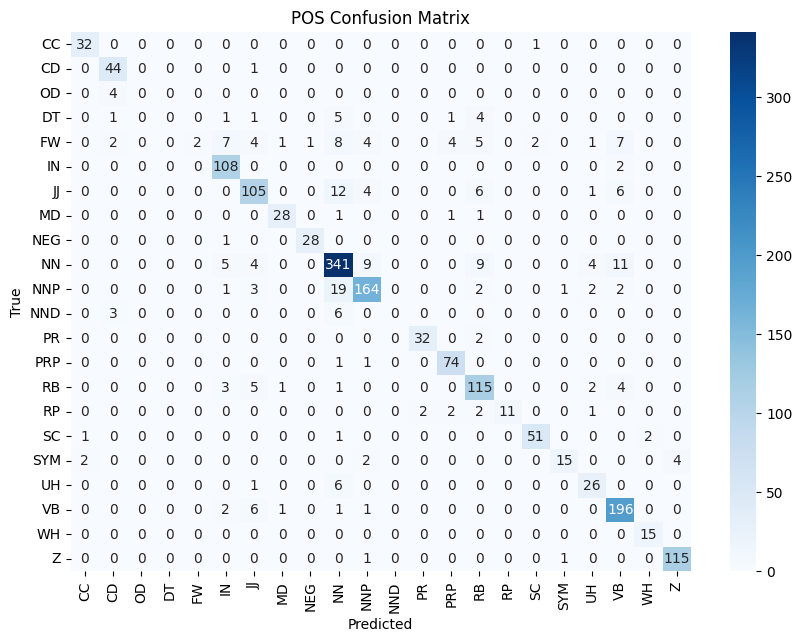

Saving model with highest POS F1 score: 0.724  and NER F1 score: 0.832  from epoch 15 , Validation Loss : 1.0909


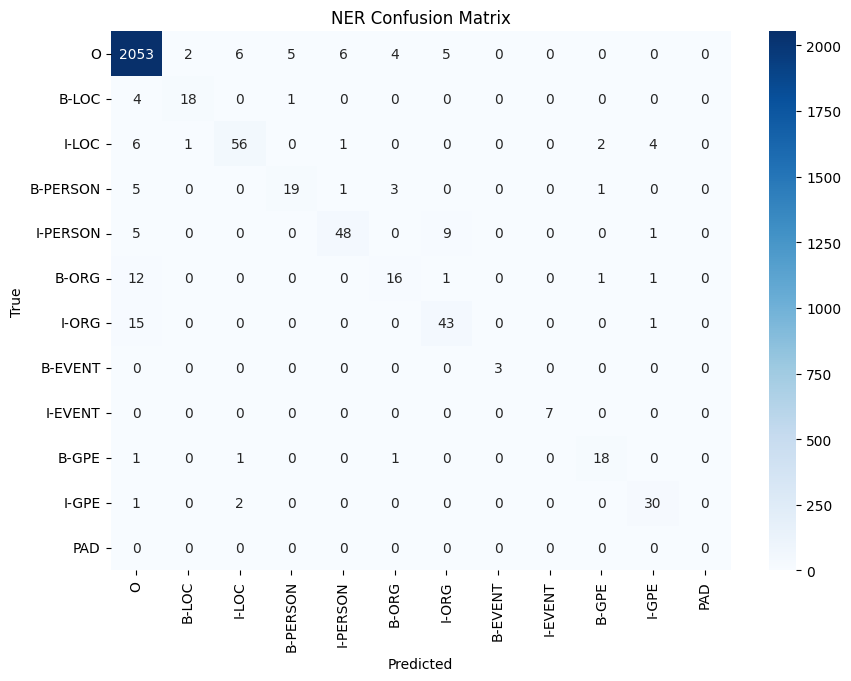

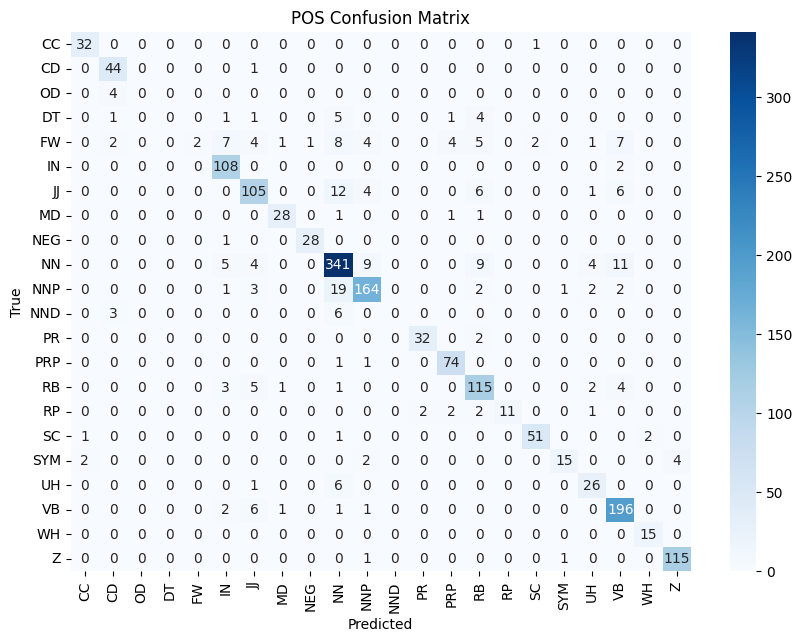

Epoch 16/100
  Train Loss: 0.6186
  Val   Loss: 1.0479
  Val Perplexity: 2.8516
  Train POS Loss: 0.4261
  Val   POS Loss: 0.4692
  Train NER Loss: 0.6417
  Val   NER Loss: 1.9290
              precision    recall  f1-score   support

          CC       0.92      1.00      0.96        33
          CD       0.81      0.98      0.89        45
          DT       1.00      0.15      0.27        13
          FW       1.00      0.04      0.08        48
          IN       0.84      0.98      0.91       110
          JJ       0.81      0.78      0.79       134
          MD       0.90      0.90      0.90        31
         NEG       0.97      0.97      0.97        29
          NN       0.84      0.89      0.87       383
         NND       0.00      0.00      0.00         9
         NNP       0.84      0.87      0.85       194
          OD       0.00      0.00      0.00         4
          PR       0.94      0.94      0.94        34
         PRP       0.90      0.96      0.93        76
         

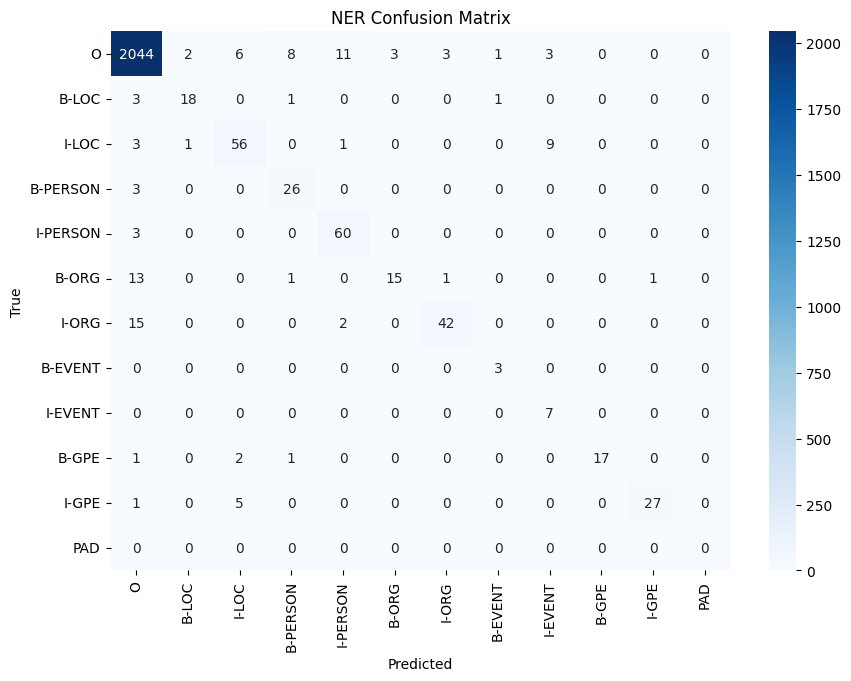

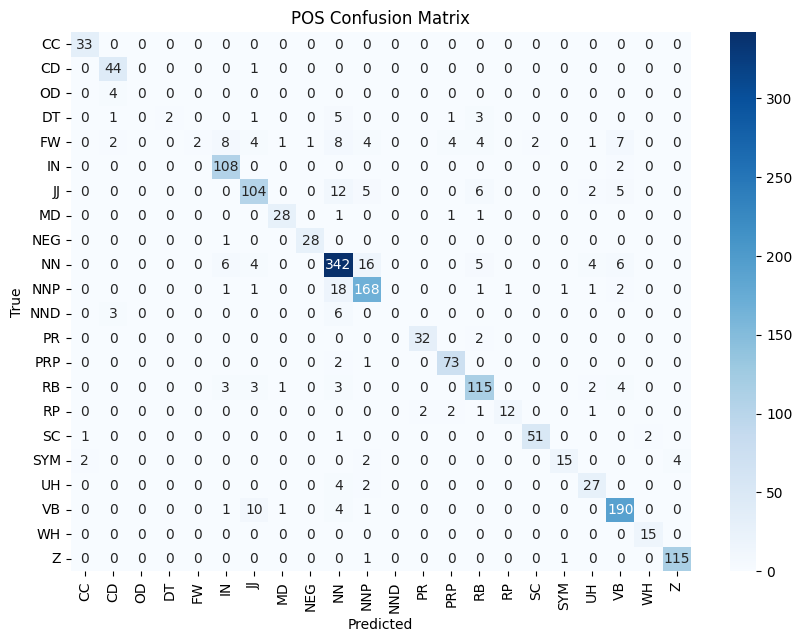

Epoch 17/100
  Train Loss: 0.5383
  Val   Loss: 1.1126
  Val Perplexity: 3.0423
  Train POS Loss: 0.3875
  Val   POS Loss: 0.4568
  Train NER Loss: 0.5026
  Val   NER Loss: 2.1860
              precision    recall  f1-score   support

          CC       0.94      1.00      0.97        33
          CD       0.81      0.98      0.89        45
          DT       1.00      0.62      0.76        13
          FW       1.00      0.06      0.12        48
          IN       0.85      0.98      0.91       110
          JJ       0.78      0.81      0.80       134
          MD       0.88      0.90      0.89        31
         NEG       0.97      0.97      0.97        29
          NN       0.89      0.88      0.88       383
         NND       0.00      0.00      0.00         9
         NNP       0.82      0.90      0.86       194
          OD       0.00      0.00      0.00         4
          PR       0.91      0.94      0.93        34
         PRP       0.91      0.97      0.94        76
         

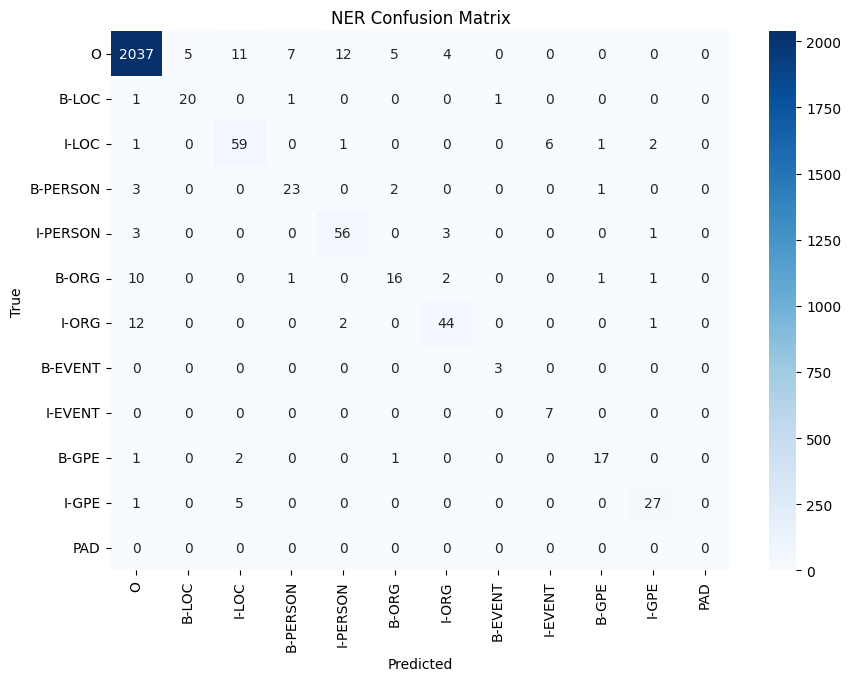

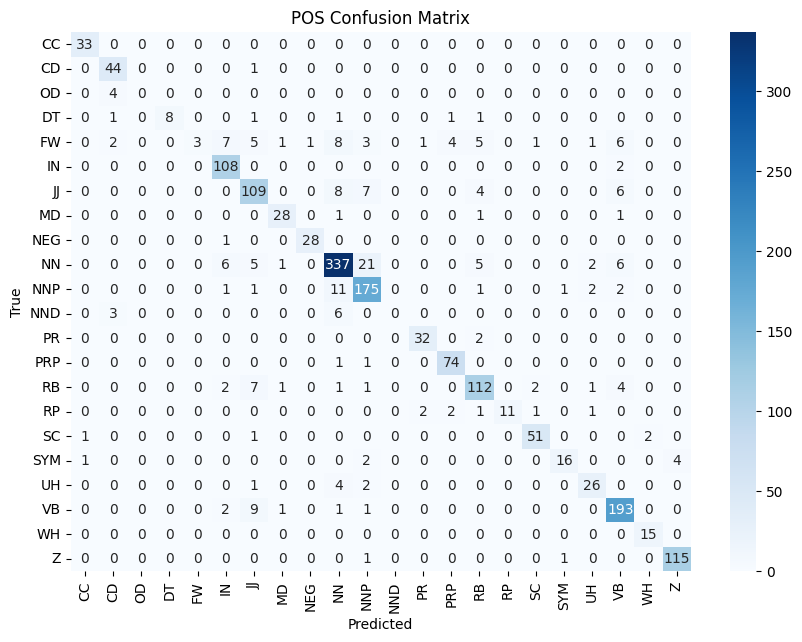

Epoch 18/100
  Train Loss: 0.4842
  Val   Loss: 1.2180
  Val Perplexity: 3.3804
  Train POS Loss: 0.3474
  Val   POS Loss: 0.4571
  Train NER Loss: 0.4560
  Val   NER Loss: 2.5363
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.80      0.98      0.88        45
          DT       1.00      0.54      0.70        13
          FW       1.00      0.08      0.15        48
          IN       0.82      0.98      0.90       110
          JJ       0.83      0.80      0.81       134
          MD       0.85      0.90      0.88        31
         NEG       0.97      0.97      0.97        29
          NN       0.90      0.87      0.89       383
         NND       0.00      0.00      0.00         9
         NNP       0.82      0.92      0.87       194
          OD       0.00      0.00      0.00         4
          PR       0.89      0.94      0.91        34
         PRP       0.91      0.97      0.94        76
         

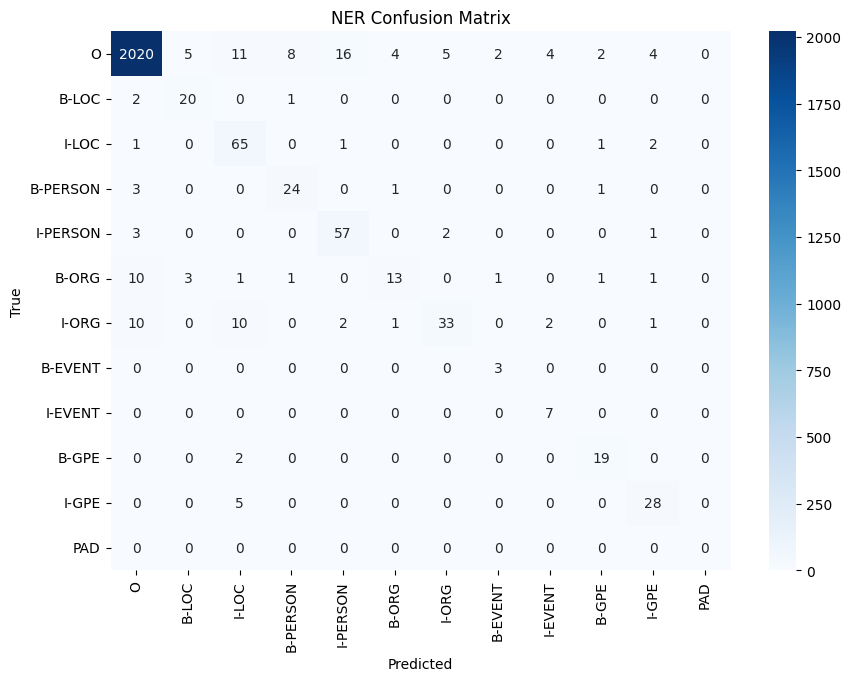

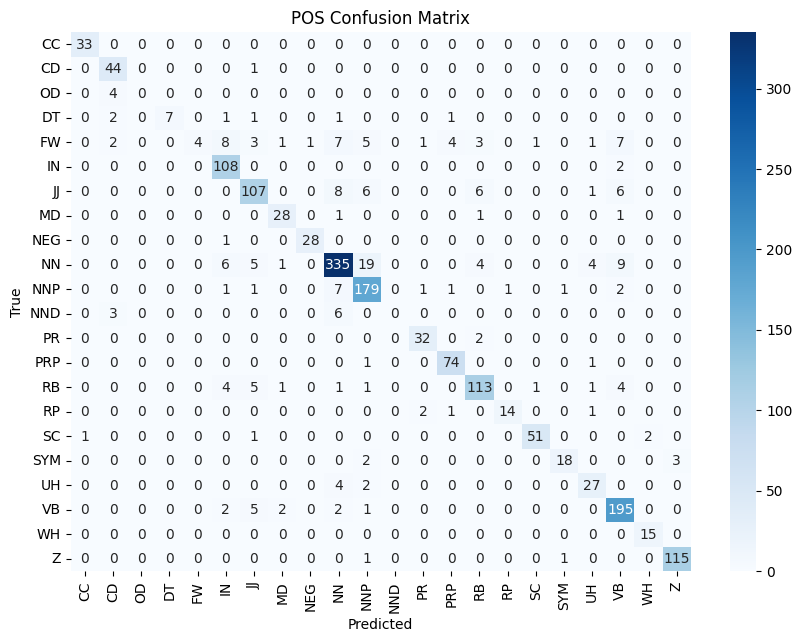

Epoch 19/100
  Train Loss: 0.4343
  Val   Loss: 1.0932
  Val Perplexity: 2.9837
  Train POS Loss: 0.3171
  Val   POS Loss: 0.4357
  Train NER Loss: 0.3906
  Val   NER Loss: 2.1915
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.81      0.98      0.89        45
          DT       1.00      0.62      0.76        13
          FW       1.00      0.08      0.15        48
          IN       0.86      0.97      0.91       110
          JJ       0.77      0.84      0.80       134
          MD       0.88      0.90      0.89        31
         NEG       0.97      0.97      0.97        29
          NN       0.87      0.90      0.89       383
         NND       0.00      0.00      0.00         9
         NNP       0.87      0.84      0.85       194
          OD       0.00      0.00      0.00         4
          PR       0.94      0.94      0.94        34
         PRP       0.90      0.97      0.94        76
         

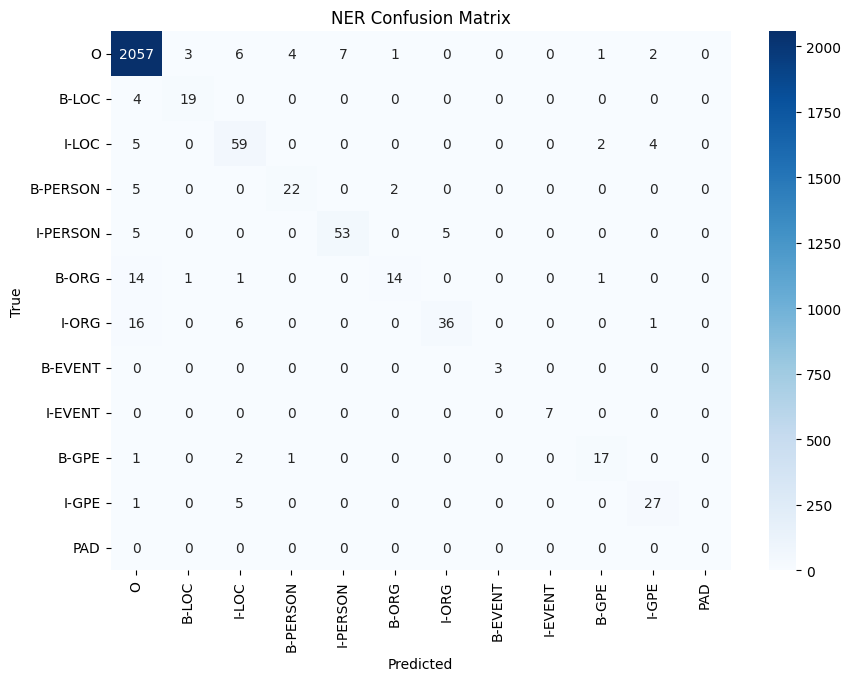

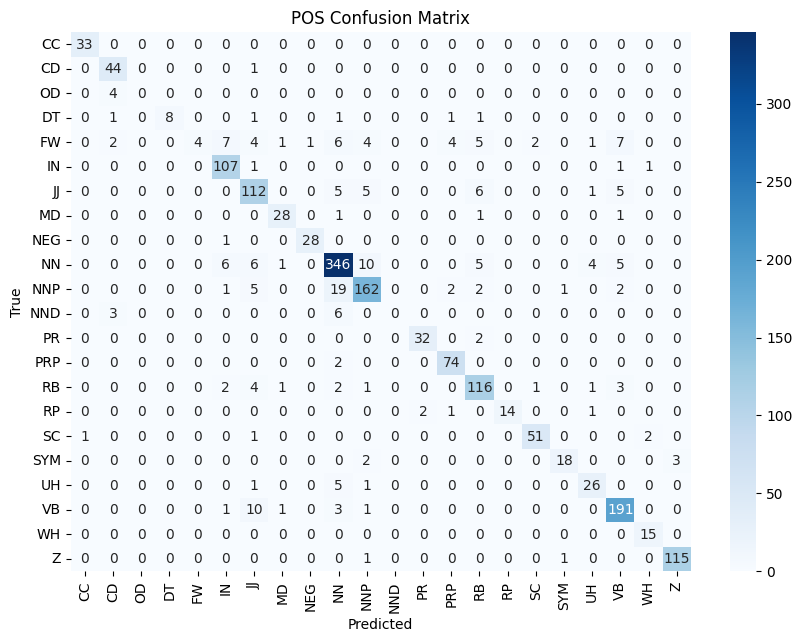

Saving model with highest POS F1 score: 0.775  and NER F1 score: 0.833  from epoch 19 , Validation Loss : 1.0932


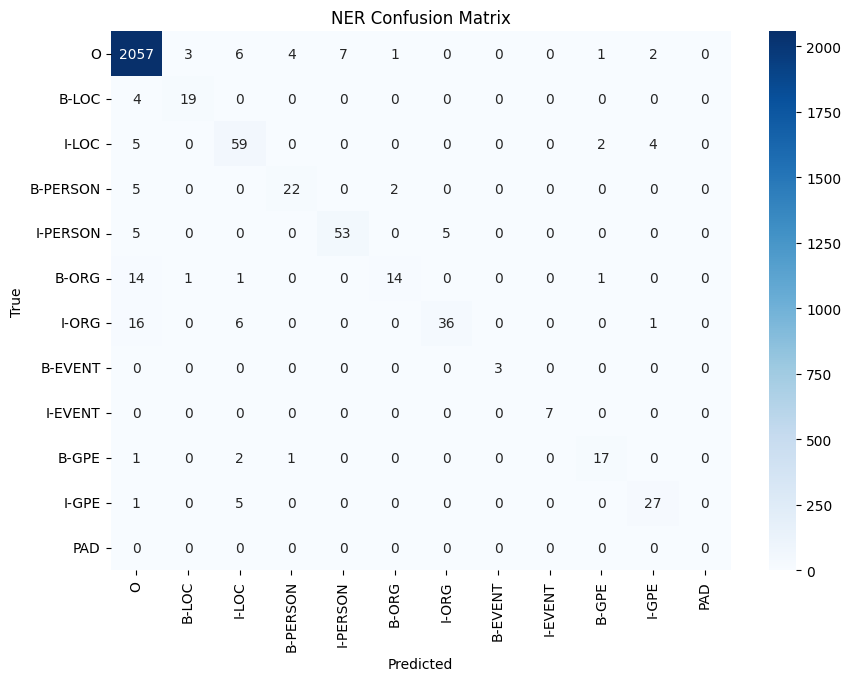

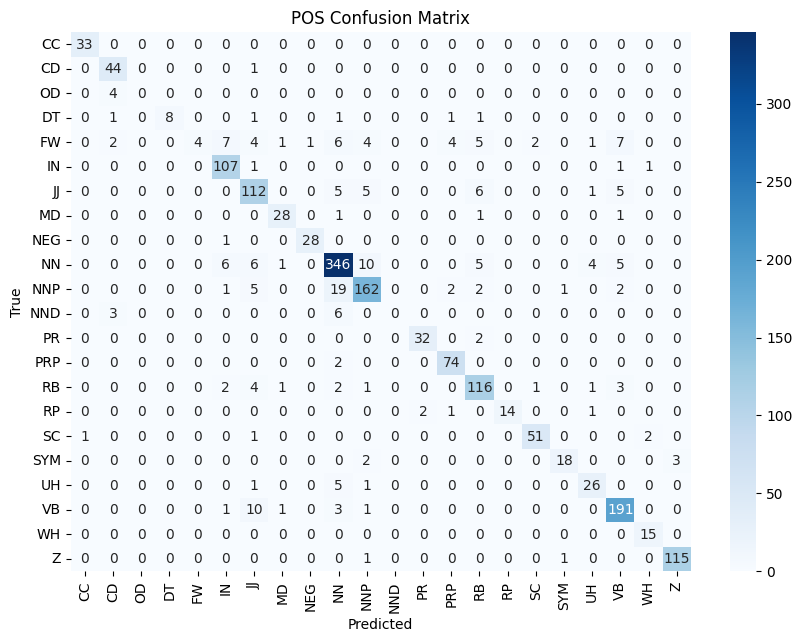

Epoch 20/100
  Train Loss: 0.3882
  Val   Loss: 1.0972
  Val Perplexity: 2.9958
  Train POS Loss: 0.2940
  Val   POS Loss: 0.4299
  Train NER Loss: 0.3138
  Val   NER Loss: 2.2244
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.80      0.98      0.88        45
          DT       1.00      0.62      0.76        13
          FW       1.00      0.10      0.19        48
          IN       0.85      0.97      0.91       110
          JJ       0.80      0.82      0.81       134
          MD       0.82      0.90      0.86        31
         NEG       0.97      0.97      0.97        29
          NN       0.91      0.87      0.89       383
         NND       0.00      0.00      0.00         9
         NNP       0.82      0.91      0.87       194
          OD       0.00      0.00      0.00         4
          PR       0.94      0.94      0.94        34
         PRP       0.91      0.97      0.94        76
         

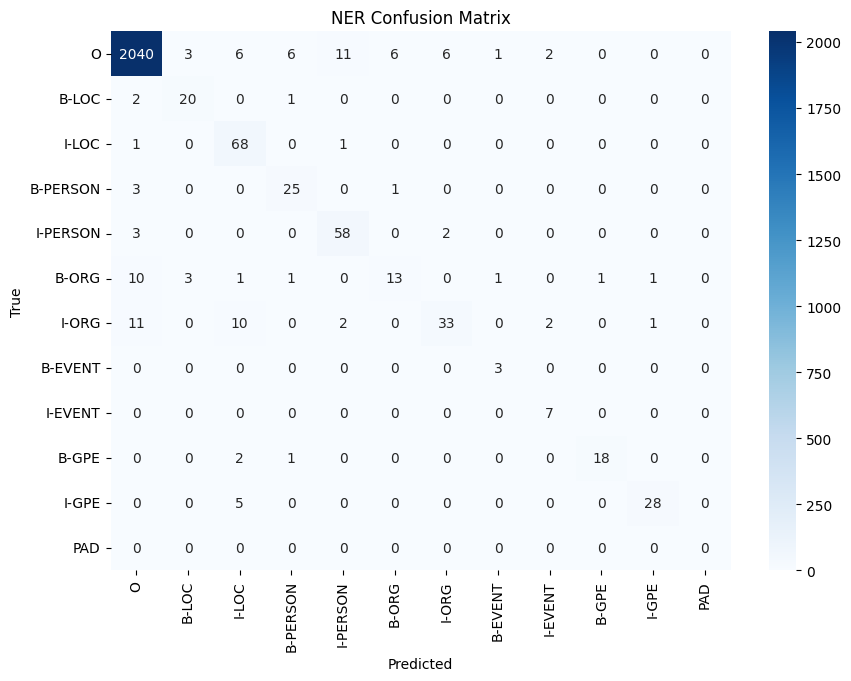

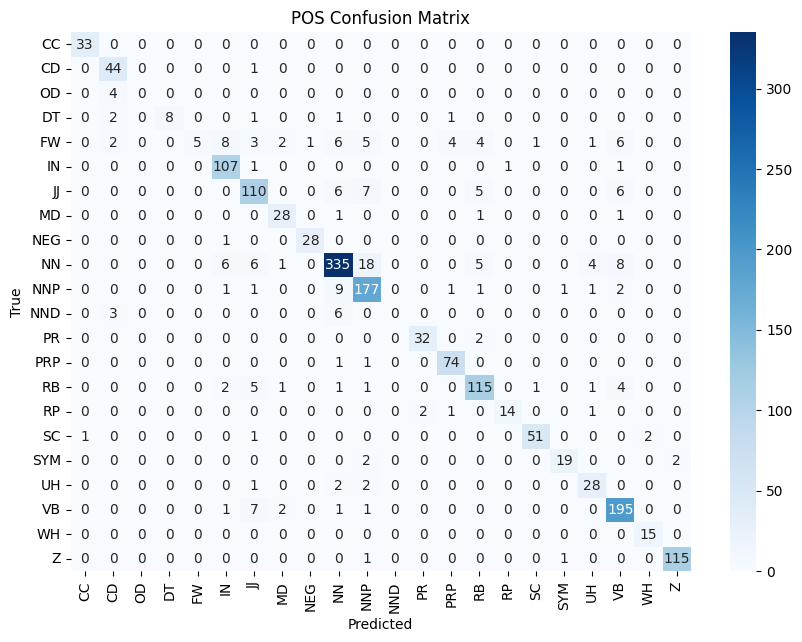

Epoch 21/100
  Train Loss: 0.3408
  Val   Loss: 1.1391
  Val Perplexity: 3.1239
  Train POS Loss: 0.2628
  Val   POS Loss: 0.4270
  Train NER Loss: 0.2601
  Val   NER Loss: 2.3737
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.81      0.98      0.89        45
          DT       1.00      0.62      0.76        13
          FW       1.00      0.17      0.29        48
          IN       0.84      0.97      0.90       110
          JJ       0.81      0.82      0.81       134
          MD       0.85      0.90      0.88        31
         NEG       0.97      0.97      0.97        29
          NN       0.90      0.87      0.89       383
         NND       0.00      0.00      0.00         9
         NNP       0.85      0.88      0.86       194
          OD       0.00      0.00      0.00         4
          PR       0.94      0.94      0.94        34
         PRP       0.90      0.97      0.94        76
         

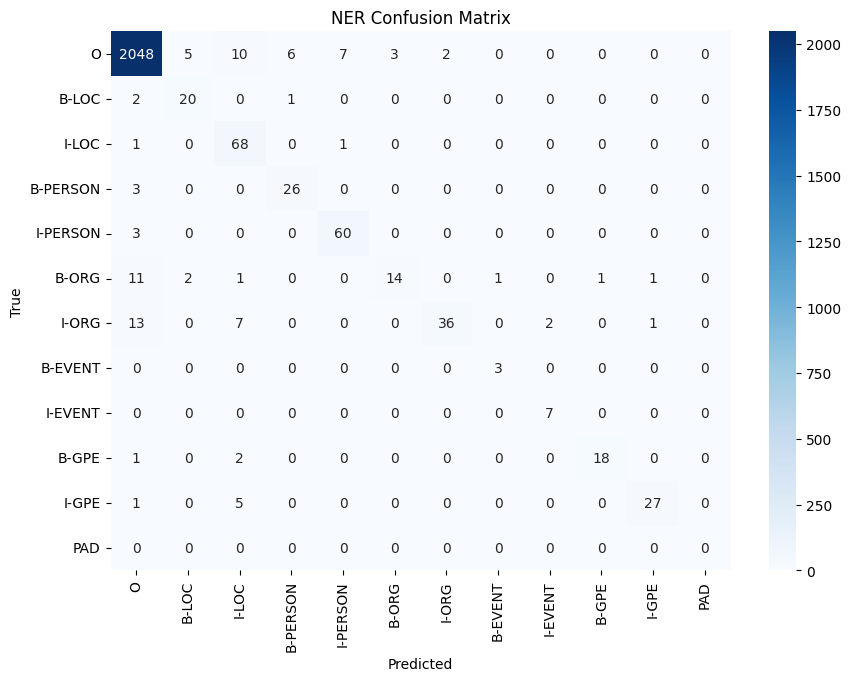

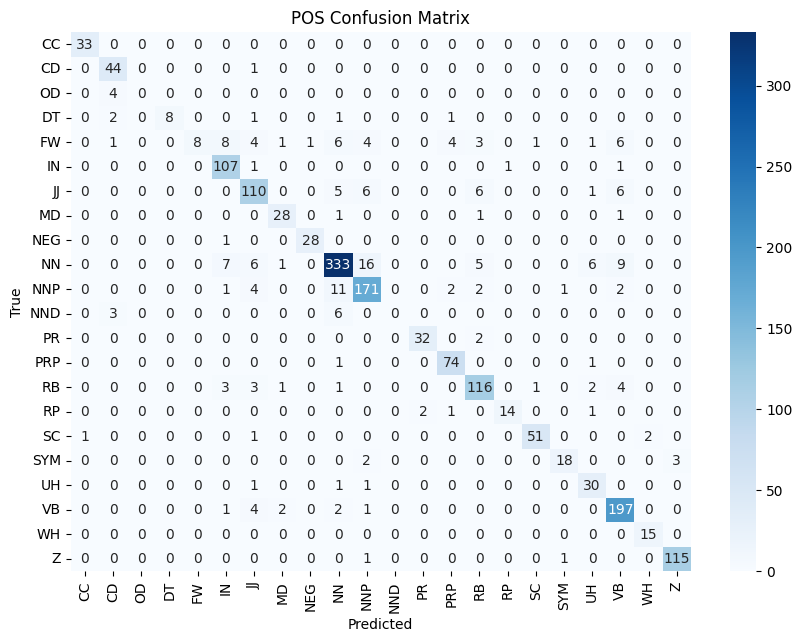

Saving model with highest POS F1 score: 0.783  and NER F1 score: 0.836  from epoch 21 , Validation Loss : 1.1391


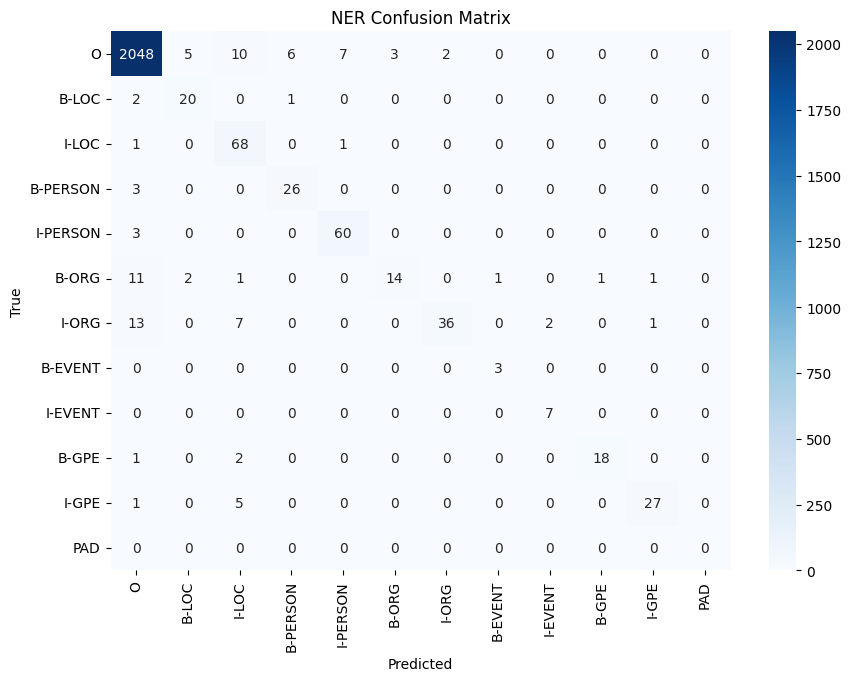

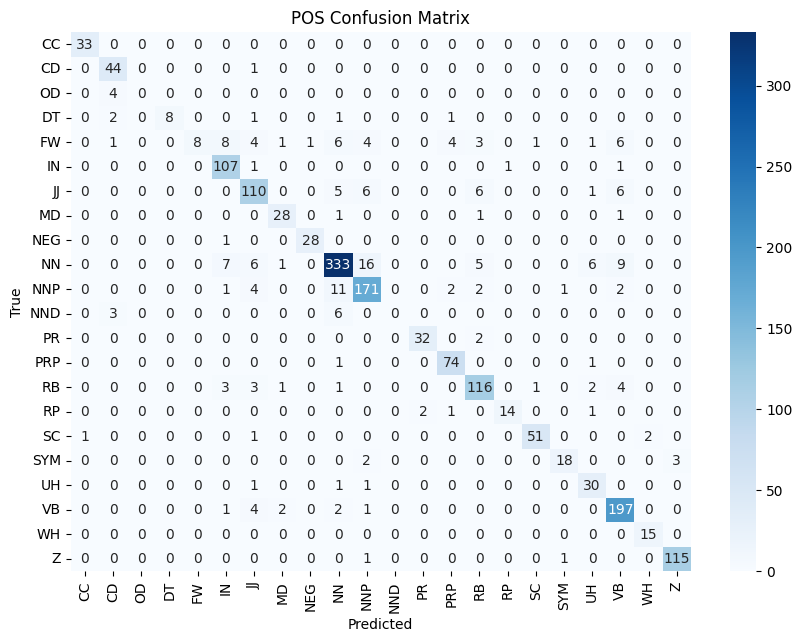

Epoch 22/100
  Train Loss: 0.3219
  Val   Loss: 1.3105
  Val Perplexity: 3.7080
  Train POS Loss: 0.2484
  Val   POS Loss: 0.4503
  Train NER Loss: 0.2449
  Val   NER Loss: 2.8674
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.83      0.98      0.90        45
          DT       1.00      0.62      0.76        13
          FW       1.00      0.23      0.37        48
          IN       0.84      0.97      0.90       110
          JJ       0.81      0.84      0.83       134
          MD       0.82      0.90      0.86        31
         NEG       0.97      0.97      0.97        29
          NN       0.88      0.87      0.88       383
         NND       0.00      0.00      0.00         9
         NNP       0.91      0.77      0.84       194
          OD       0.00      0.00      0.00         4
          PR       0.94      0.94      0.94        34
         PRP       0.91      0.99      0.95        76
         

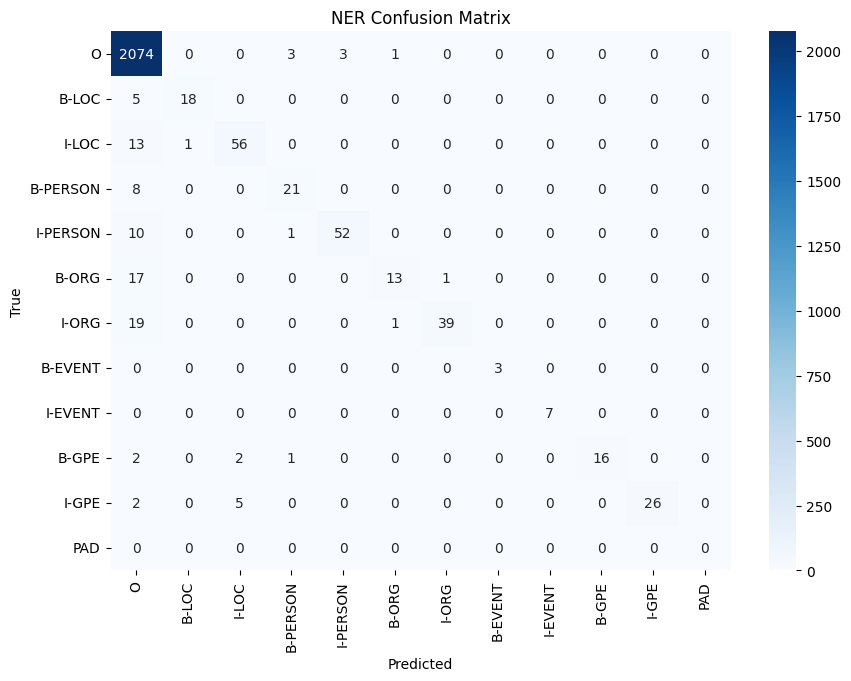

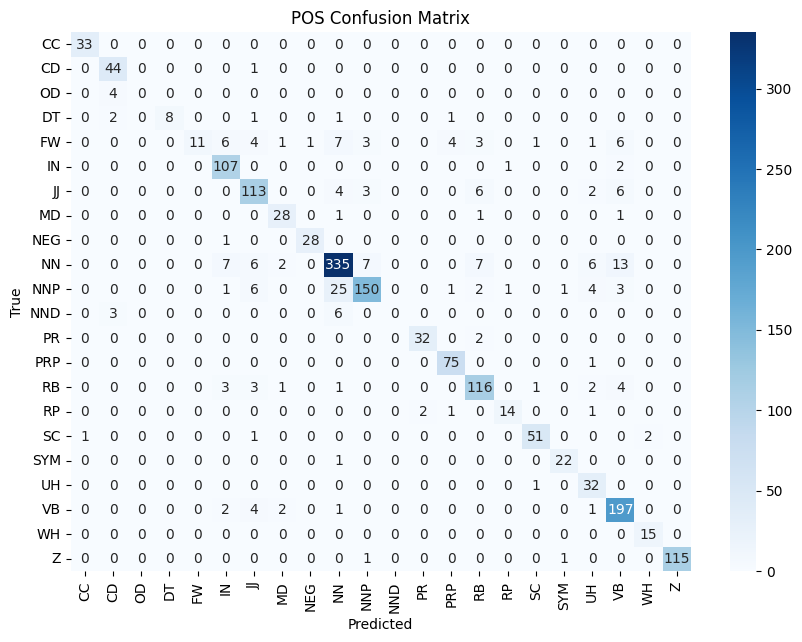

Saving model with highest POS F1 score: 0.788  and NER F1 score: 0.857  from epoch 22 , Validation Loss : 1.3105


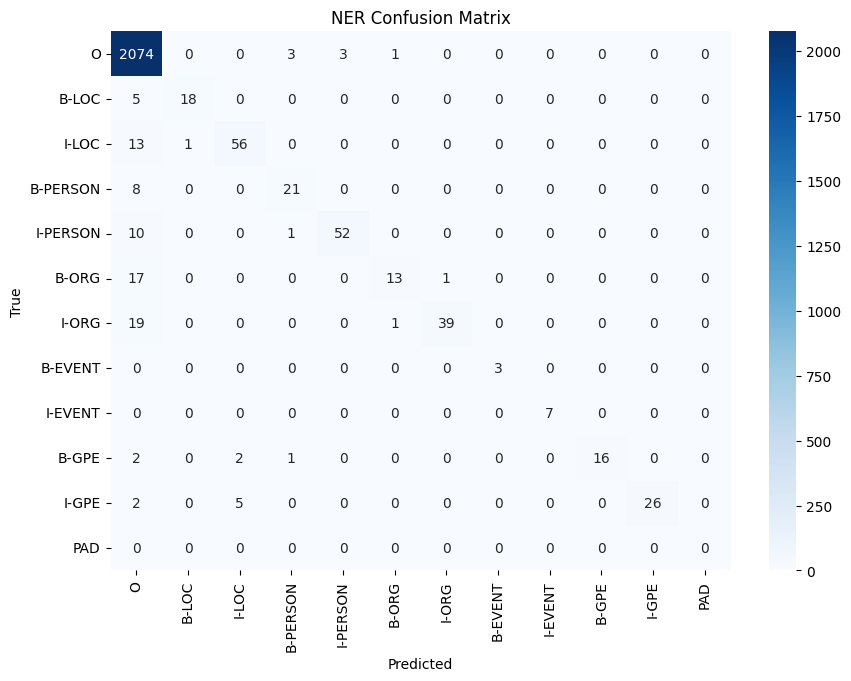

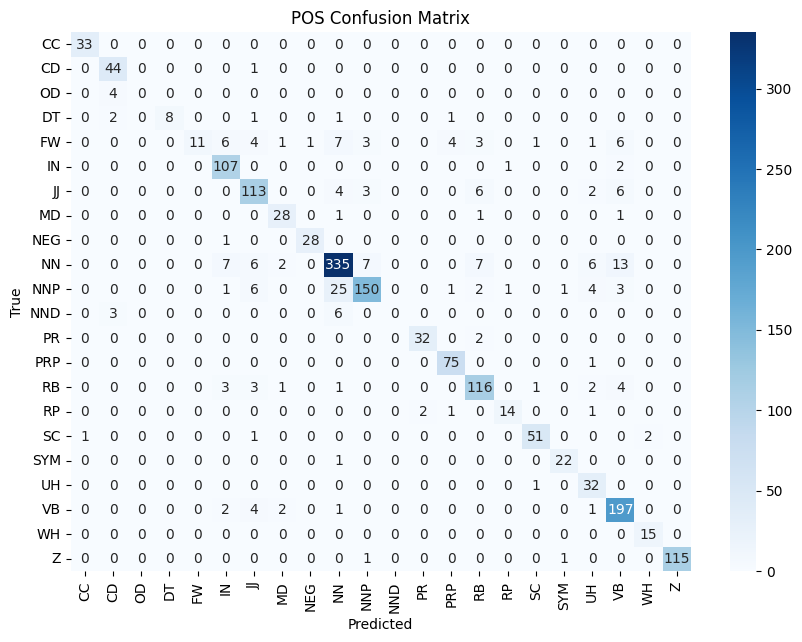

Epoch 23/100
  Train Loss: 0.3173
  Val   Loss: 1.0943
  Val Perplexity: 2.9870
  Train POS Loss: 0.2351
  Val   POS Loss: 0.4296
  Train NER Loss: 0.2739
  Val   NER Loss: 2.2154
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.81      0.98      0.89        45
          DT       1.00      0.62      0.76        13
          FW       1.00      0.19      0.32        48
          IN       0.86      0.97      0.91       110
          JJ       0.81      0.84      0.83       134
          MD       0.88      0.90      0.89        31
         NEG       0.97      0.97      0.97        29
          NN       0.89      0.88      0.88       383
         NND       0.00      0.00      0.00         9
         NNP       0.89      0.86      0.87       194
          OD       0.00      0.00      0.00         4
          PR       0.97      0.94      0.96        34
         PRP       0.91      0.99      0.95        76
         

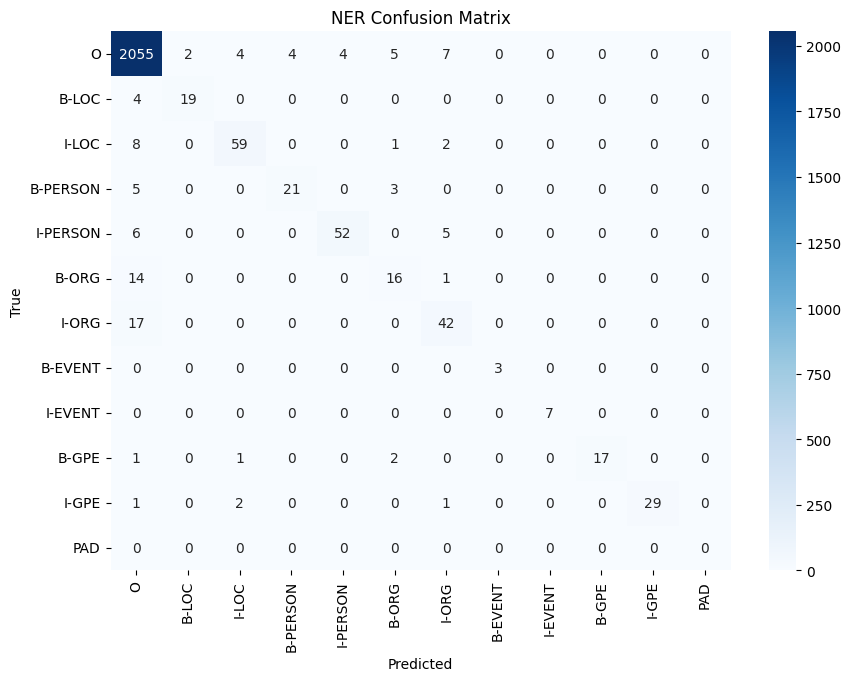

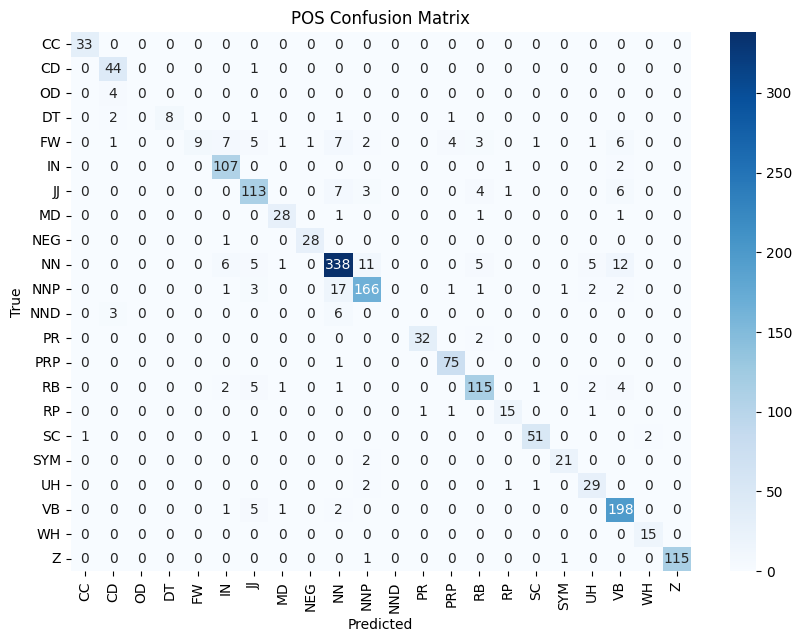

Saving model with highest POS F1 score: 0.791  and NER F1 score: 0.86  from epoch 23 , Validation Loss : 1.0943


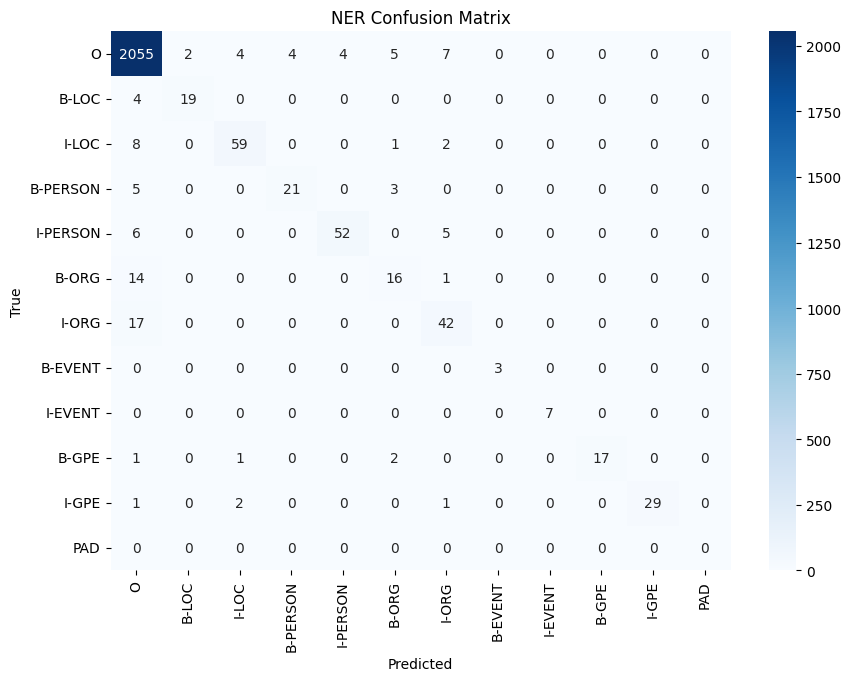

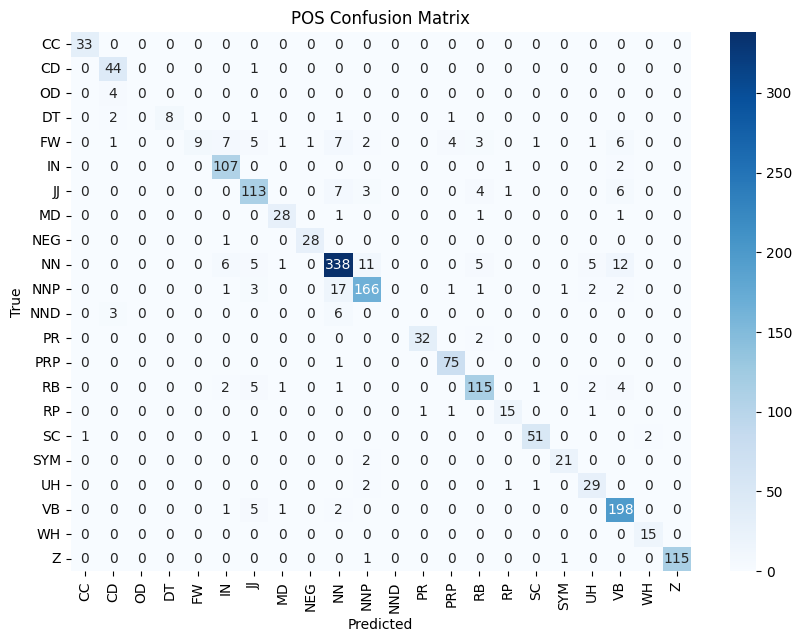

Epoch 24/100
  Train Loss: 0.2777
  Val   Loss: 1.0972
  Val Perplexity: 2.9957
  Train POS Loss: 0.2154
  Val   POS Loss: 0.3998
  Train NER Loss: 0.2078
  Val   NER Loss: 2.3247
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.85      0.98      0.91        45
          DT       0.89      0.62      0.73        13
          FW       1.00      0.33      0.50        48
          IN       0.88      0.97      0.92       110
          JJ       0.82      0.82      0.82       134
          MD       0.90      0.90      0.90        31
         NEG       0.97      0.97      0.97        29
          NN       0.88      0.91      0.89       383
         NND       1.00      0.11      0.20         9
         NNP       0.88      0.85      0.86       194
          OD       0.00      0.00      0.00         4
          PR       0.97      0.94      0.96        34
         PRP       0.93      0.99      0.96        76
         

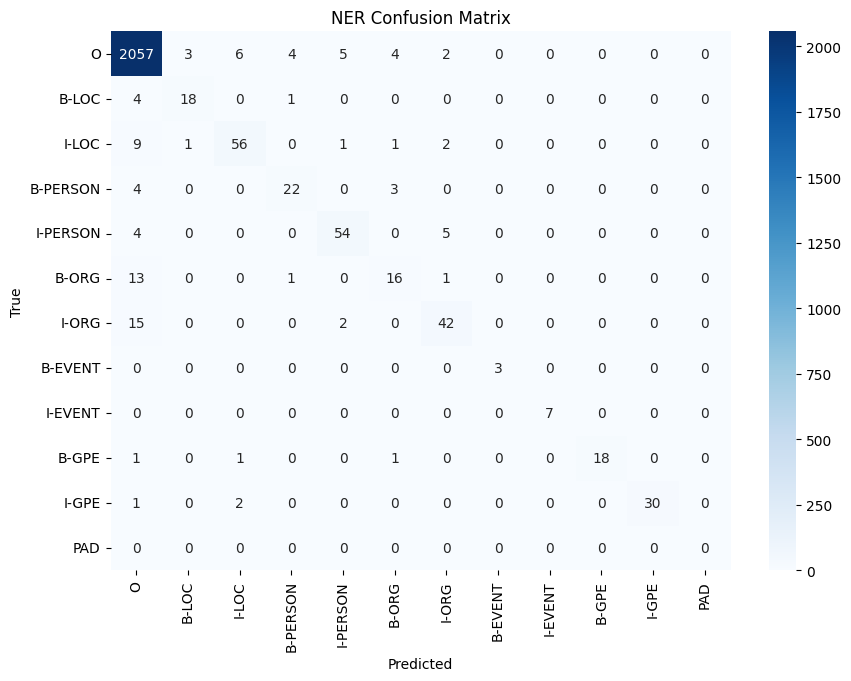

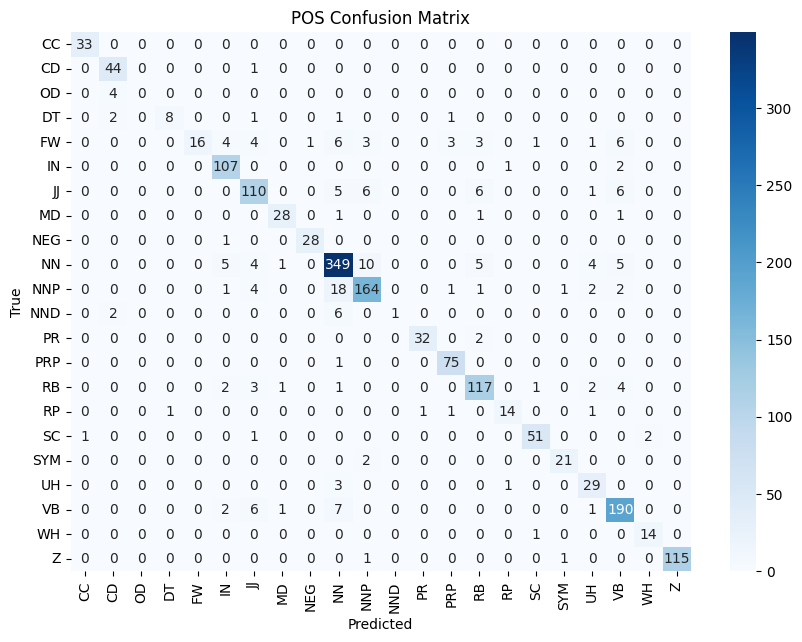

Epoch 25/100
  Train Loss: 0.2532
  Val   Loss: 1.1004
  Val Perplexity: 3.0053
  Train POS Loss: 0.2008
  Val   POS Loss: 0.4121
  Train NER Loss: 0.1746
  Val   NER Loss: 2.2942
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.83      0.98      0.90        45
          DT       1.00      0.69      0.82        13
          FW       1.00      0.25      0.40        48
          IN       0.89      0.97      0.93       110
          JJ       0.80      0.84      0.82       134
          MD       0.88      0.90      0.89        31
         NEG       0.97      0.97      0.97        29
          NN       0.92      0.88      0.90       383
         NND       1.00      0.11      0.20         9
         NNP       0.86      0.88      0.87       194
          OD       0.00      0.00      0.00         4
          PR       1.00      0.94      0.97        34
         PRP       0.91      0.99      0.95        76
         

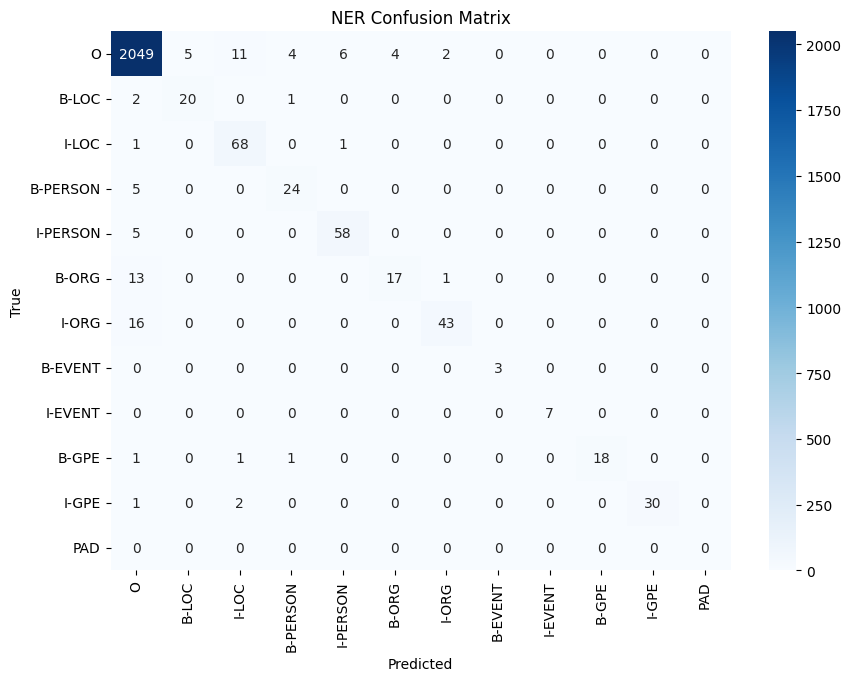

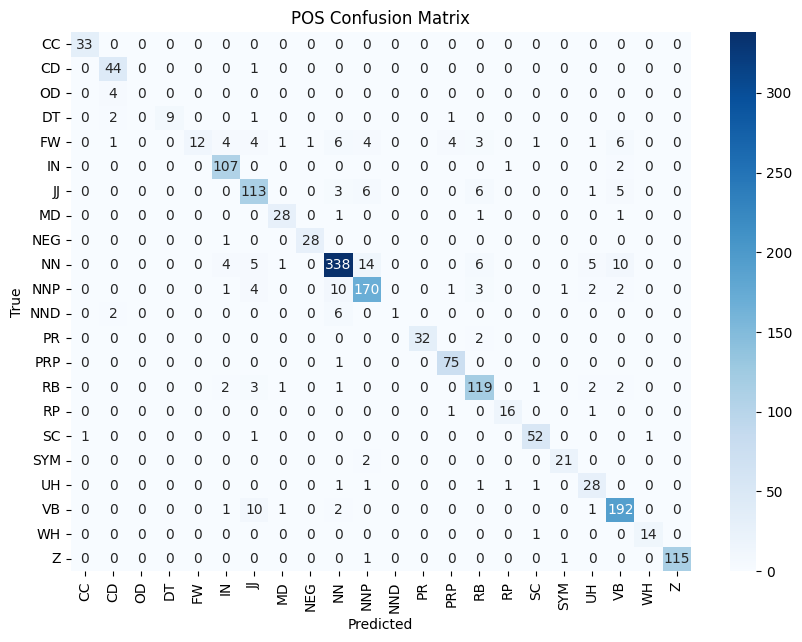

Saving model with highest POS F1 score: 0.808  and NER F1 score: 0.889  from epoch 25 , Validation Loss : 1.1004


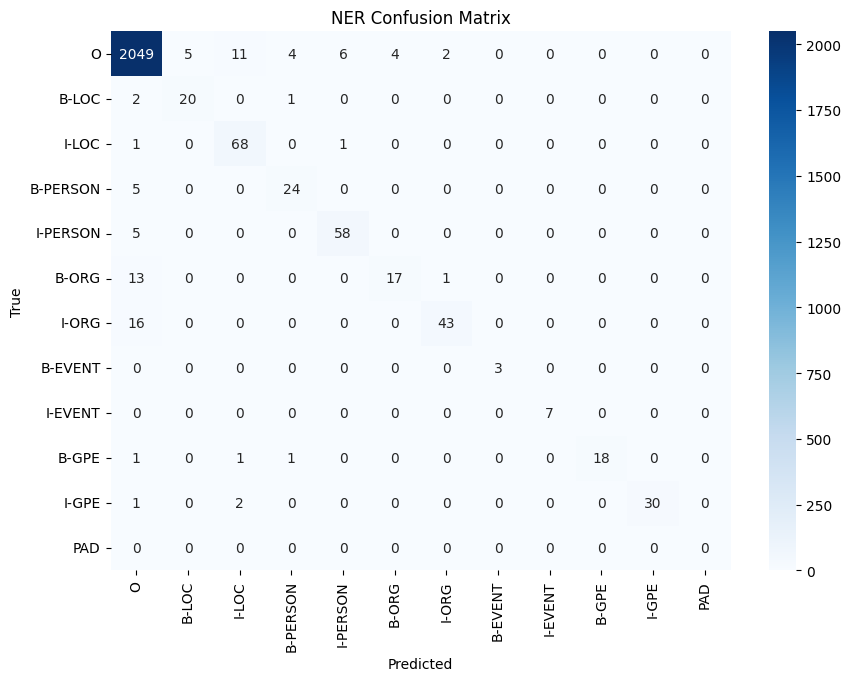

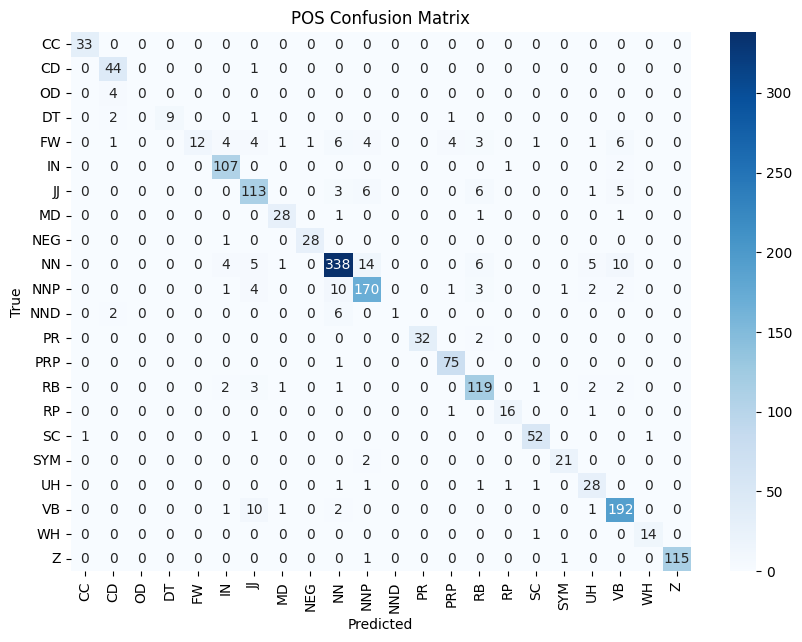

Epoch 26/100
  Train Loss: 0.2336
  Val   Loss: 1.0558
  Val Perplexity: 2.8742
  Train POS Loss: 0.1841
  Val   POS Loss: 0.3966
  Train NER Loss: 0.1650
  Val   NER Loss: 2.1973
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.81      0.98      0.89        45
          DT       1.00      0.69      0.82        13
          FW       1.00      0.25      0.40        48
          IN       0.88      0.97      0.93       110
          JJ       0.84      0.84      0.84       134
          MD       0.88      0.90      0.89        31
         NEG       0.97      0.97      0.97        29
          NN       0.92      0.87      0.89       383
         NND       1.00      0.22      0.36         9
         NNP       0.84      0.90      0.87       194
          OD       0.00      0.00      0.00         4
          PR       0.97      0.94      0.96        34
         PRP       0.93      0.99      0.96        76
         

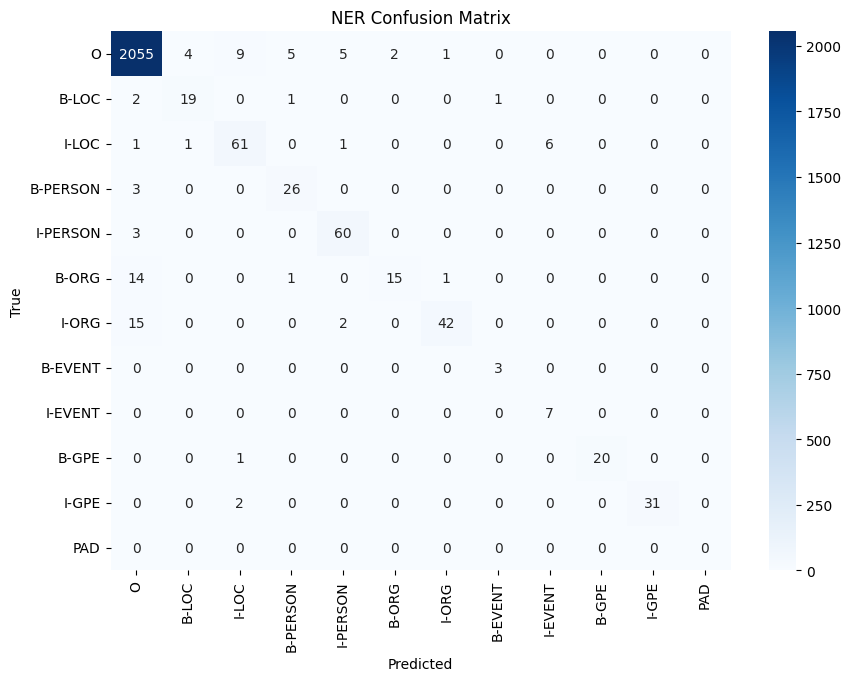

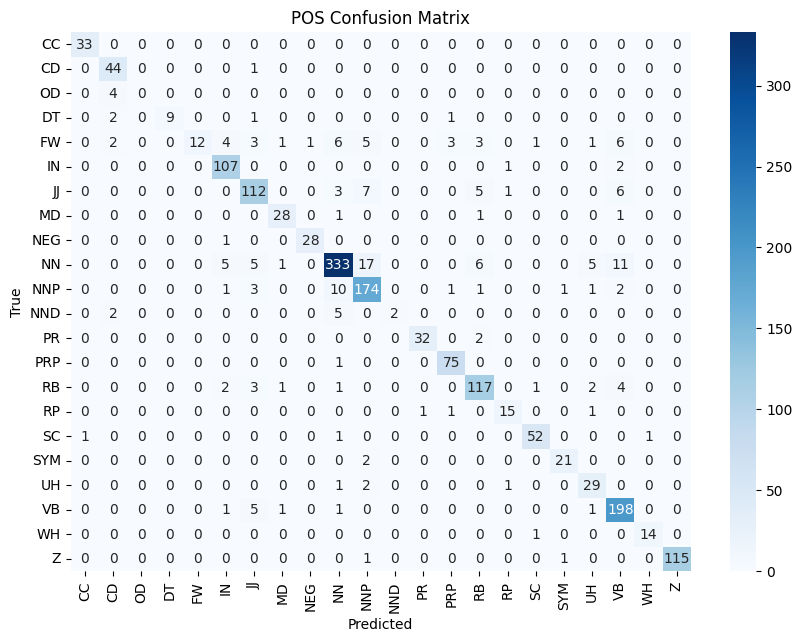

Epoch 27/100
  Train Loss: 0.2212
  Val   Loss: 1.2512
  Val Perplexity: 3.4945
  Train POS Loss: 0.1744
  Val   POS Loss: 0.4140
  Train NER Loss: 0.1560
  Val   NER Loss: 2.7907
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.85      0.98      0.91        45
          DT       0.90      0.69      0.78        13
          FW       1.00      0.29      0.45        48
          IN       0.89      0.97      0.93       110
          JJ       0.82      0.84      0.83       134
          MD       0.85      0.90      0.88        31
         NEG       0.97      0.97      0.97        29
          NN       0.91      0.87      0.89       383
         NND       1.00      0.33      0.50         9
         NNP       0.82      0.92      0.87       194
          OD       0.00      0.00      0.00         4
          PR       0.91      0.94      0.93        34
         PRP       0.94      0.97      0.95        76
         

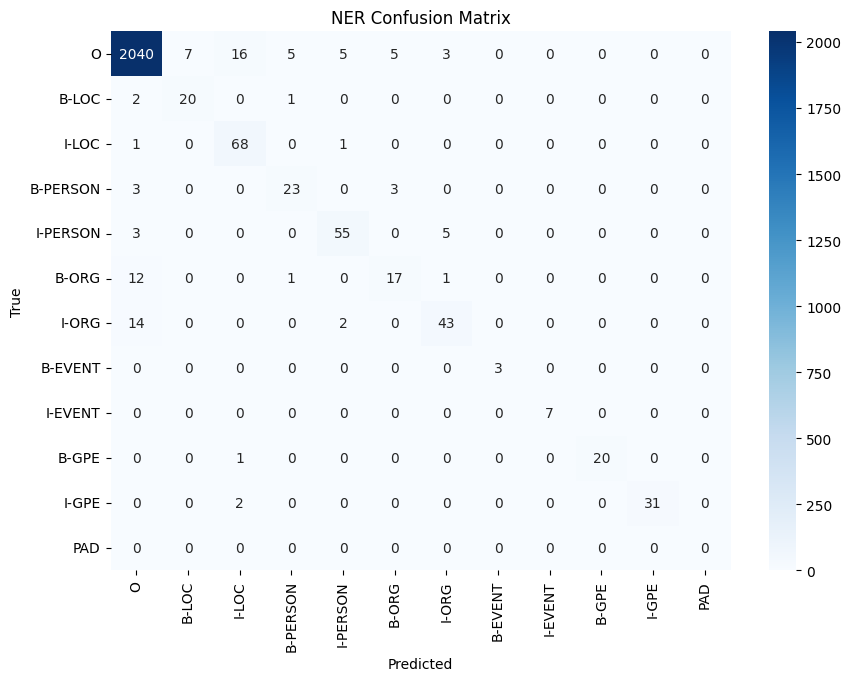

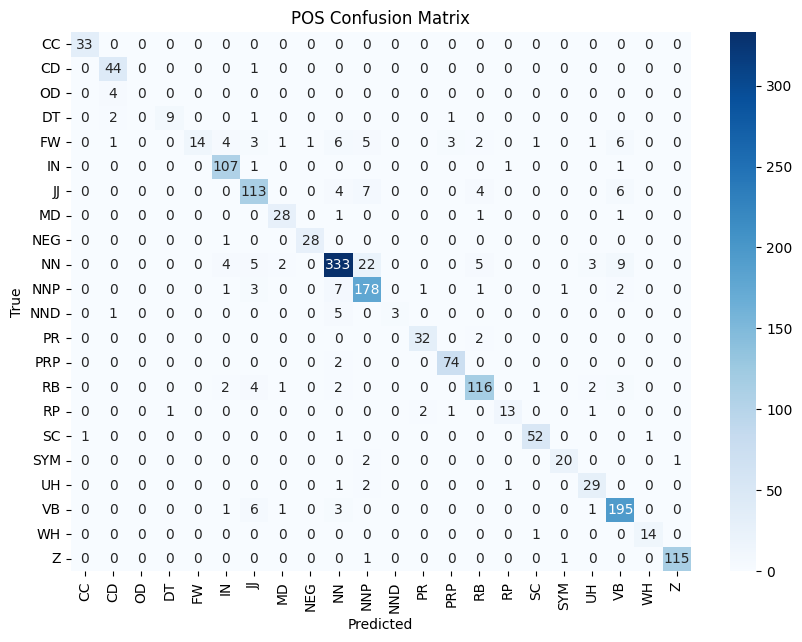

Epoch 28/100
  Train Loss: 0.2034
  Val   Loss: 1.1537
  Val Perplexity: 3.1697
  Train POS Loss: 0.1601
  Val   POS Loss: 0.3894
  Train NER Loss: 0.1445
  Val   NER Loss: 2.5474
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.85      0.98      0.91        45
          DT       0.90      0.69      0.78        13
          FW       1.00      0.40      0.57        48
          IN       0.89      0.97      0.93       110
          JJ       0.84      0.81      0.83       134
          MD       0.88      0.90      0.89        31
         NEG       0.97      0.97      0.97        29
          NN       0.92      0.89      0.90       383
         NND       1.00      0.33      0.50         9
         NNP       0.83      0.91      0.87       194
          OD       0.00      0.00      0.00         4
          PR       0.94      0.94      0.94        34
         PRP       0.94      0.99      0.96        76
         

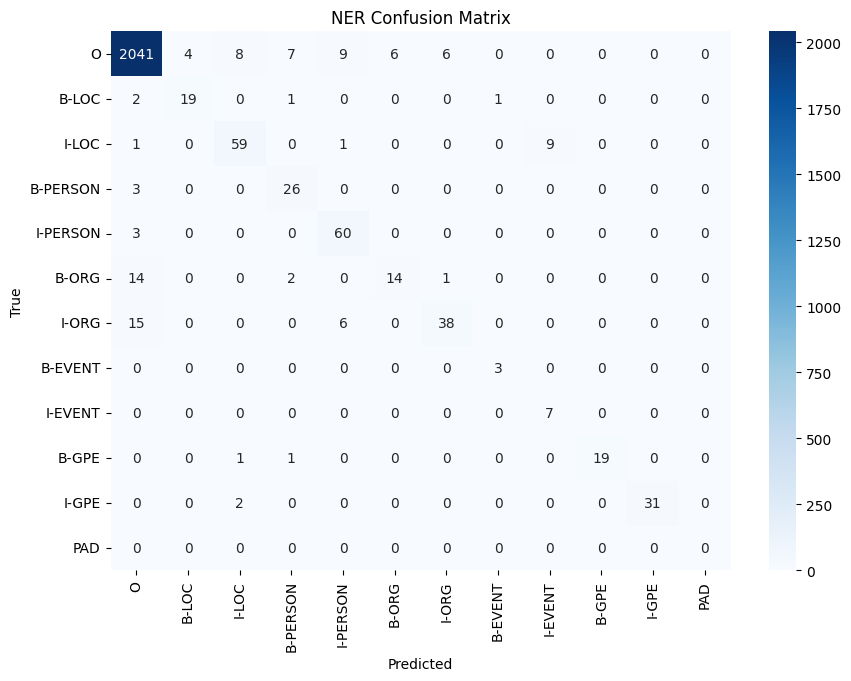

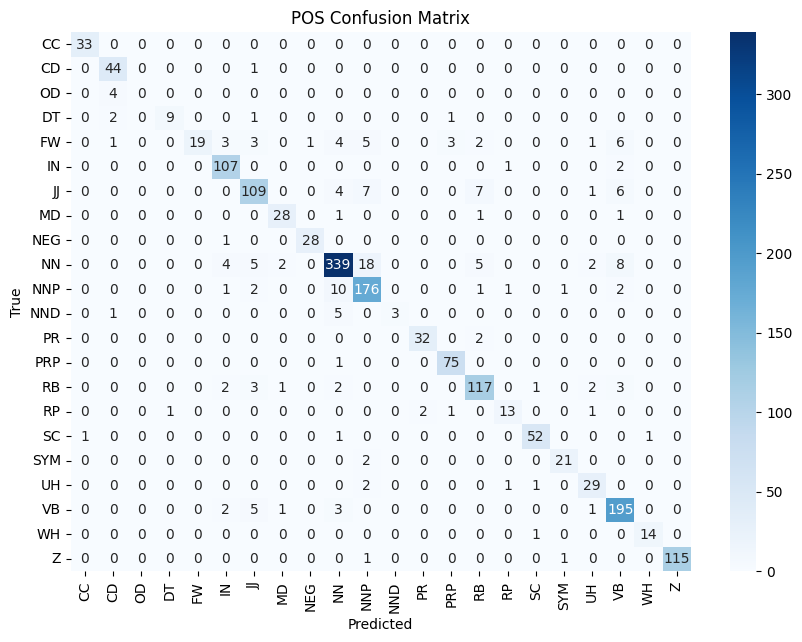

Epoch 29/100
  Train Loss: 0.1956
  Val   Loss: 1.1445
  Val Perplexity: 3.1410
  Train POS Loss: 0.1536
  Val   POS Loss: 0.3848
  Train NER Loss: 0.1400
  Val   NER Loss: 2.5326
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.85      0.98      0.91        45
          DT       0.90      0.69      0.78        13
          FW       1.00      0.38      0.55        48
          IN       0.89      0.97      0.93       110
          JJ       0.84      0.83      0.83       134
          MD       0.88      0.90      0.89        31
         NEG       0.97      0.97      0.97        29
          NN       0.91      0.90      0.91       383
         NND       1.00      0.33      0.50         9
         NNP       0.85      0.89      0.87       194
          OD       0.00      0.00      0.00         4
          PR       0.97      0.94      0.96        34
         PRP       0.94      0.99      0.96        76
         

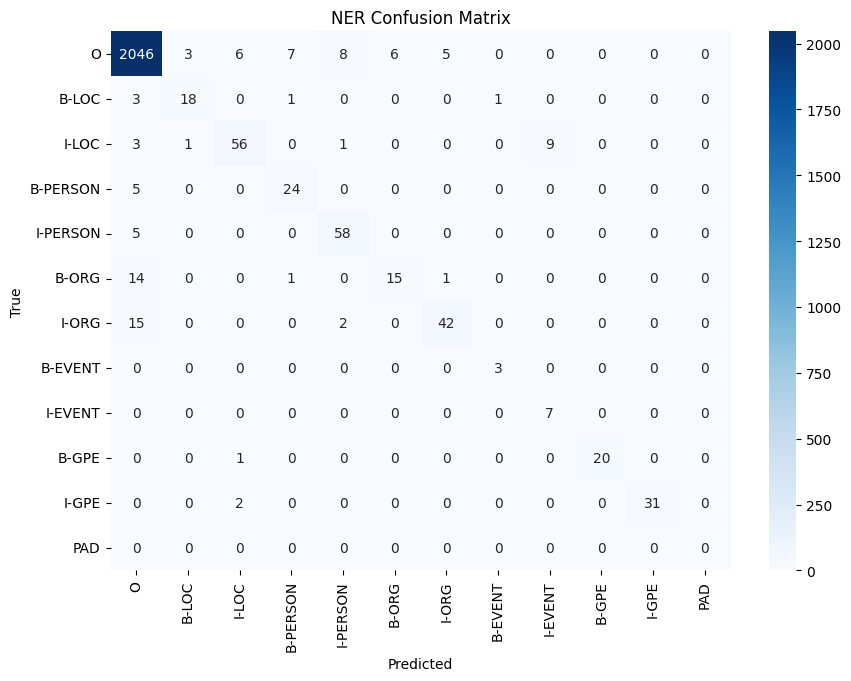

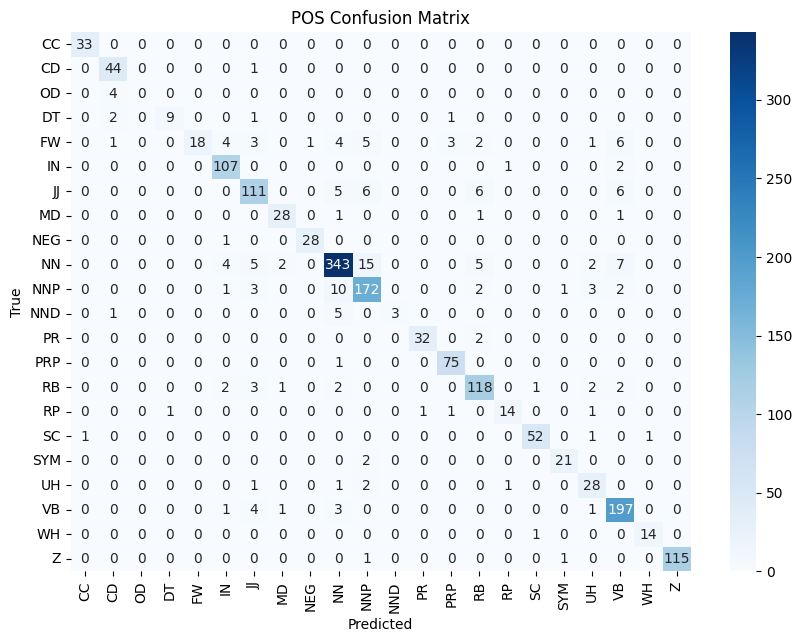

Epoch 30/100
  Train Loss: 0.1746
  Val   Loss: 1.1805
  Val Perplexity: 3.2561
  Train POS Loss: 0.1392
  Val   POS Loss: 0.3882
  Train NER Loss: 0.1179
  Val   NER Loss: 2.6411
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.90      0.98      0.94        45
          DT       1.00      0.77      0.87        13
          FW       1.00      0.54      0.70        48
          IN       0.91      0.96      0.94       110
          JJ       0.86      0.82      0.84       134
          MD       0.88      0.90      0.89        31
         NEG       0.97      0.97      0.97        29
          NN       0.92      0.88      0.90       383
         NND       1.00      0.33      0.50         9
         NNP       0.81      0.89      0.85       194
          OD       1.00      0.25      0.40         4
          PR       1.00      0.94      0.97        34
         PRP       0.96      0.99      0.97        76
         

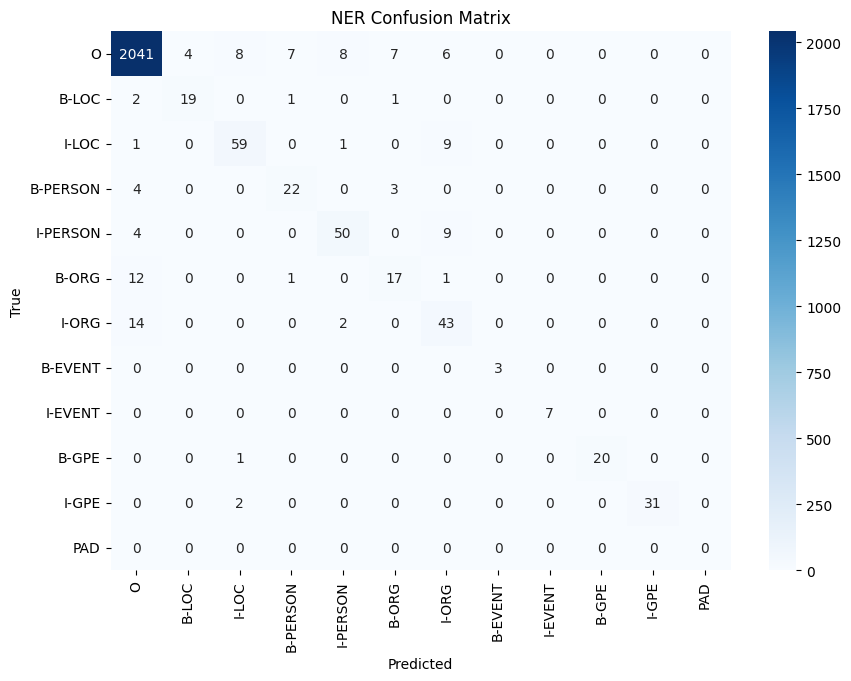

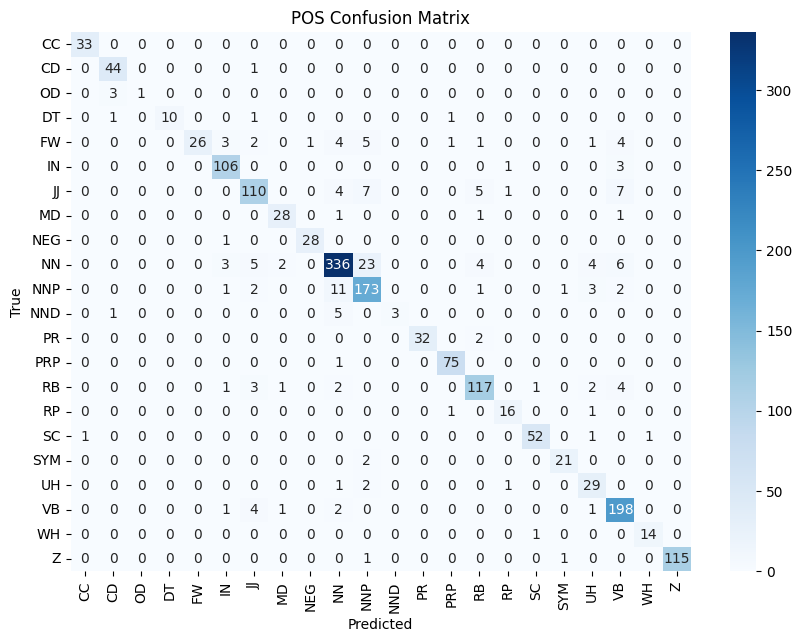

Epoch 31/100
  Train Loss: 0.1723
  Val   Loss: 1.1161
  Val Perplexity: 3.0528
  Train POS Loss: 0.1364
  Val   POS Loss: 0.3771
  Train NER Loss: 0.1199
  Val   NER Loss: 2.4631
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.86      0.98      0.92        45
          DT       1.00      0.69      0.82        13
          FW       1.00      0.44      0.61        48
          IN       0.90      0.97      0.93       110
          JJ       0.83      0.84      0.83       134
          MD       0.85      0.90      0.88        31
         NEG       0.97      0.97      0.97        29
          NN       0.92      0.91      0.91       383
         NND       1.00      0.56      0.71         9
         NNP       0.89      0.86      0.87       194
          OD       1.00      0.25      0.40         4
          PR       1.00      0.94      0.97        34
         PRP       0.91      0.99      0.95        76
         

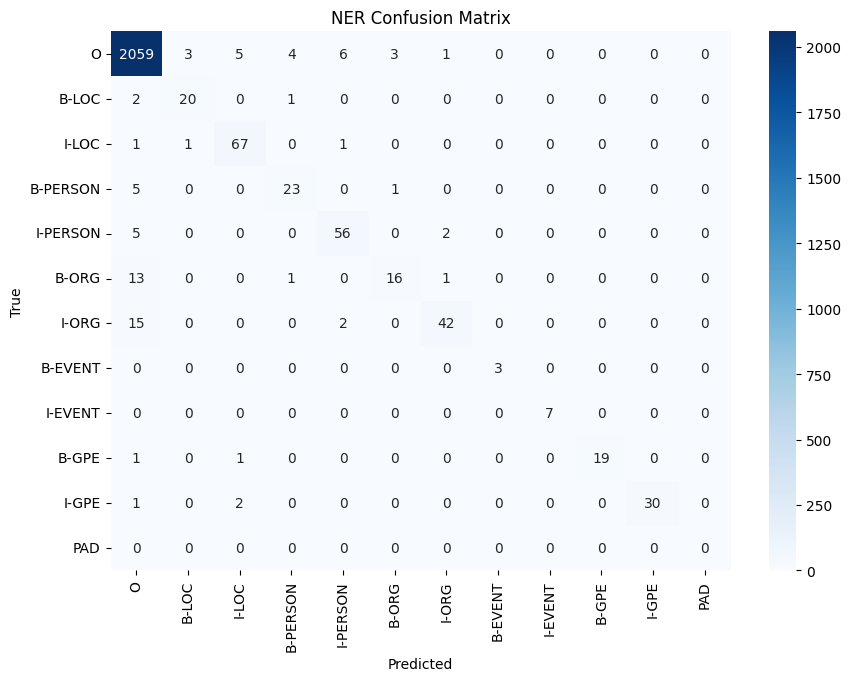

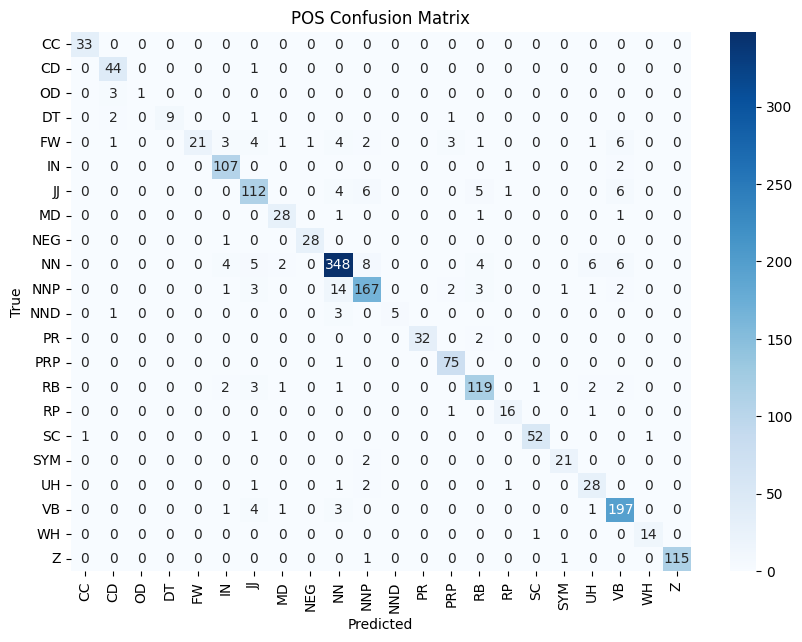

Epoch 32/100
  Train Loss: 0.1665
  Val   Loss: 1.2476
  Val Perplexity: 3.4819
  Train POS Loss: 0.1282
  Val   POS Loss: 0.3960
  Train NER Loss: 0.1279
  Val   NER Loss: 2.8387
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.85      0.98      0.91        45
          DT       0.90      0.69      0.78        13
          FW       1.00      0.31      0.48        48
          IN       0.89      0.97      0.93       110
          JJ       0.84      0.83      0.83       134
          MD       0.85      0.90      0.88        31
         NEG       0.97      0.97      0.97        29
          NN       0.94      0.88      0.91       383
         NND       1.00      0.56      0.71         9
         NNP       0.83      0.94      0.88       194
          OD       1.00      0.25      0.40         4
          PR       0.97      0.94      0.96        34
         PRP       0.94      0.99      0.96        76
         

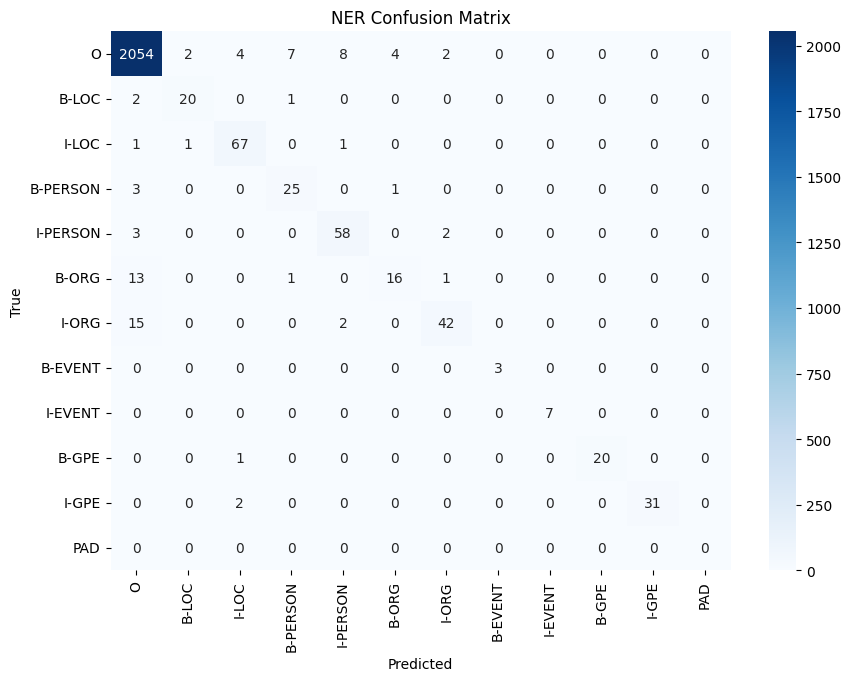

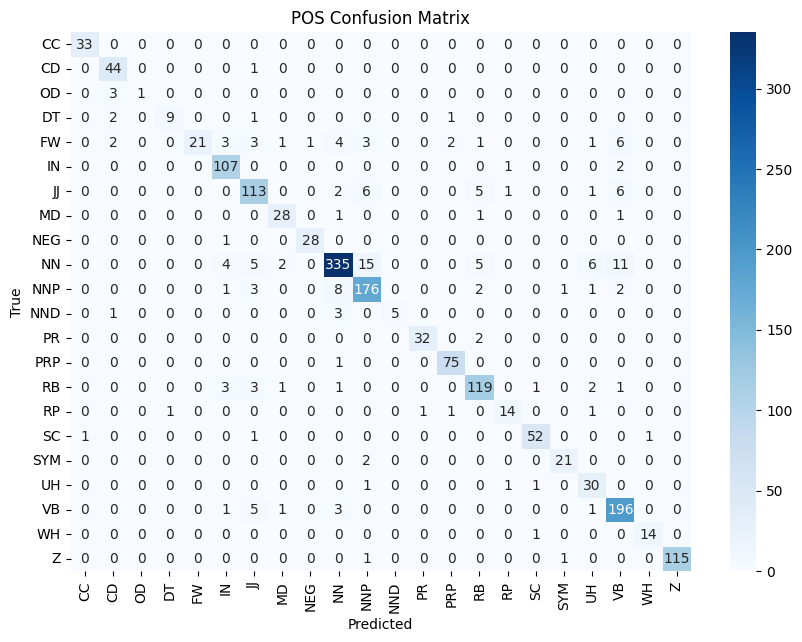

Epoch 36/100
  Train Loss: 0.1277
  Val   Loss: 1.1570
  Val Perplexity: 3.1803
  Train POS Loss: 0.0954
  Val   POS Loss: 0.3855
  Train NER Loss: 0.1076
  Val   NER Loss: 2.5715
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.86      0.98      0.92        45
          DT       1.00      0.69      0.82        13
          FW       1.00      0.48      0.65        48
          IN       0.91      0.97      0.94       110
          JJ       0.86      0.83      0.84       134
          MD       0.85      0.90      0.88        31
         NEG       0.97      0.97      0.97        29
          NN       0.95      0.88      0.91       383
         NND       1.00      0.78      0.88         9
         NNP       0.86      0.91      0.89       194
          OD       1.00      0.25      0.40         4
          PR       1.00      0.94      0.97        34
         PRP       0.95      0.99      0.97        76
         

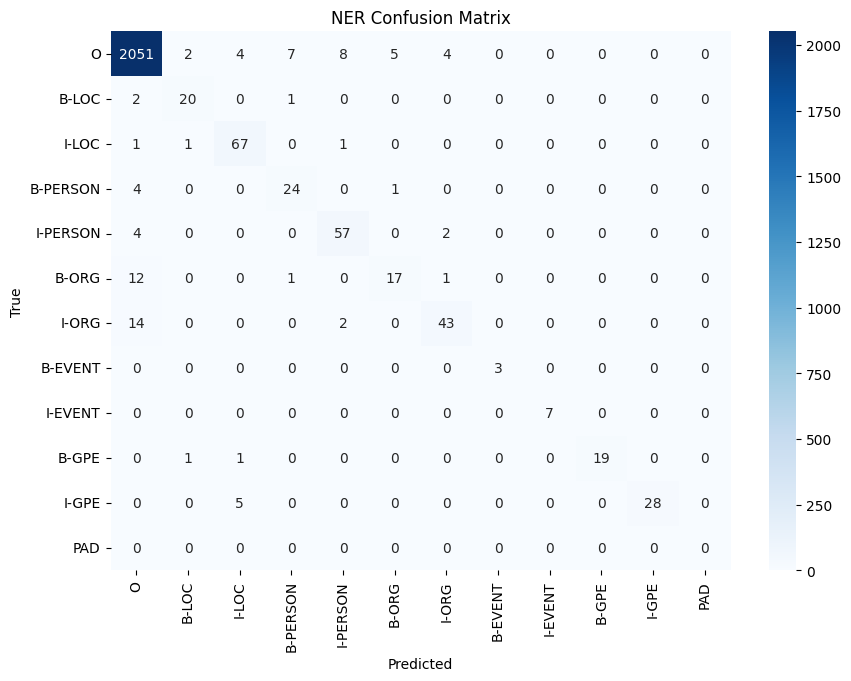

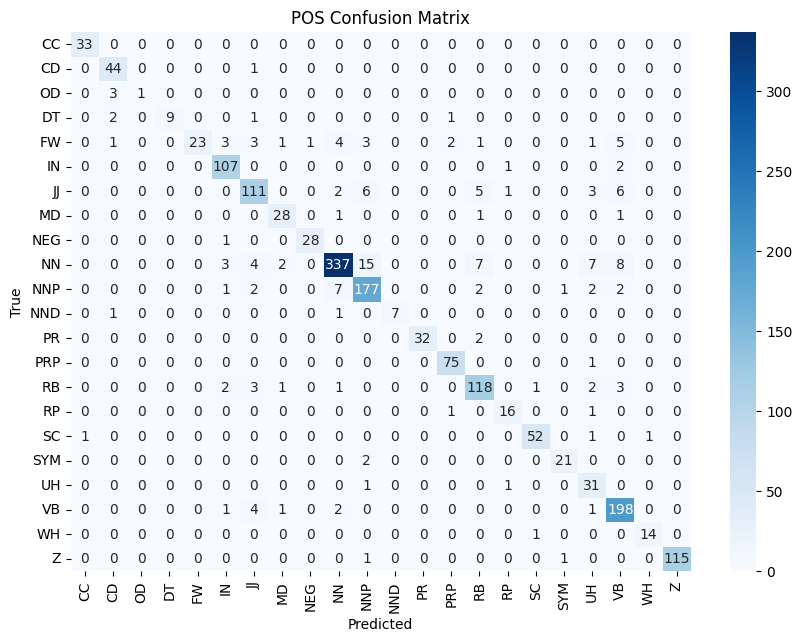

Epoch 37/100
  Train Loss: 0.1167
  Val   Loss: 1.1615
  Val Perplexity: 3.1946
  Train POS Loss: 0.0919
  Val   POS Loss: 0.3938
  Train NER Loss: 0.0827
  Val   NER Loss: 2.5589
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.85      0.98      0.91        45
          DT       1.00      0.62      0.76        13
          FW       0.95      0.44      0.60        48
          IN       0.90      0.97      0.93       110
          JJ       0.85      0.86      0.85       134
          MD       0.85      0.90      0.88        31
         NEG       0.97      0.97      0.97        29
          NN       0.94      0.89      0.91       383
         NND       1.00      0.56      0.71         9
         NNP       0.86      0.91      0.88       194
          OD       1.00      0.25      0.40         4
          PR       1.00      0.94      0.97        34
         PRP       0.95      0.99      0.97        76
         

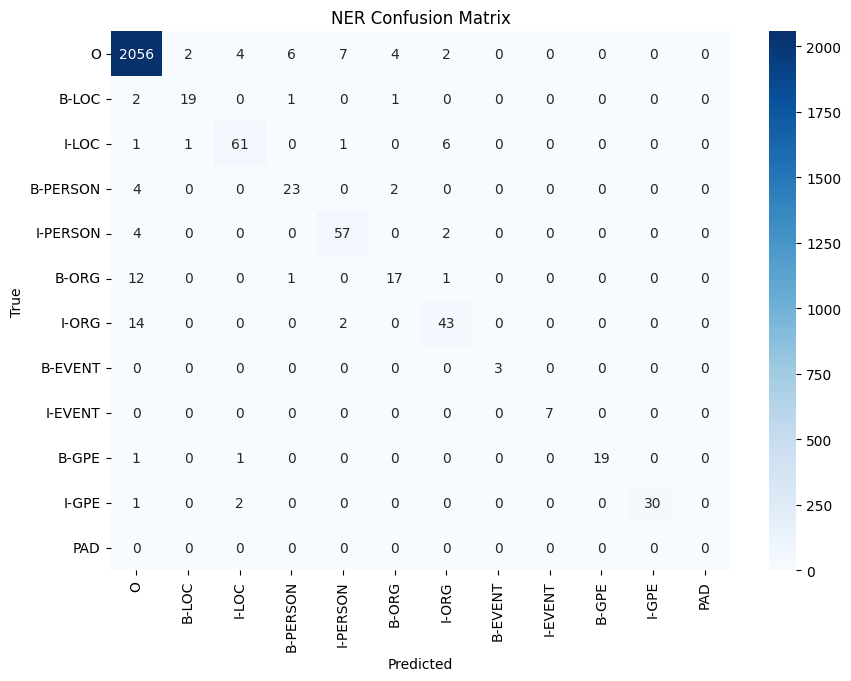

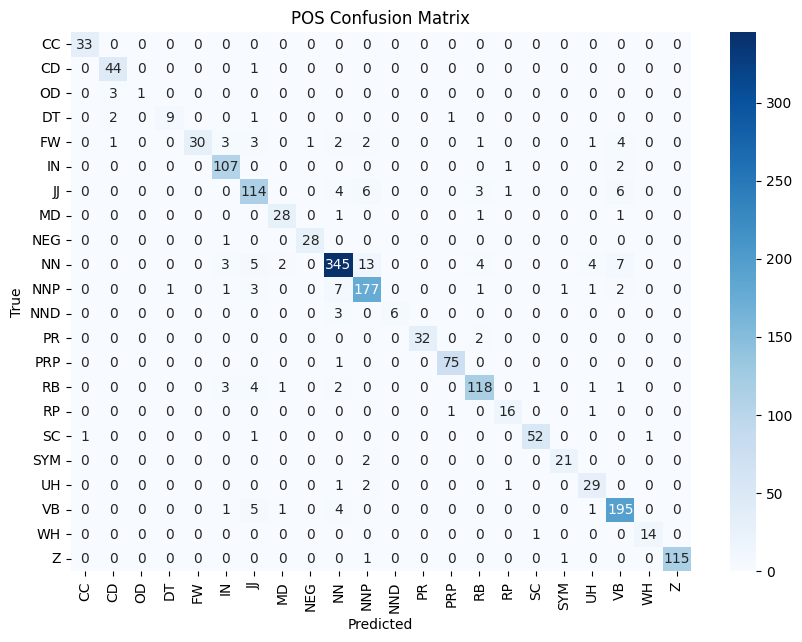

Epoch 40/100
  Train Loss: 0.1040
  Val   Loss: 1.2004
  Val Perplexity: 3.3216
  Train POS Loss: 0.0797
  Val   POS Loss: 0.4166
  Train NER Loss: 0.0811
  Val   NER Loss: 2.6127
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.90      0.98      0.94        45
          DT       0.82      0.69      0.75        13
          FW       0.93      0.29      0.44        48
          IN       0.90      0.97      0.93       110
          JJ       0.80      0.85      0.83       134
          MD       0.85      0.90      0.88        31
         NEG       0.97      0.97      0.97        29
          NN       0.93      0.90      0.91       383
         NND       1.00      0.89      0.94         9
         NNP       0.87      0.89      0.88       194
          OD       1.00      0.50      0.67         4
          PR       0.94      0.94      0.94        34
         PRP       0.94      0.99      0.96        76
         

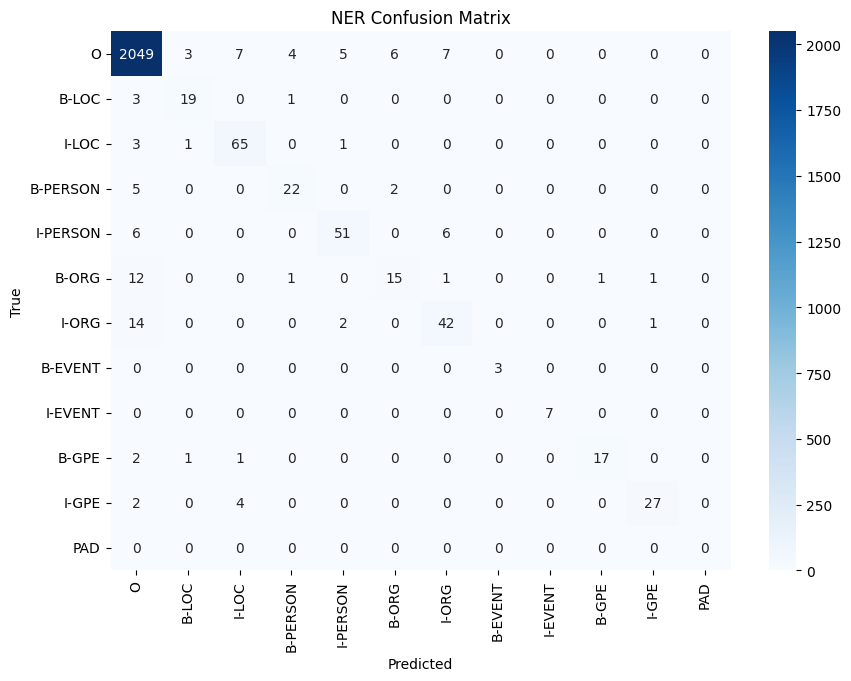

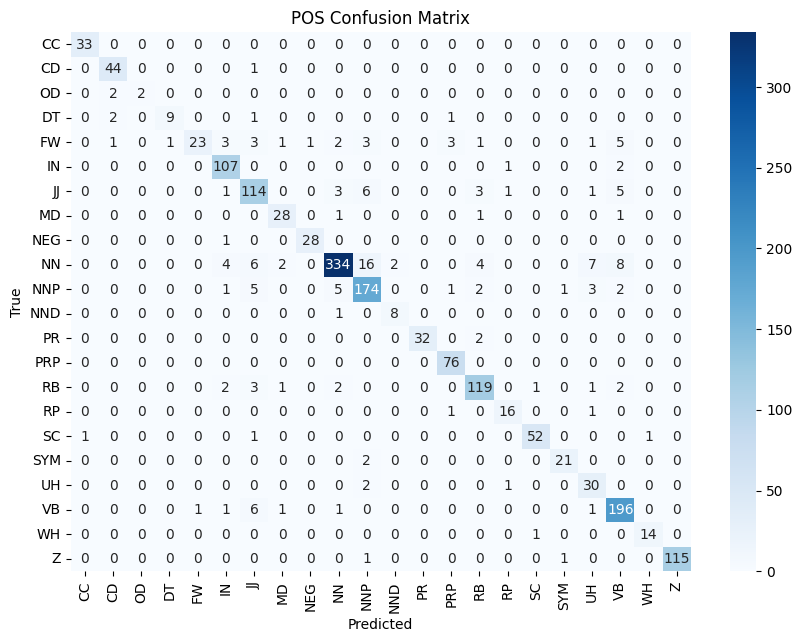

Epoch 42/100
  Train Loss: 0.1453
  Val   Loss: 1.2461
  Val Perplexity: 3.4767
  Train POS Loss: 0.0958
  Val   POS Loss: 0.4380
  Train NER Loss: 0.1651
  Val   NER Loss: 2.6937
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.88      0.98      0.93        45
          DT       0.89      0.62      0.73        13
          FW       0.92      0.25      0.39        48
          IN       0.89      0.97      0.93       110
          JJ       0.83      0.84      0.83       134
          MD       0.85      0.90      0.88        31
         NEG       0.97      0.97      0.97        29
          NN       0.93      0.86      0.89       383
         NND       1.00      0.89      0.94         9
         NNP       0.82      0.91      0.86       194
          OD       1.00      0.75      0.86         4
          PR       1.00      0.94      0.97        34
         PRP       0.93      1.00      0.96        76
         

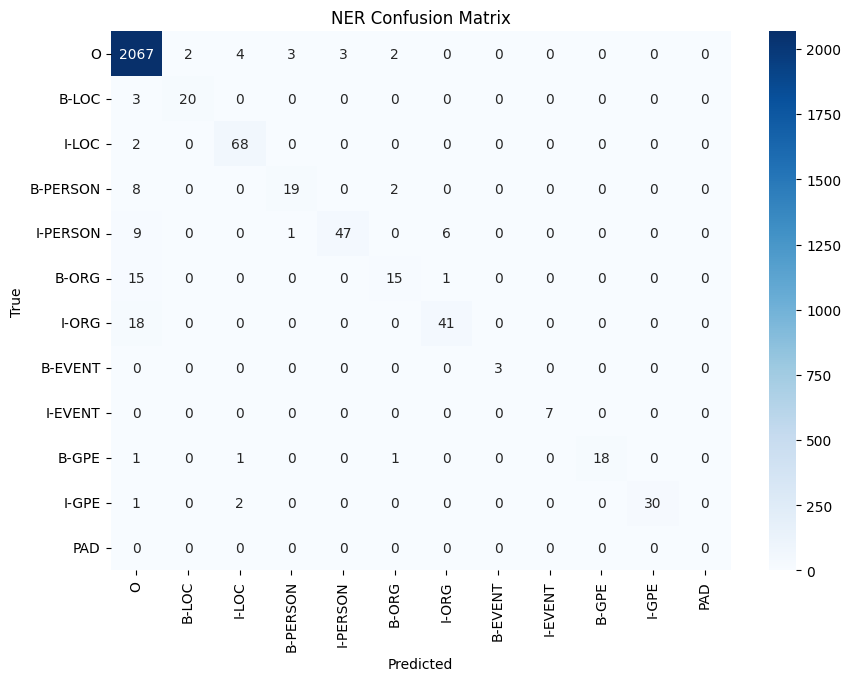

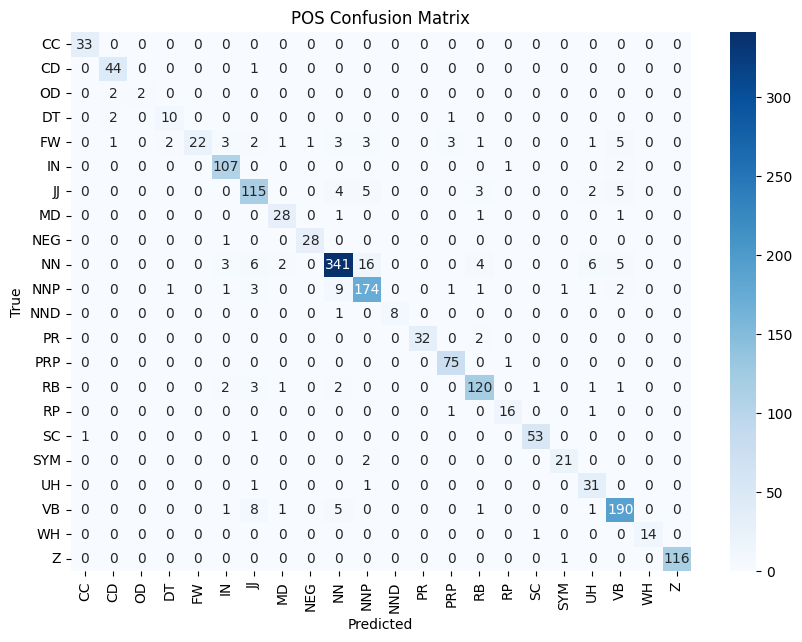

Epoch 60/100
  Train Loss: 0.0475
  Val   Loss: 1.4111
  Val Perplexity: 4.1007
  Train POS Loss: 0.0362
  Val   POS Loss: 0.4710
  Train NER Loss: 0.0378
  Val   NER Loss: 3.1337
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.90      0.98      0.94        45
          DT       0.77      0.77      0.77        13
          FW       1.00      0.33      0.50        48
          IN       0.91      0.97      0.94       110
          JJ       0.84      0.84      0.84       134
          MD       0.85      0.90      0.88        31
         NEG       0.97      0.97      0.97        29
          NN       0.94      0.88      0.91       383
         NND       1.00      0.89      0.94         9
         NNP       0.86      0.90      0.88       194
          OD       1.00      0.50      0.67         4
          PR       1.00      0.94      0.97        34
         PRP       0.94      0.99      0.96        76
         

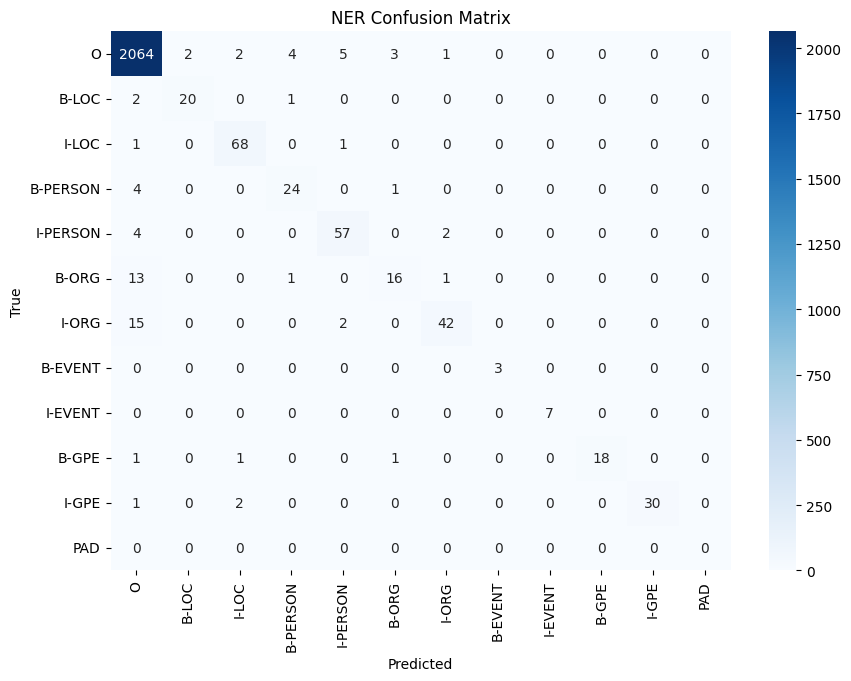

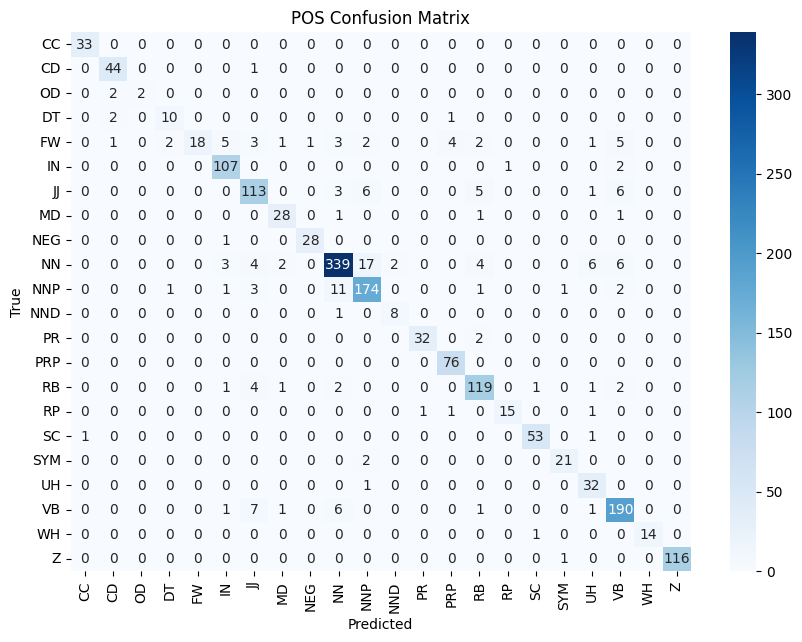

Epoch 98/100
  Train Loss: 0.0226
  Val   Loss: 1.3760
  Val Perplexity: 3.9592
  Train POS Loss: 0.0178
  Val   POS Loss: 0.5065
  Train NER Loss: 0.0159
  Val   NER Loss: 2.8985
              precision    recall  f1-score   support

          CC       0.97      1.00      0.99        33
          CD       0.90      0.98      0.94        45
          DT       0.77      0.77      0.77        13
          FW       0.95      0.38      0.54        48
          IN       0.90      0.97      0.93       110
          JJ       0.84      0.84      0.84       134
          MD       0.85      0.90      0.88        31
         NEG       0.97      0.97      0.97        29
          NN       0.93      0.89      0.91       383
         NND       0.80      0.89      0.84         9
         NNP       0.86      0.90      0.88       194
          OD       1.00      0.50      0.67         4
          PR       0.97      0.94      0.96        34
         PRP       0.93      1.00      0.96        76
         

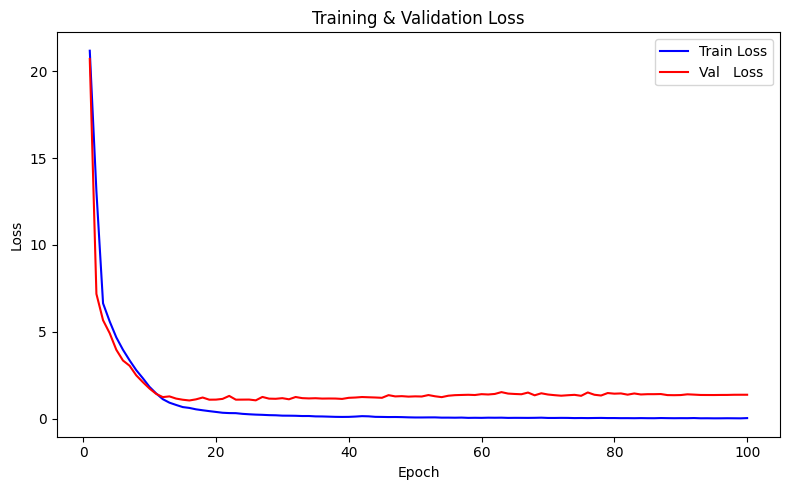

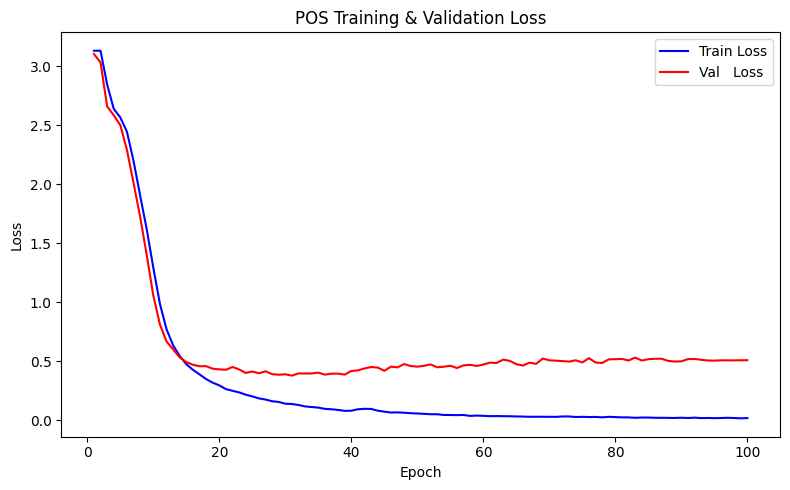

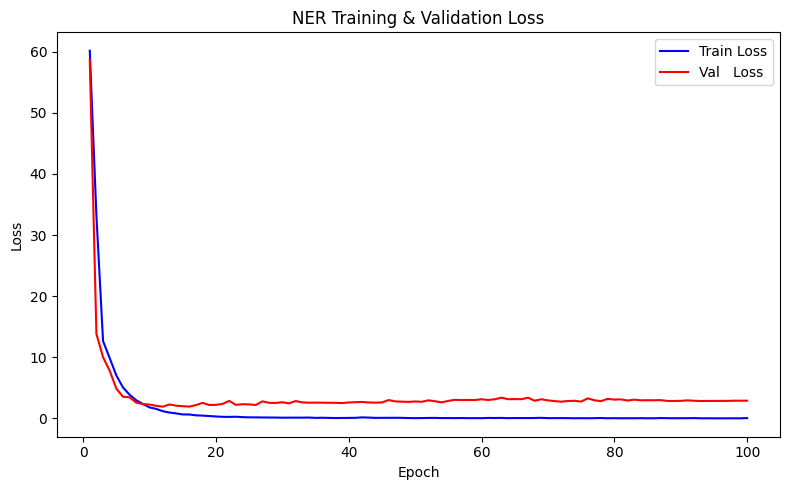

Lowest POS Loss = 0.3771
Lowest NER Loss = 1.9182
Average POS Loss = 0.6493
Average NER Loss = 3.5696


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from seaborn import heatmap
import matplotlib.pyplot as plt

class TokenClassificationDataset(Dataset):
    def __init__(self, encodings, pos_labels, ner_labels, pad_ner_id=0):
        self.encodings = encodings
        self.pos_labels = pos_labels
        # replace -100 with pad_ner_id
        self.ner_labels = [
            [lab if lab >= 0 else pad_ner_id for lab in seq]
            for seq in ner_labels
        ]
        # Sanity check label ranges right at init
        num_tags = len(ner_label2id)
        for i, seq in enumerate(self.ner_labels):
            if min(seq) < 0 or max(seq) >= num_tags:
                raise ValueError(f"NER labels out of range in sequence {i}: {min(seq)} to {max(seq)}")

    def __len__(self):
        return len(self.pos_labels)

    def __getitem__(self, idx):
        # Use as_tensor instead of torch.tensor
        item = {key: torch.as_tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels_pos'] = torch.as_tensor(self.pos_labels[idx])
        item['labels_ner'] = torch.as_tensor(self.ner_labels[idx])
        return item


# Instantiate datasets with PAD id for NER
pad_ner_id = ner_label2id["PAD"]
train_dataset_crf = TokenClassificationDataset(
    encodings=encoded_train,
    pos_labels=aligned_pos_labels_train,
    ner_labels=aligned_ner_labels_train,
    pad_ner_id=pad_ner_id
)
val_dataset_crf = TokenClassificationDataset(
    encodings=encoded_val,
    pos_labels=aligned_pos_labels_val,
    ner_labels=aligned_ner_labels_val,
    pad_ner_id=pad_ner_id
)

batch_size = 32

train_loader_crf = DataLoader(train_dataset_crf, batch_size=batch_size, shuffle=True)
val_loader_crf   = DataLoader(val_dataset_crf, batch_size=batch_size, shuffle=False)


optimizer = AdamW([
    {'params': model.roberta.parameters(), 'lr': 3e-5},
    {'params': model.classifier_pos.parameters(), 'lr' : 5e-5},
    {'params': model.classifier_ner.parameters(), 'lr' : 3e-4},
    {'params': model.crf.parameters(), 'lr' : 3e-4}
])

epochs = 100
total_steps = len(train_loader_crf) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

def train_epoch(model, loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    total_ner_loss = 0.0
    total_pos_loss = 0.0

    for batch in loader:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            labels_pos=batch['labels_pos'],
            labels_ner=batch['labels_ner']
        )
        loss = outputs['loss']
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        total_ner_loss += outputs['ner_loss'].item()
        total_pos_loss += outputs['pos_loss'].item()


    return total_loss / len(loader), total_pos_loss / len(loader), total_ner_loss / len(loader)

def evaluate(model, loader, device, pos_id2label, ner_id2label):
    model.eval()
    all_labels_pos, all_preds_pos = [], []
    all_labels_ner, all_preds_ner = [], []

    val_loss = 0.0
    val_ner_loss = 0.0
    val_pos_loss = 0.0

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels_pos=batch['labels_pos'],
                labels_ner=batch['labels_ner']
            )

            val_loss += outputs['loss'].item()
            val_ner_loss += outputs['ner_loss'].item()
            val_pos_loss += outputs['pos_loss'].item()


            # print(model.crf.transitions[:5,:5])  # see your -1e9 entries
            # print("Using CRF decode?", outputs.get("predictions_ner") is not None)


            # POS
            logits_pos = outputs['logits_pos']
            preds_pos = logits_pos.argmax(dim=-1).cpu().numpy()
            labels_pos = batch['labels_pos'].cpu().numpy()

            # NER via CRF decode
            # emissions = outputs['emissions_ner']
            # mask = batch['attention_mask'].bool()
            preds_ner = outputs['predictions_ner']
            labels_ner = batch['labels_ner'].cpu().numpy().tolist()

            # flatten POS
            for lp, pp in zip(labels_pos, preds_pos):
                valid = lp != -100  # POS still uses -100
                all_labels_pos.extend(lp[valid].tolist())
                all_preds_pos.extend(pp[valid].tolist())

            # flatten NER (skip PAD if desired)
            for ln_seq, pn_seq in zip(labels_ner, preds_ner):
                for ln, pn in zip(ln_seq, pn_seq):
                    # optionally skip PAD label in metrics
                    if ln != pad_ner_id:
                        all_labels_ner.append(ln)
                        all_preds_ner.append(pn)

    avg_val_loss = val_loss / len(loader)



    all_labels_pos = [pos_id2label[i] for i in all_labels_pos]
    all_preds_pos  = [pos_id2label[i] for i in all_preds_pos]
    all_labels_ner = [ner_id2label[i] for i in all_labels_ner]
    all_preds_ner  = [ner_id2label[i] for i in all_preds_ner]

    ner_f1 = f1_score(all_labels_ner, all_preds_ner, average='macro', zero_division=0)
    pos_f1 = f1_score(all_labels_pos, all_preds_pos, average='macro', zero_division=0)


    return all_preds_pos, all_preds_ner, all_labels_pos, all_labels_ner, avg_val_loss, ner_f1, pos_f1, val_pos_loss / len(loader) , val_ner_loss / len(loader)

# Run training


train_loss_graph = []
val_loss_graph = []

ner_train_loss_graph = []
ner_val_loss_graph = []

pos_train_loss_graph = []
pos_val_loss_graph = []

highest_ner_f1 = [0.0, 0.0]
highest_pos_f1 = [0.0, 0.0]

for epoch in range(1, epochs+1):
    train_loss, train_pos_loss, train_ner_loss = train_epoch(model, train_loader_crf, optimizer, scheduler, device)
    preds_pos_crf, preds_ner_crf, labels_pos, labels_ner, val_loss, ner_f1, pos_f1, val_pos_loss, val_ner_loss = evaluate(model, val_loader_crf, device, pos_id2label, ner_id2label)
    print(f"Epoch {epoch}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}")
    print(f"  Val Perplexity: {torch.exp(torch.tensor(val_loss)):.4f}")

    print("=========================================================")

    print(f"  Train POS Loss: {train_pos_loss:.4f}")
    print(f"  Val   POS Loss: {val_pos_loss:.4f}")

    print(f"  Train NER Loss: {train_ner_loss:.4f}")
    print(f"  Val   NER Loss: {val_ner_loss:.4f}")

    ner_f1 = round(ner_f1, 3)
    pos_f1 = round(pos_f1, 3)

    train_loss_graph.append(train_loss)
    val_loss_graph.append(val_loss)

    pos_train_loss_graph.append(train_pos_loss)
    pos_val_loss_graph.append(val_pos_loss)

    ner_train_loss_graph.append(train_ner_loss)
    ner_val_loss_graph.append(val_ner_loss)

    print(classification_report(labels_pos, preds_pos_crf, zero_division=0))
    print(classification_report(labels_ner, preds_ner_crf, zero_division=0))

    if ner_f1 > highest_ner_f1[0] or ( ner_f1 == highest_ner_f1[0] and pos_f1 > highest_ner_f1[1] ) :
        highest_ner_f1[0] = ner_f1
        highest_ner_f1[1] = pos_f1
        print("Saving model with highest NER F1 score:", highest_ner_f1[0], " and POS F1 score:", highest_ner_f1[1], " from epoch", epoch, ", Validation Loss :", round(val_loss, 4))
        # Save the fine-tuned model
        model.save_pretrained(f'/content/drive/MyDrive/Models/checkpoints/batchsize{batch_size}/epochs{epochs}/bestnerf1/xlmroberta-multitask-tokenclf-withCRF-nomisc')
        tokenizer_crf.save_pretrained(f'/content/drive/MyDrive/Models/checkpoints/batchsize{batch_size}/epochs{epochs}/bestnerf1/xlmroberta-multitask-tokenclf-withCRF-nomisc')

        report_pos = classification_report(labels_pos, preds_pos_crf, zero_division=0, output_dict=True)
        report_ner = classification_report(labels_ner, preds_ner_crf, zero_division=0, output_dict=True)

        pos_report_df = pd.DataFrame(report_pos).transpose()
        ner_report_df = pd.DataFrame(report_ner).transpose()

        pos_report_df.to_csv(f'/content/drive/MyDrive/Models/checkpoints/batchsize{batch_size}/epochs{epochs}/bestnerf1/pos_report.csv')
        ner_report_df.to_csv(f'/content/drive/MyDrive/Models/checkpoints/batchsize{batch_size}/epochs{epochs}/bestnerf1/ner_report.csv')

        cm_ner = confusion_matrix(labels_ner, preds_ner_crf, labels=list(ner_id2label.values()))
        cm_pos = confusion_matrix(labels_pos, preds_pos_crf, labels=list(pos_id2label.values()))

        plt.figure(figsize=(10, 7))
        heatmap(cm_ner, annot=True, fmt="d", cmap="Blues", xticklabels=list(ner_id2label.values()), yticklabels=list(ner_id2label.values()))
        plt.title("NER Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.savefig(f'/content/drive/MyDrive/Models/checkpoints/batchsize{batch_size}/epochs{epochs}/bestnerf1/ner_confusion_matrix.png')
        plt.show()

        plt.figure(figsize=(10, 7))
        heatmap(cm_pos, annot=True, fmt="d", cmap="Blues", xticklabels=list(pos_id2label.values()), yticklabels=list(pos_id2label.values()))
        plt.title("POS Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.savefig(f'/content/drive/MyDrive/Models/checkpoints/batchsize{batch_size}/epochs{epochs}/bestnerf1/pos_confusion_matrix.png')
        plt.show()

    if pos_f1 > highest_pos_f1[1] or ( pos_f1 == highest_pos_f1[1] and ner_f1 > highest_pos_f1[0] ) :
        highest_pos_f1[1] = pos_f1
        highest_pos_f1[0] = ner_f1
        print("Saving model with highest POS F1 score:", highest_pos_f1[1], " and NER F1 score:", highest_pos_f1[0], " from epoch", epoch, ", Validation Loss :",  round(val_loss, 4))
        # Save the fine-tuned model
        model.save_pretrained(f'/content/drive/MyDrive/Models/checkpoints/batchsize{batch_size}/epochs{epochs}/bestposf1/xlmroberta-multitask-tokenclf-withCRF-nomisc')
        tokenizer_crf.save_pretrained(f'/content/drive/MyDrive/Models/checkpoints/batchsize{batch_size}/epochs{epochs}/bestposf1/xlmroberta-multitask-tokenclf-withCRF-nomisc')

        report_pos = classification_report(labels_pos, preds_pos_crf, zero_division=0, output_dict=True)
        report_ner = classification_report(labels_ner, preds_ner_crf, zero_division=0, output_dict=True)

        pos_report_df = pd.DataFrame(report_pos).transpose()
        ner_report_df = pd.DataFrame(report_ner).transpose()

        pos_report_df.to_csv(f'/content/drive/MyDrive/Models/checkpoints/batchsize{batch_size}/epochs{epochs}/bestposf1/pos_report.csv')
        ner_report_df.to_csv(f'/content/drive/MyDrive/Models/checkpoints/batchsize{batch_size}/epochs{epochs}/bestposf1/ner_report.csv')

        cm_ner = confusion_matrix(labels_ner, preds_ner_crf, labels=list(ner_id2label.values()))
        cm_pos = confusion_matrix(labels_pos, preds_pos_crf, labels=list(pos_id2label.values()))

        plt.figure(figsize=(10, 7))
        heatmap(cm_ner, annot=True, fmt="d", cmap="Blues", xticklabels=list(ner_id2label.values()), yticklabels=list(ner_id2label.values()))
        plt.title("NER Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.savefig(f'/content/drive/MyDrive/Models/checkpoints/batchsize{batch_size}/epochs{epochs}/bestposf1/ner_confusion_matrix.png')
        plt.show()

        plt.figure(figsize=(10, 7))
        heatmap(cm_pos, annot=True, fmt="d", cmap="Blues", xticklabels=list(pos_id2label.values()), yticklabels=list(pos_id2label.values()))
        plt.title("POS Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.savefig(f'/content/drive/MyDrive/Models/checkpoints/batchsize{batch_size}/epochs{epochs}/bestposf1/pos_confusion_matrix.png')
        plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_loss_graph, label="Train Loss", color='blue')
plt.plot(range(1, epochs+1), val_loss_graph,   label="Val   Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), pos_train_loss_graph, label="Train Loss", color='blue')
plt.plot(range(1, epochs+1), pos_val_loss_graph,   label="Val   Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("POS Training & Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), ner_train_loss_graph, label="Train Loss", color='blue')
plt.plot(range(1, epochs+1), ner_val_loss_graph,   label="Val   Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("NER Training & Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

print("==================================================================")

print("Lowest POS Loss =", round(min(pos_val_loss_graph), 4))
print("Lowest NER Loss =", round(min(ner_val_loss_graph), 4))

print("Average POS Loss =",  round(sum(pos_val_loss_graph)/len(pos_val_loss_graph), 4))
print("Average NER Loss =",  round(sum(ner_val_loss_graph)/len(ner_val_loss_graph), 4))

In [ ]:
all_labels_pos_crf = []
all_labels_ner_crf = []
all_words = []

pad_ner_id = ner_label2id["PAD"]

# 1) Iterate batches to collect labels and ids
for batch in val_loader_crf:
    batch = {k: v.to(device) for k, v in batch.items()}
    input_ids = batch['input_ids'].cpu().numpy()
    labels_pos = batch['labels_pos'].cpu().numpy()
    labels_ner = batch['labels_ner'].cpu().numpy()

    # collect POS labels
    for lp in labels_pos:
        mask = lp != -100
        all_labels_pos_crf.append(lp[mask].tolist())

    # collect NER labels
    for ln in labels_ner:
        seq = [lab for lab in ln if lab != pad_ner_id]
        all_labels_ner_crf.append(seq)

    # collect the raw token IDs (we’ll convert later)
    for seq_ids in input_ids:
        all_words.append(seq_ids.tolist())

# 2) Convert IDs → tokens
#    This gives you subword tokens; e.g. ['▁New', '▁York'] or ['New', 'York']
all_word_tokens = [
    tokenizer_crf.convert_ids_to_tokens(seq, skip_special_tokens=True)
    for seq in all_words
]

# import re

# temp = []

# for idx, sen in enumerate(all_word_tokens) :
#   store_token = ""
#   store_sen = []
#   for idxT,token in enumerate(sen):
#     if re.match(r'^__', token):
#       store_token = token.lstrip('_')
#     else :
#       store_token += token + " "

#     if idxT == len(sen)-1 or re.match(r'^__', sen[idx+1]):
#       store_sen.append(store_token.strip())
#       store_token = ""

#   temp.append(store_sen)

# print(temp)



for tokens, pos_seq, ner_seq in zip(all_word_tokens,
                                    all_labels_pos_crf,
                                    all_labels_ner_crf):
    print(tokens)
    print([pos_id2label[p] for p in pos_seq])
    print([ner_id2label[n] for n in ner_seq])
    print("---")


In [ ]:
all_labels_pos_crf = []
all_labels_ner_crf = []

all_words = []
pad_ner_id = ner_label2id["PAD"]

for batch in val_loader_crf:
    batch = {k: v.to(device) for k, v in batch.items()}
    input_id = batch['input_ids']
    labels_pos = batch['labels_pos'].cpu().numpy()
    labels_ner = batch['labels_ner'].cpu().numpy()


    for lp in labels_pos:  # Iterate directly over the elements of labels_pos
        mask = lp != -100
        if mask.any():  # Check if there are any valid elements
            all_labels_pos_crf.extend(lp[mask].tolist())

    for ln_list in labels_ner:  # Iterate directly over the elements of labels_ner
        for ln in ln_list:
          if ln != pad_ner_id:
              all_labels_ner_crf.append(ln)

all_labels_pos_crf = [pos_id2label[label] for label in all_labels_pos_crf]
all_labels_ner_crf = [ner_id2label[label] for label in all_labels_ner_crf]

In [ ]:
print(len(all_labels_pos_crf))
print(len(all_labels_ner_crf))

In [ ]:
#False Negatives

store_idx = []
label_find = 'I-PERSON'


for idx, label in enumerate(all_labels_ner_crf):
    if label == label_find:
        store_idx.append(idx)

print(store_idx)

for idx in store_idx:
    if preds_ner_crf[idx] != label_find:
        print(preds_ner_crf[idx], idx,sep=' ', end='\t')

In [ ]:
#False Positives

store_idx = []
label_find = 'B-EVENT'


for idx, label in enumerate(preds_ner_crf):
    if label == label_find:
        store_idx.append(idx)

print(store_idx)

for idx in store_idx:
    if all_labels_ner_crf[idx] != label_find:
        print(all_labels_ner_crf[idx], idx, end='\t')

In [ ]:
print(all_words[1346])

## 5.5 Save

In [ ]:
# Save the fine-tuned model
model.save_pretrained(f'/content/drive/MyDrive/Models/checkpoints/batchsize{batch_size}/epochs{epochs}/final/xlmroberta-multitask-tokenclf-withCRF-nomisc')
tokenizer_crf.save_pretrained(f'/content/drive/MyDrive/Models/checkpoints/batchsize{batch_size}/epochs{epochs}/final/xlmroberta-multitask-tokenclf-withCRF-nomisc')

('/content/drive/MyDrive/Models/checkpoints/batchsize32/epochs100/final/xlmroberta-multitask-tokenclf-withCRF-nomisc/tokenizer_config.json',
 '/content/drive/MyDrive/Models/checkpoints/batchsize32/epochs100/final/xlmroberta-multitask-tokenclf-withCRF-nomisc/special_tokens_map.json',
 '/content/drive/MyDrive/Models/checkpoints/batchsize32/epochs100/final/xlmroberta-multitask-tokenclf-withCRF-nomisc/sentencepiece.bpe.model',
 '/content/drive/MyDrive/Models/checkpoints/batchsize32/epochs100/final/xlmroberta-multitask-tokenclf-withCRF-nomisc/added_tokens.json',
 '/content/drive/MyDrive/Models/checkpoints/batchsize32/epochs100/final/xlmroberta-multitask-tokenclf-withCRF-nomisc/tokenizer.json')

In [ ]:
import shutil

src_dir = f"/content/drive/MyDrive/Models/checkpoints/batchsize{batch_size}/epochs{epochs}/bestnerf1/xlmroberta-multitask-tokenclf-withCRF-nomisc"
dst_dir = f"/content/Gdrive/MyDrive/Models/checkpoints/batchsize{batch_size}/epochs{epochs}/bestnerf1/xlmroberta-multitask-tokenclf-withCRF-nomisc"

# Recursively copy everything under src_dir into dst_dir
shutil.copytree(
    src_dir,
    dst_dir,
    dirs_exist_ok=True,         # allow dst_dir to already exist (Python 3.8+)
    copy_function=shutil.copy2  # preserve metadata
)


src_dir = f"/content/drive/MyDrive/Models/checkpoints/batchsize{batch_size}/epochs{epochs}/bestposf1/xlmroberta-multitask-tokenclf-withCRF-nomisc"
dst_dir = f"/content/Gdrive/MyDrive/Models/checkpoints/batchsize{batch_size}/epochs{epochs}/bestposf1/xlmroberta-multitask-tokenclf-withCRF-nomisc"

# Recursively copy everything under src_dir into dst_dir
shutil.copytree(
    src_dir,
    dst_dir,
    dirs_exist_ok=True,         # allow dst_dir to already exist (Python 3.8+)
    copy_function=shutil.copy2  # preserve metadata
)




FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Models/checkpoints/batchsize32/epochs100/final/xlmroberta-multitask-tokenclf-withCRF-nomisc'

In [ ]:
src_dir = f"/content/drive/MyDrive/Models/checkpoints/batchsize{batch_size}/epochs{epochs}/final/xlmroberta-multitask-tokenclf-withCRF-nomisc"
dst_dir = f"/content/Gdrive/MyDrive/Models/checkpoints/batchsize{batch_size}/epochs{epochs}/final/xlmroberta-multitask-tokenclf-withCRF-nomisc"

# Recursively copy everything under src_dir into dst_dir
shutil.copytree(
    src_dir,
    dst_dir,
    dirs_exist_ok=True,         # allow dst_dir to already exist (Python 3.8+)
    copy_function=shutil.copy2  # preserve metadata
)

'/content/Gdrive/MyDrive/Models/checkpoints/batchsize32/epochs100/final/xlmroberta-multitask-tokenclf-withCRF-nomisc'

## 5.3 Eval

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class UnlabeledInferenceDataset(Dataset):
    def __init__(self, encodings, tokens_list):
        """
        encodings: dict with 'input_ids' and 'attention_mask' from your tokenizer
        tokens_list: list of lists of original tokens per sentence
        """
        self.encodings = encodings
        self.tokens_list = tokens_list.reset_index(drop=True) # Reset the index of tokens_list

    def __len__(self):
        return len(self.tokens_list)

    def __getitem__(self, idx):
        # No labels here—only inputs
        item = {
            'input_ids':     torch.as_tensor(self.encodings['input_ids'][idx]),
            'attention_mask':torch.as_tensor(self.encodings['attention_mask'][idx]),
            'tokens':        self.tokens_list.iloc[idx] # Access row data using iloc
        }
        return item

In [ ]:
def predict_unlabeled(model, loader, device, pos_id2label, ner_id2label):
    model.eval()
    all_pos_preds = []  # will be List[List[str]]
    all_ner_preds = []  # will be List[List[str]]

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # POS predictions: (B, T)
            preds_pos = outputs['logits_pos'].argmax(dim=-1).cpu().numpy()

            # NER predictions via CRF decode: List[List[int]]
            emissions = outputs['emissions_ner']
            mask = attention_mask.bool()
            preds_ner = model.crf.decode(emissions, mask=mask)

            # For each sentence in the batch
            for i, tokens in enumerate(batch['tokens']):
                pos_seq = preds_pos[i]
                ner_seq = preds_ner[i]
                sent_pos = []
                sent_ner = []

                # For each token position j
                for j, token in enumerate(tokens):
                    # stop when mask says padding
                    if j >= mask.shape[1] or not mask[i, j]:
                        break
                    sent_pos.append(pos_id2label[pos_seq[j]])
                    sent_ner.append(ner_id2label[ner_seq[j]])

                all_pos_preds.append(sent_pos)
                all_ner_preds.append(sent_ner)

    return all_pos_preds, all_ner_preds

# --------------------------
# USAGE EXAMPLE
# --------------------------

# Suppose you have:
#   tokens_list = [['I','love','NY'], ['Hello','world','!'], …]
#   encoded = tokenizer(tokens_list,
#                       is_split_into_words=True,
#                       padding=True, truncation=True)

In [ ]:
dataset = UnlabeledInferenceDataset(encoded_val, val_set['tokens'])
loader  = DataLoader(dataset, batch_size=16, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

pos_label_lists, ner_label_lists = predict_unlabeled(
    model, loader, device, pos_id2label, ner_id2label
)